# Akash Das (MDS202206)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2


import glob
import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

# Dataloader and Visualization

In [ ]:
# Define data loading step

transform_img = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform_img),
    batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transform_img),
    batch_size=32, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 20447225.30it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 115257558.35it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29008273.09it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17574288.53it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
print(len(train_loader.dataset))

60000


In [ ]:
print(len(test_loader.dataset))

10000


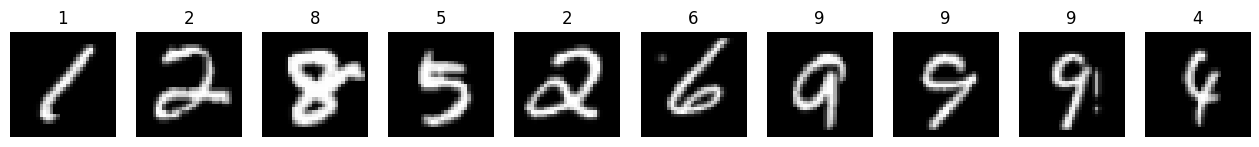

In [ ]:
# show some training images
def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.squeeze().numpy()   # convert from tensor
    plot.imshow(npimg,cmap = "gray")

# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(10):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(1, 10, i + 1)
    # image, label = train_loader.dataset.__getitem__(i)
    # plt.imshow(image.squeeze().numpy())
    imshow(image,plt)
    plt.axis('off')
    plt.title(label)

Now we need to scale our images as the output of a tanh activated generator will contain pixel values in a range from -1 to 1. So, we need to rescale our training images to a range of -1 to 1.

In [ ]:
def scale_images(x, max = 1.00 , min = -1.00):
    x = x * (max - min) + min
    return x

# Defining Model

## Discriminator

The discriminator is a classifier that detects if the input samples are genuine or fabricated. As a result, the discriminator in a GAN is essentially a classifier. It attempts to discern between genuine data and data generated by the generator. It could utilize any network architecture suitable for the type of data it's classifying. Here I will be using convolutional classifier, only without any maxpooling layers. It is recommended to employ a deep network with normalization to deal with this kind of difficult data.

In [ ]:
'''
The inputs to the discriminator are 28x28x1 tensor images
The output would be a single value that will indicate whether a given image is real or fake
'''
def conv(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, batch_norm = True, bias = False):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding)
    #appending convolutional layer
    layers.append(conv_layer)
    #appending batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initializing the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer based on which we will create the  next ones where next  layer depth = 2 * previous layer depth
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim


        self.conv1 = conv(1, conv_dim, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8)
        self.fc = nn.Linear(conv_dim*4*4*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)

        x = x.view(-1, self.conv_dim*4*2*4)

        x = self.fc(x)


        return x

## Generator

The name,itself is self explanatory. The generator component of a GAN learns to generate fake data by incorporating discriminator feedback. It learns to manipulate the discriminator so that its output is classified as real. The generator should upsample an input and create a new image with the same dimensions as our training data (28x28x3). This should mostly consist of transpose convolutional layers with normalzed output.

In [ ]:
def deconv(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, batch_norm = True, bias = False):
    layers = []

    # append transpose conv layer -- we are not using bias terms in conv layers
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))

    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        # complete init function

        self.de_conv1 = deconv(conv_dim*4, conv_dim*2)
        self.de_conv2 = deconv(conv_dim*2, conv_dim)
        self.de_conv3 = deconv(conv_dim, 1, 4, batch_norm=False )

        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 32x32x1 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = self.dropout(x)

        x = x.view(-1, self.conv_dim*4, 4, 4)

        x = F.relu(self.de_conv1(x))
        x = F.relu(self.de_conv2(x))
        x = self.de_conv3(x)
        x = F.tanh(x)


        return x

All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

In [ ]:
#Initializing the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.

def weights_init_normal(m):
    """
    :param m: A module or layer in a network
    """
    # like `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    #  initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal(m.weight.data, 0.0, 0.2)

    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant(m.bias.data, 0.0)

In [ ]:
# model hyperparameters
d_conv_dim = 64
g_conv_dim = 128
z_size = 100
# building discriminator and generator from the classes defined above
discriminator = Discriminator(d_conv_dim)
generator = Generator(z_size=z_size, conv_dim=g_conv_dim)

# initialize model weights
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)
print("done")

done


In [ ]:
# let's look at our discriminator model
print(discriminator)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


In [ ]:
# let's look at our generator model
print(generator)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (de_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv3): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
)


# Training the model

In [ ]:
use_gpu = torch.cuda.is_available()

## Optimizers

In [ ]:
lr = 0.0002 #learning rate
beta1=0.5
beta2=0.999

# optimizers for the discriminator D and generator G
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr, (beta1, beta2)) # for discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), lr, (beta1, beta2)) # for generator

# discriminator_optimizer = torch.optim.Adagrad(discriminator.parameters(), lr) # for discriminator
# generator_optimizer = torch.optim.Adagrad(generator.parameters(), lr) # for generator

## Loss functions for generator
The generator's goal is to get the discriminator to think its generated images are real.

In [ ]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)

    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)

    if use_gpu:
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)

    if use_gpu:
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

Training the discriminator by alternating on real and fake images. Then the generator, which tries to trick the discriminator and should have an opposing loss function.

In [ ]:
def train(D, G, n_epochs, train_on_gpu, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)
            real_images = scale_images(real_images)

            # Train the discriminator on real and fake images
            discriminator_optimizer.zero_grad()

            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)      # Calculates log(D(x))

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()

            fake_images = G(z)

            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)


            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            discriminator_optimizer.step()

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()

            fake_images = G(z)

            D_fake = D(fake_images)

            g_loss = real_loss(D_fake)  # The Generator wishies to minimize the real_loss for it's fake output
                                        # to trick the Discriminator

            g_loss.backward()
            generator_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

In [ ]:
n_epochs = 10
losses = train(discriminator, generator, n_epochs=n_epochs, train_on_gpu = use_gpu)

Epoch [    1/   10] | d_loss: 3.9362 | g_loss: 2.5452
Epoch [    1/   10] | d_loss: 0.0485 | g_loss: 9.7945
Epoch [    1/   10] | d_loss: 0.1007 | g_loss: 12.9477
Epoch [    1/   10] | d_loss: 0.2134 | g_loss: 11.0690
Epoch [    1/   10] | d_loss: 0.0669 | g_loss: 12.0795
Epoch [    1/   10] | d_loss: 0.0182 | g_loss: 11.0277
Epoch [    1/   10] | d_loss: 0.0014 | g_loss: 12.5441
Epoch [    1/   10] | d_loss: 0.0031 | g_loss: 13.5058
Epoch [    1/   10] | d_loss: 0.4876 | g_loss: 8.0332
Epoch [    1/   10] | d_loss: 0.0032 | g_loss: 12.2351
Epoch [    1/   10] | d_loss: 0.0353 | g_loss: 8.8995
Epoch [    1/   10] | d_loss: 0.2360 | g_loss: 9.1122
Epoch [    1/   10] | d_loss: 0.0097 | g_loss: 11.0423
Epoch [    1/   10] | d_loss: 0.0064 | g_loss: 12.6557
Epoch [    1/   10] | d_loss: 0.0225 | g_loss: 11.7196
Epoch [    1/   10] | d_loss: 0.0555 | g_loss: 7.2610
Epoch [    1/   10] | d_loss: 0.0027 | g_loss: 9.4715
Epoch [    1/   10] | d_loss: 0.0303 | g_loss: 12.7709
Epoch [    1/   1

## Training loss

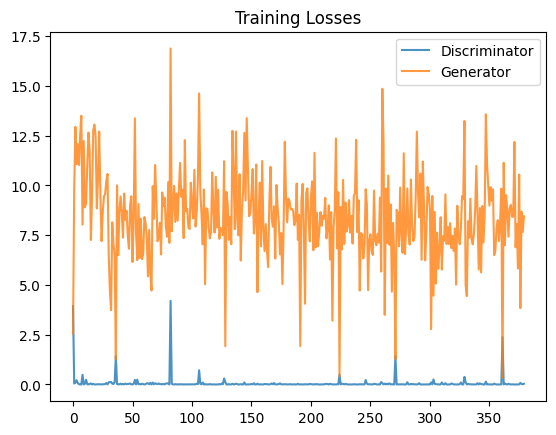

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.8)
plt.plot(losses.T[1], label='Generator', alpha=0.8)
plt.title("Training Losses")
plt.legend()

# Visualize the generated images

In [ ]:
def view_samples(epoch,samples):
    plt.figure(figsize=(12, 5))
    batch=samples[epoch]
    for i in range(10):
        image = batch[i].detach().cpu()
        plt.subplot(2, 5, i + 1)
        plt.imshow(image.squeeze().numpy(),cmap="gray")
        plt.axis('off')

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Example of 10 images generated from random codewords

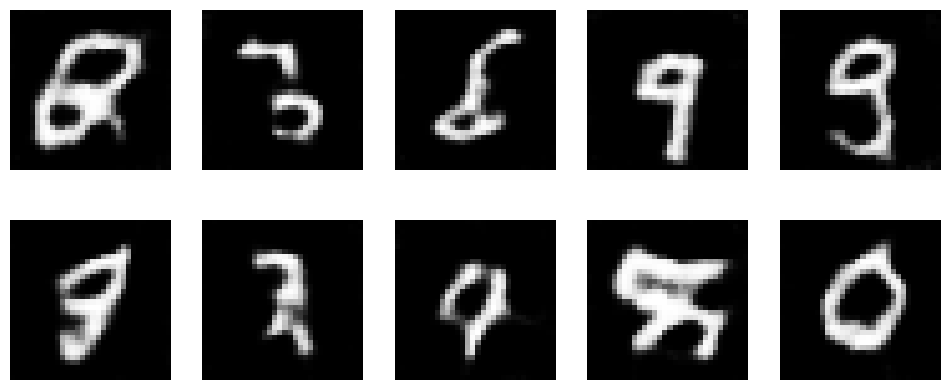

In [ ]:
_ = view_samples(-1, samples)

### 5 examples of the following:
Pick two random codewords, a and b, and
pick 10 uniformly spaced points between a and b on the line from a to b. Show
the images generated from these 12 points

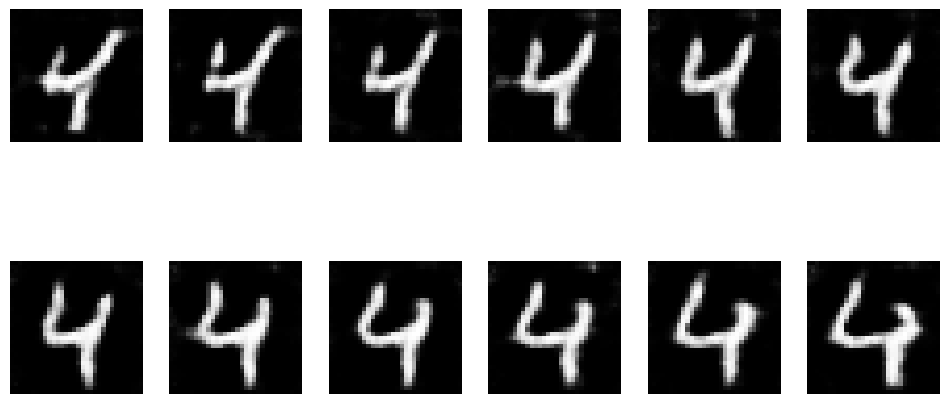

In [ ]:
num_points = 13
import tensorflow as tf

a = np.random.uniform(-1, 1, size=(32, 100))
a = torch.from_numpy(a).float()
b = np.random.uniform(-1, 1, size=(32, 100))
b = torch.from_numpy(b).float()

interpolation_points = [a + (b - a) * t / (num_points - 1) for t in range(num_points)]

generated_images = []

for point in interpolation_points:
  if use_gpu:
    point = point.cuda()
    image = generator(point)
    generated_images.append(image)

plt.figure(figsize=(12, 6))
batch=generated_images[-1]
for i in range(1,num_points):
    image = generated_images[-i].detach().cpu()
    plt.subplot(2, 6, i )
    plt.imshow(image[0, 0, :, :]*255.0,cmap="gray")
    plt.axis('off')


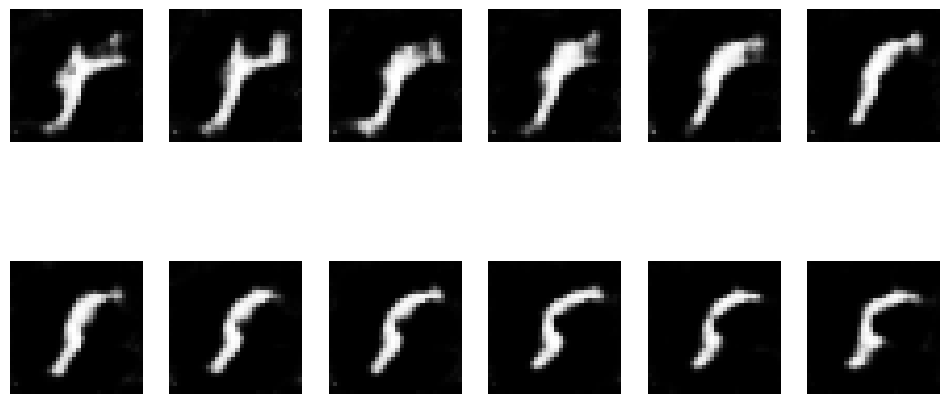

In [ ]:
num_points = 13
import tensorflow as tf

a = np.random.uniform(-1, 1, size=(32, 100))
a = torch.from_numpy(a).float()
b = np.random.uniform(-1, 1, size=(32, 100))
b = torch.from_numpy(b).float()

interpolation_points = [a + (b - a) * t / (num_points - 1) for t in range(num_points)]

generated_images = []

for point in interpolation_points:
  if use_gpu:
    point = point.cuda()
    image = generator(point)
    generated_images.append(image)

plt.figure(figsize=(12, 6))
batch=generated_images[-1]
for i in range(1,num_points):
    image = generated_images[-i].detach().cpu()
    plt.subplot(2, 6, i )
    plt.imshow(image[0, 0, :, :]*255.0,cmap="gray")
    plt.axis('off')


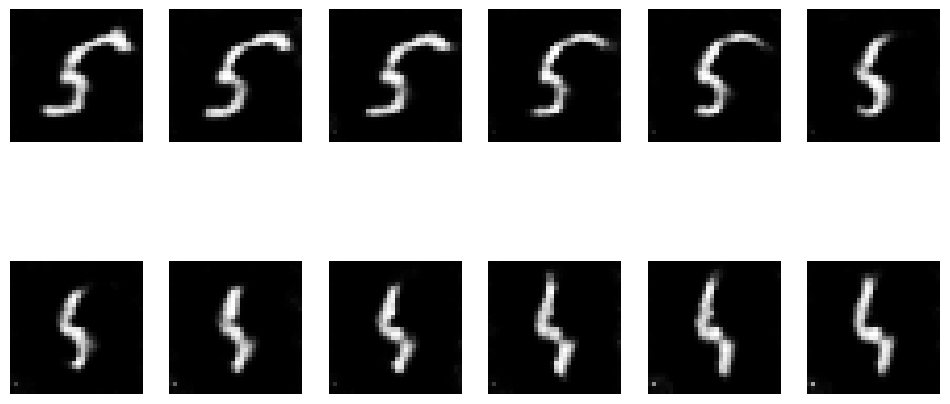

In [ ]:
num_points = 13
import tensorflow as tf

a = np.random.uniform(-1, 1, size=(32, 100))
a = torch.from_numpy(a).float()
b = np.random.uniform(-1, 1, size=(32, 100))
b = torch.from_numpy(b).float()

interpolation_points = [a + (b - a) * t / (num_points - 1) for t in range(num_points)]

generated_images = []

for point in interpolation_points:
  if use_gpu:
    point = point.cuda()
    image = generator(point)
    generated_images.append(image)

plt.figure(figsize=(12, 6))
batch=generated_images[-1]
for i in range(1,num_points):
    image = generated_images[-i].detach().cpu()
    plt.subplot(2, 6, i )
    plt.imshow(image[0, 0, :, :]*255.0,cmap="gray")
    plt.axis('off')


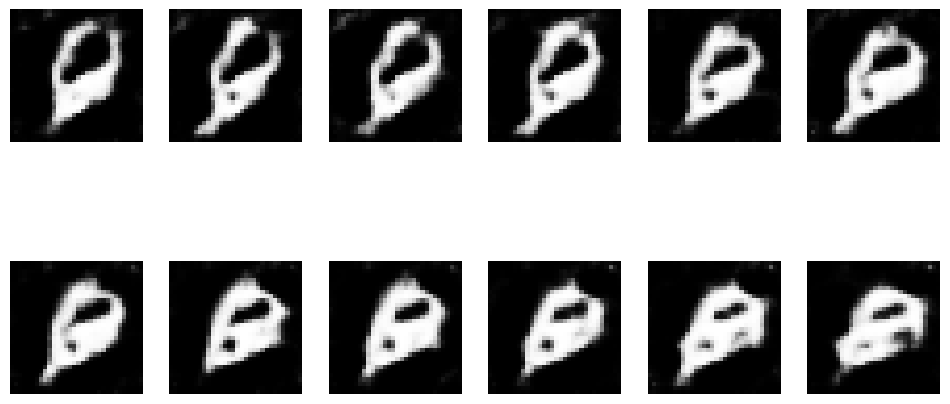

In [ ]:
num_points = 13
import tensorflow as tf

a = np.random.uniform(-1, 1, size=(32, 100))
a = torch.from_numpy(a).float()
b = np.random.uniform(-1, 1, size=(32, 100))
b = torch.from_numpy(b).float()

interpolation_points = [a + (b - a) * t / (num_points - 1) for t in range(num_points)]

generated_images = []

for point in interpolation_points:
  if use_gpu:
    point = point.cuda()
    image = generator(point)
    generated_images.append(image)

plt.figure(figsize=(12, 6))
batch=generated_images[-1]
for i in range(1,num_points):
    image = generated_images[-i].detach().cpu()
    plt.subplot(2, 6, i )
    plt.imshow(image[0, 0, :, :]*255.0,cmap="gray")
    plt.axis('off')


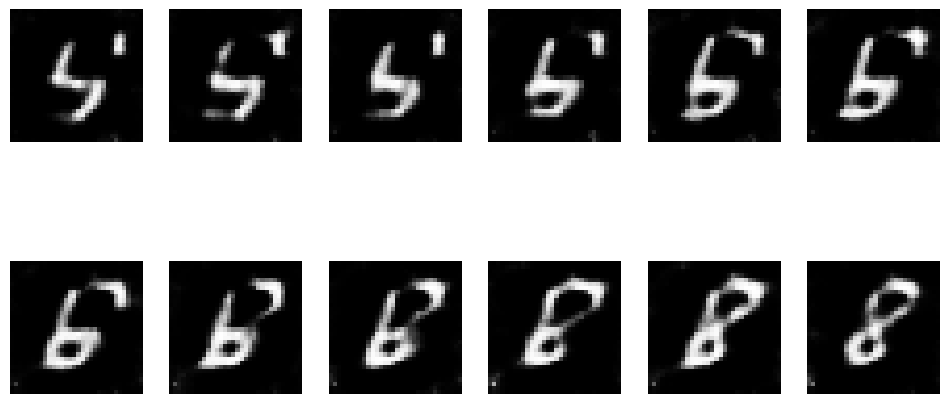

In [ ]:
num_points = 13
import tensorflow as tf

a = np.random.uniform(-1, 1, size=(32, 100))
a = torch.from_numpy(a).float()
b = np.random.uniform(-1, 1, size=(32, 100))
b = torch.from_numpy(b).float()

interpolation_points = [a + (b - a) * t / (num_points - 1) for t in range(num_points)]

generated_images = []

for point in interpolation_points:
  if use_gpu:
    point = point.cuda()
    image = generator(point)
    generated_images.append(image)

plt.figure(figsize=(12, 6))
batch=generated_images[-1]
for i in range(1,num_points):
    image = generated_images[-i].detach().cpu()
    plt.subplot(2, 6, i )
    plt.imshow(image[0, 0, :, :]*255.0,cmap="gray")
    plt.axis('off')


## The VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self, d=50):
        super().__init__()
        self.d = d #latent dimension

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2) # we have mean and variance, each is d-dim vector
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Tanh()
        )

    def sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.sampler(mu, logvar)
        return self.decoder(z), mu, logvar

    def generate(self, N=10):
        z = torch.randn((N, self.d)).to(device)
        gen_img = self.decoder(z)
        return gen_img


## The Loss Function

In [ ]:
# The Loss function
def loss_function(x_hat, x, mu, logvar, beta=1):
    #recon_loss = nn.functional.binary_cross_entropy(
    recon_loss = nn.functional.mse_loss(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return recon_loss + beta * KLD


## Train the VAE Model

====> Test set loss: 733.9080


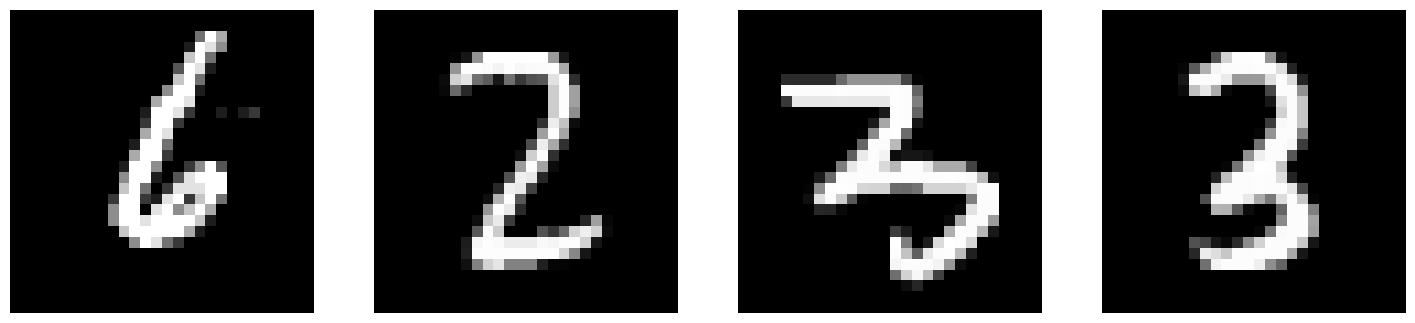

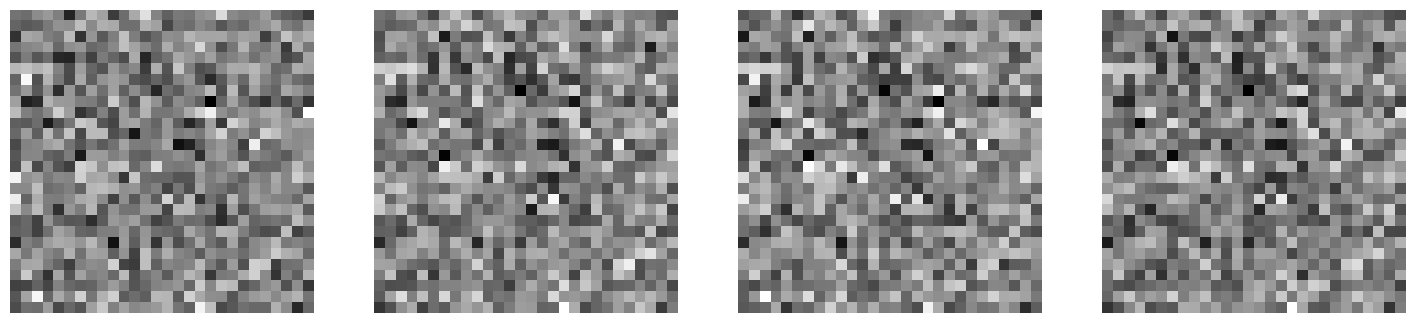

====> Epoch: 1 Average loss: 149.2628
====> Test set loss: 90.8569


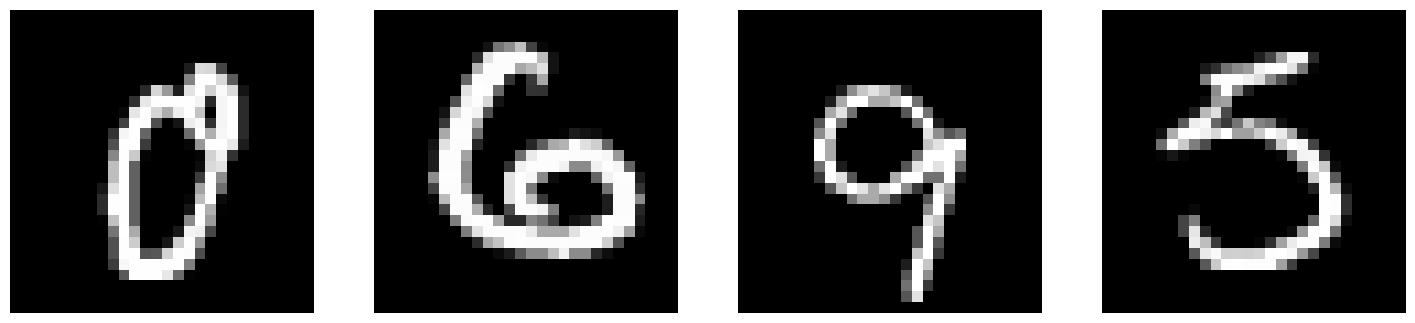

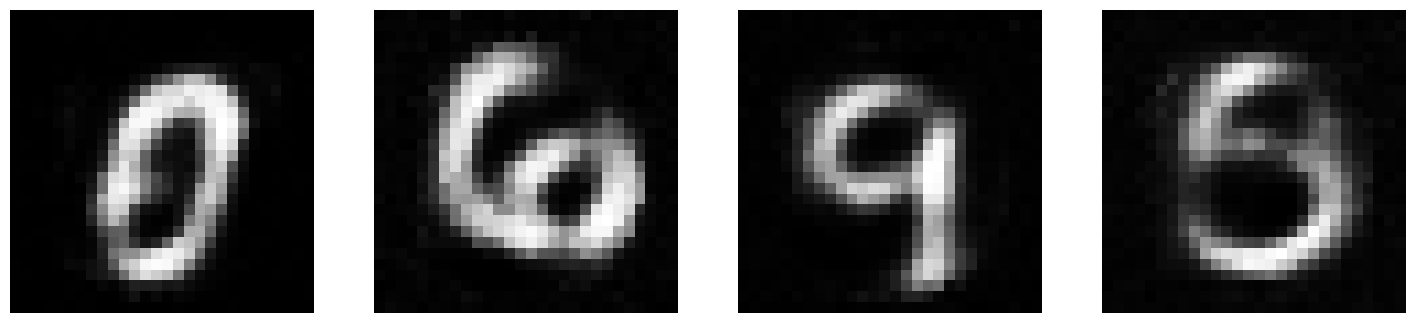

====> Epoch: 2 Average loss: 90.5993
====> Test set loss: 74.0089


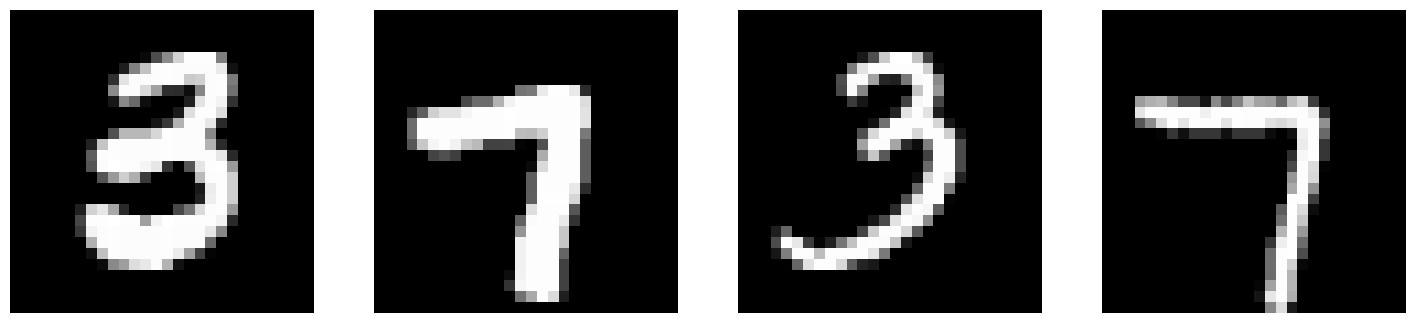

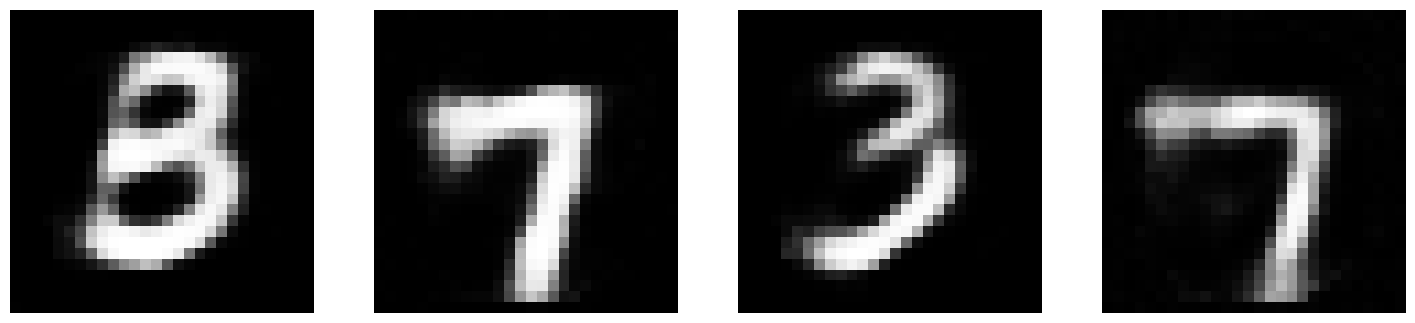

====> Epoch: 3 Average loss: 81.6799
====> Test set loss: 69.6898


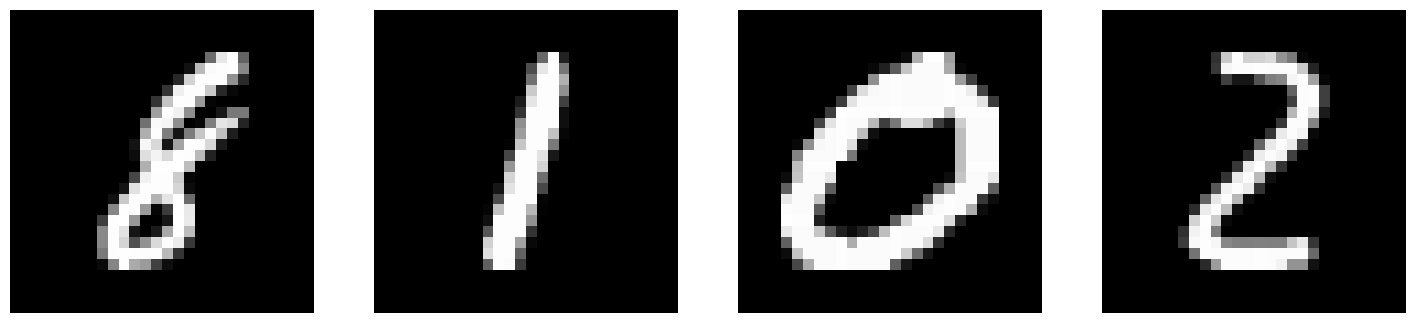

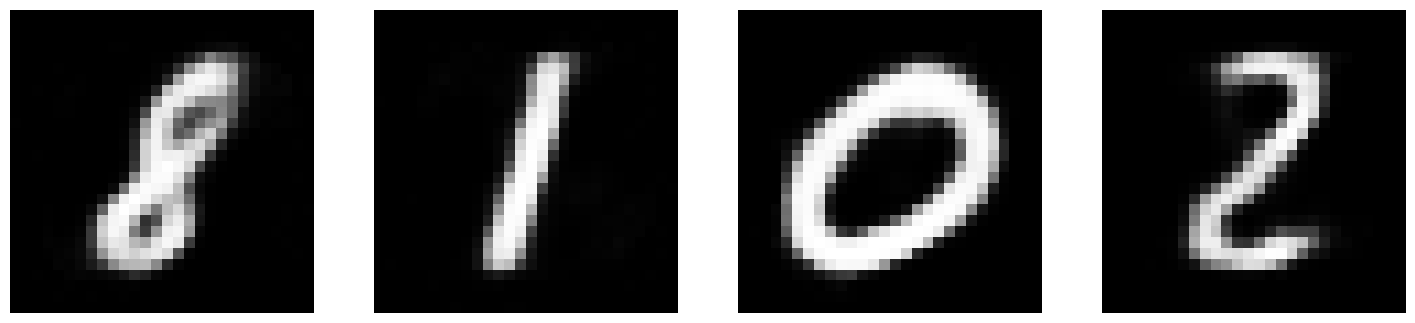

====> Epoch: 4 Average loss: 77.9988
====> Test set loss: 66.9472


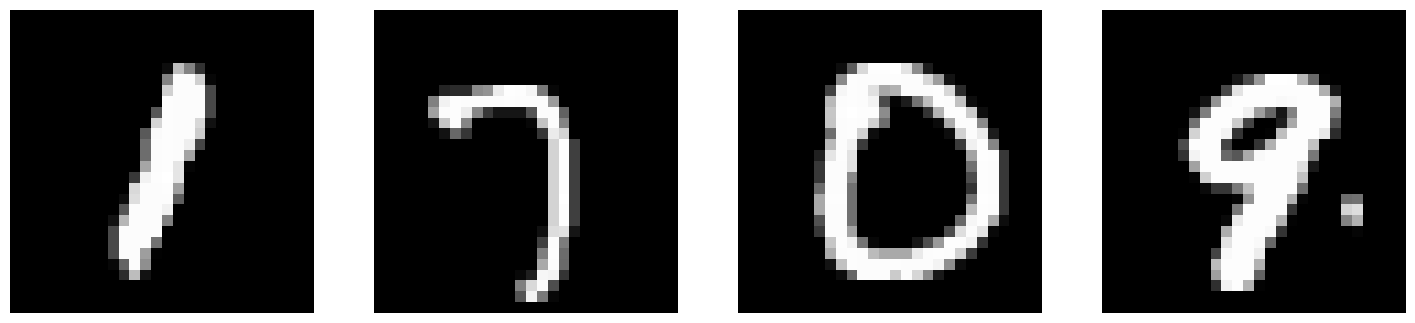

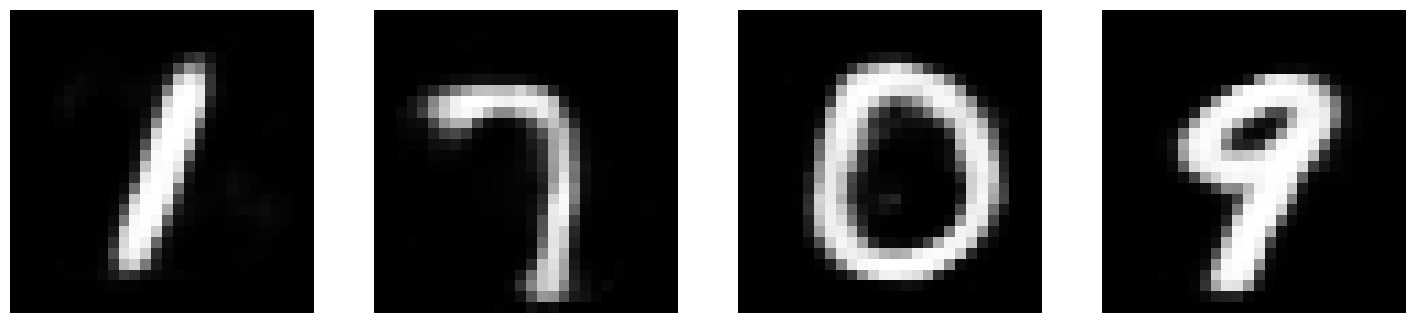

====> Epoch: 5 Average loss: 75.7345
====> Test set loss: 65.8732


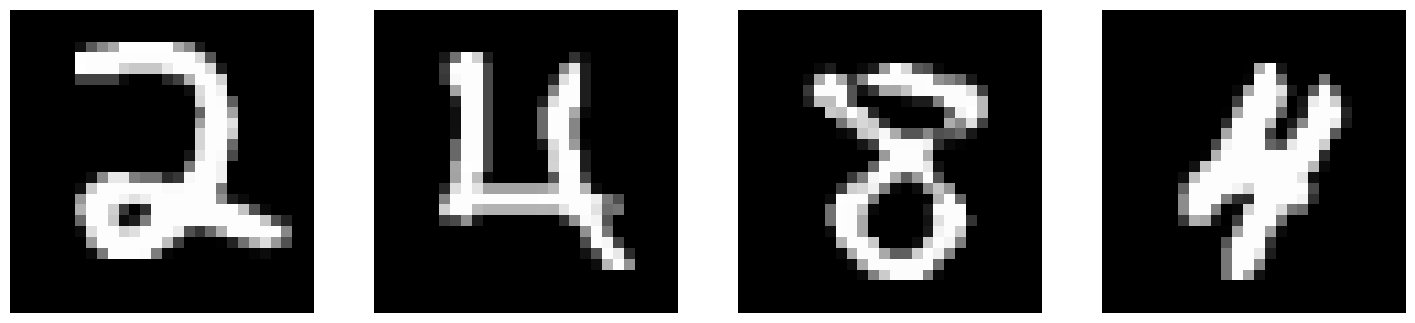

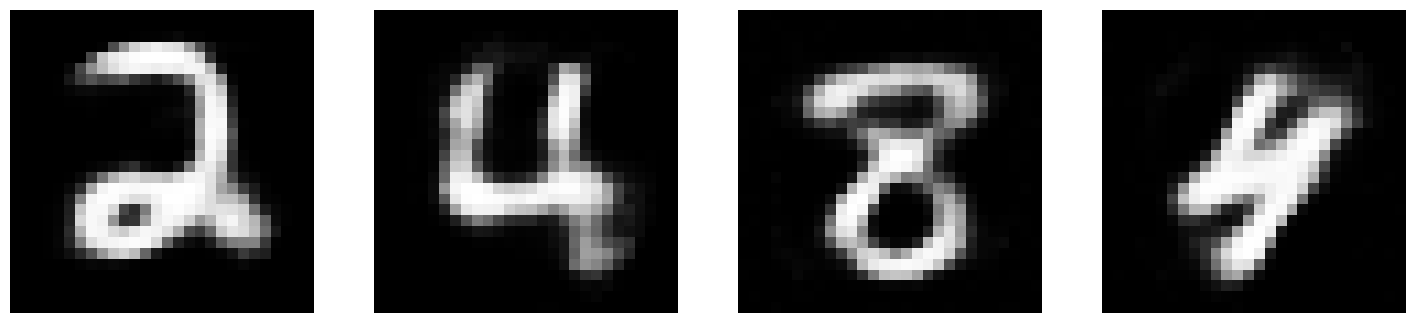

====> Epoch: 6 Average loss: 74.1985
====> Test set loss: 64.7625


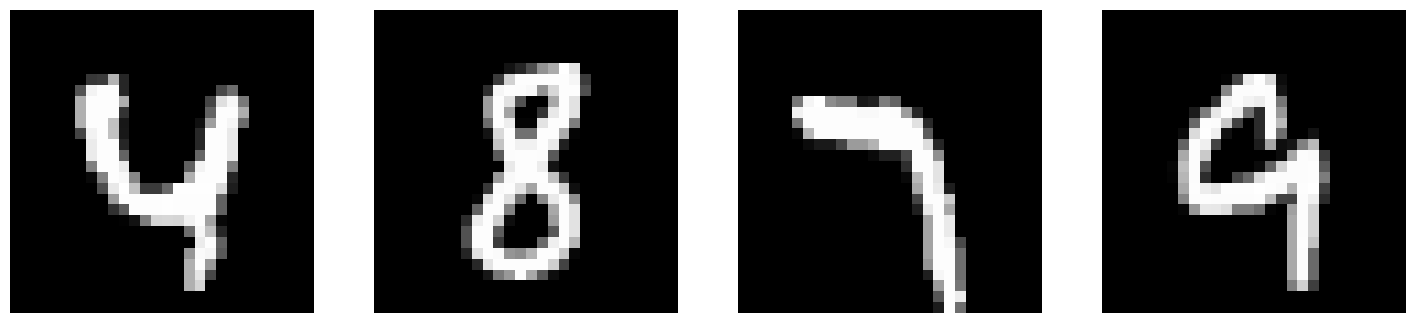

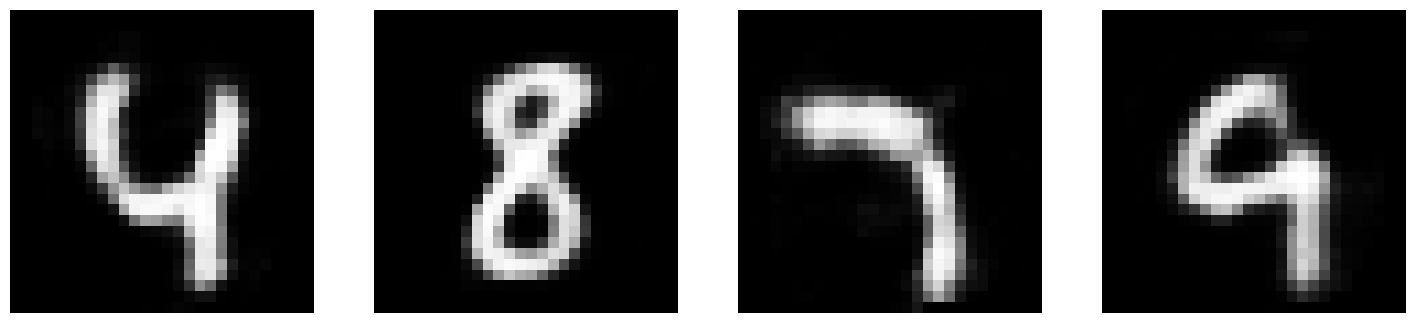

====> Epoch: 7 Average loss: 73.1023
====> Test set loss: 63.0725


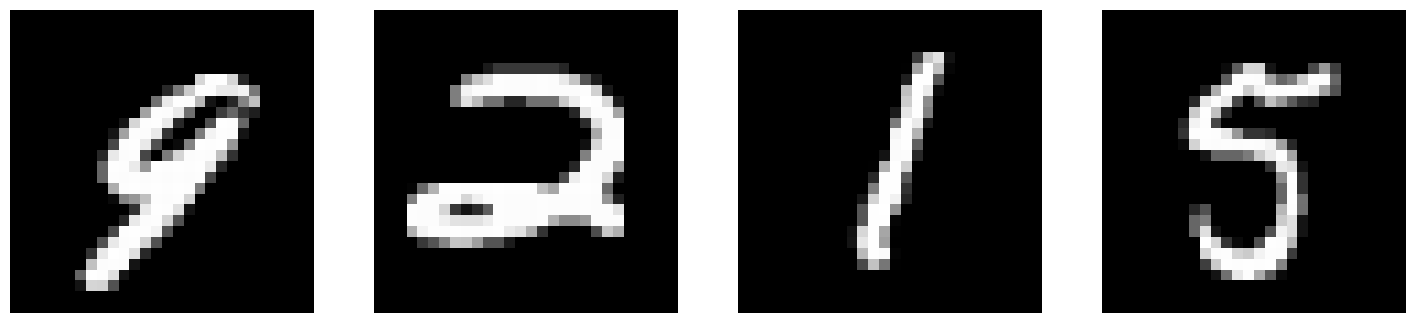

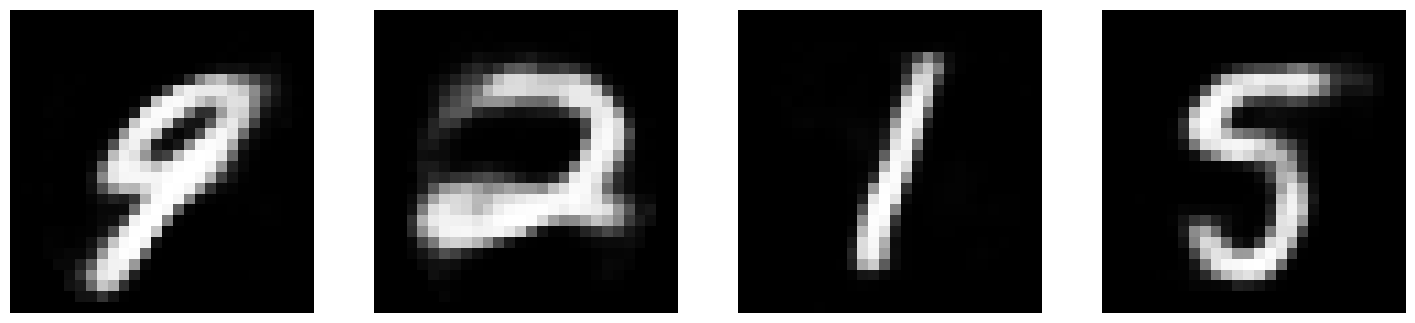

====> Epoch: 8 Average loss: 72.2116
====> Test set loss: 62.8723


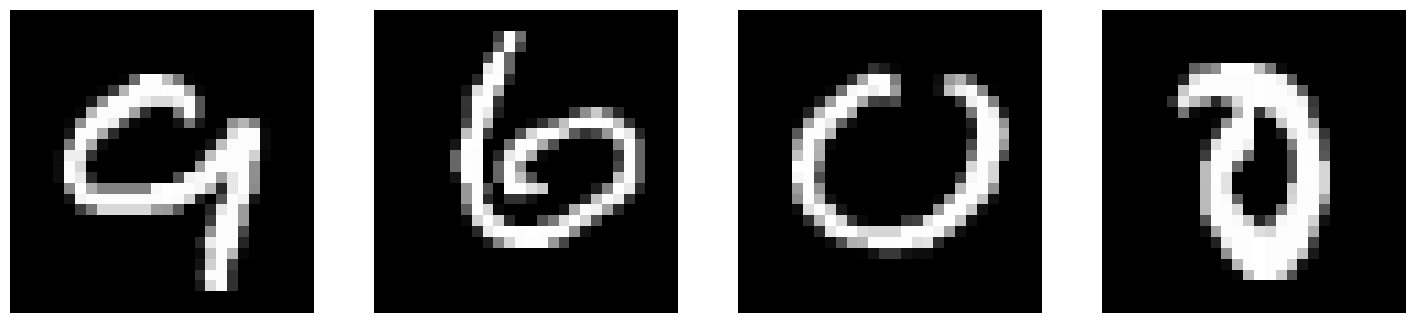

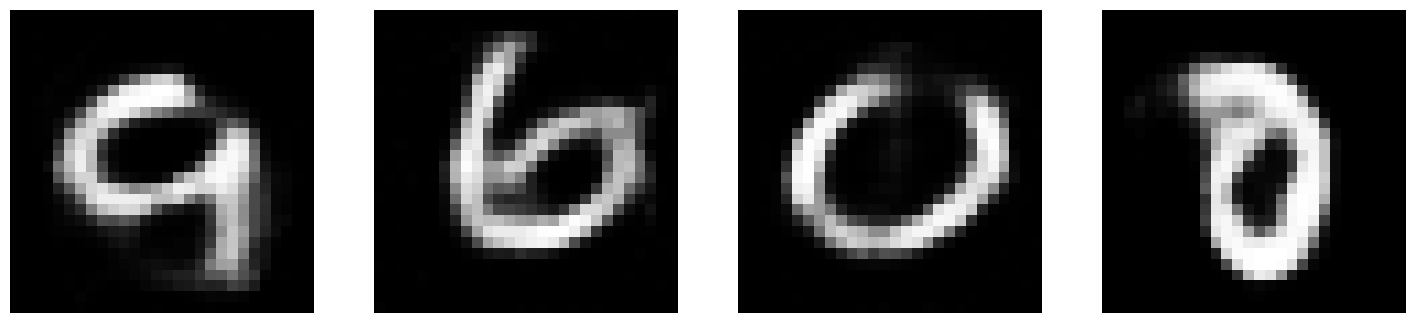

====> Epoch: 9 Average loss: 71.4565
====> Test set loss: 62.1482


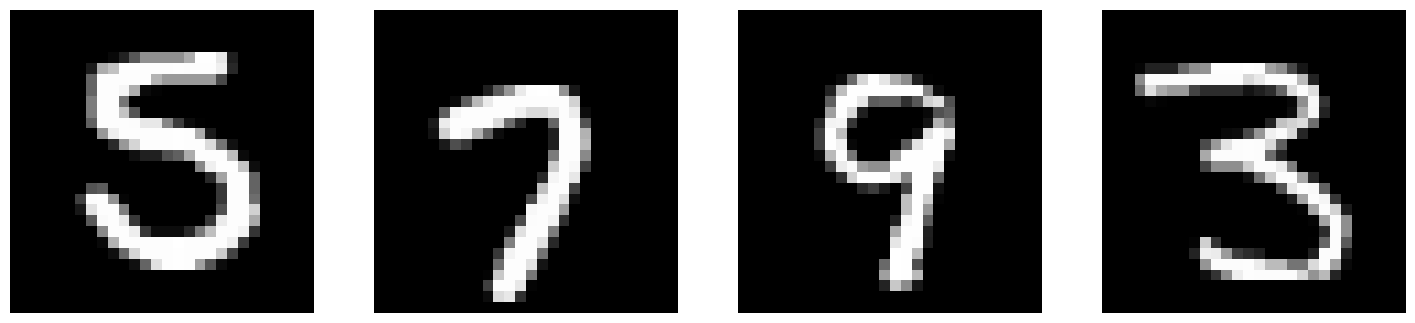

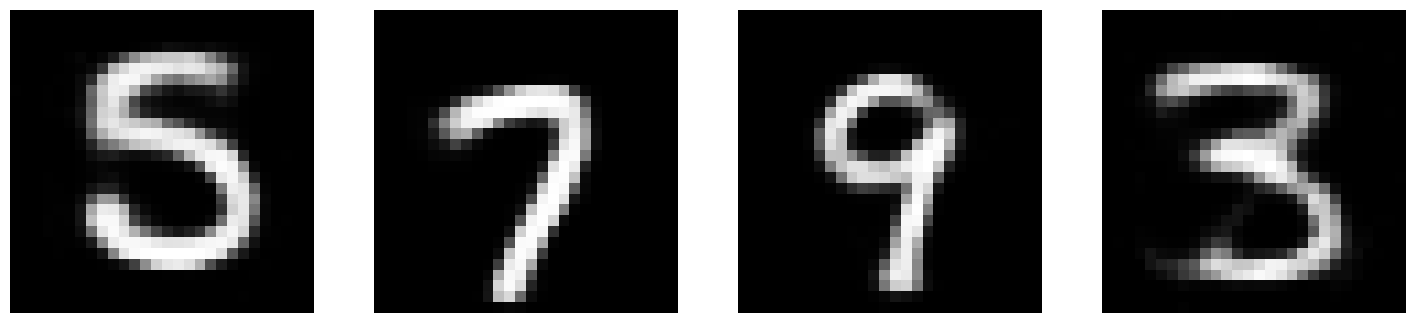

====> Epoch: 10 Average loss: 70.8241
====> Test set loss: 61.5177


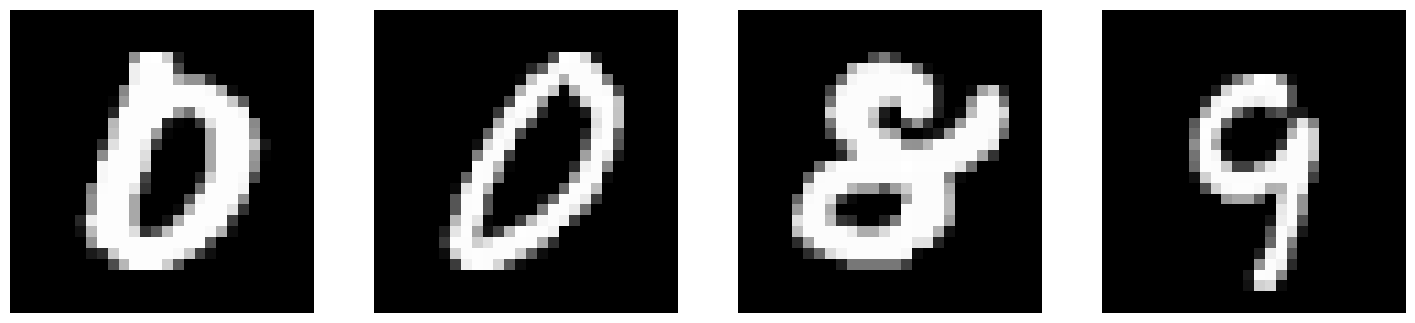

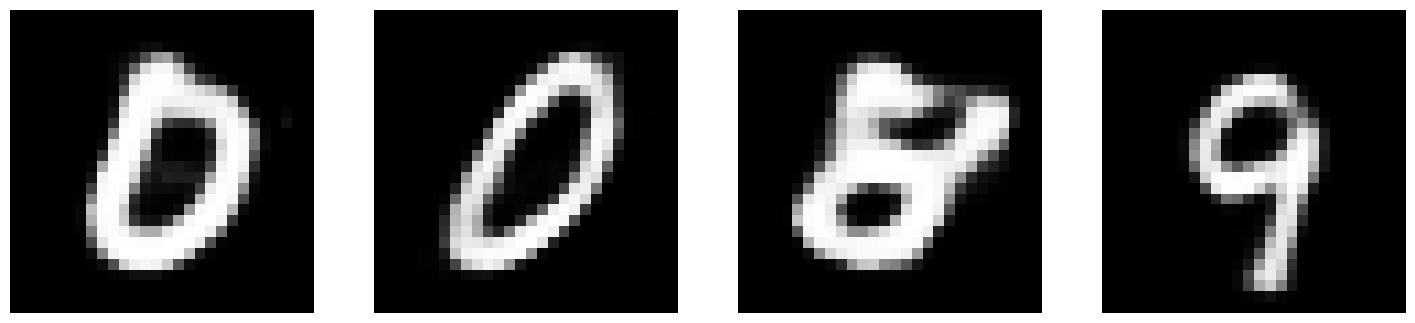

====> Epoch: 11 Average loss: 70.3995
====> Test set loss: 61.1158


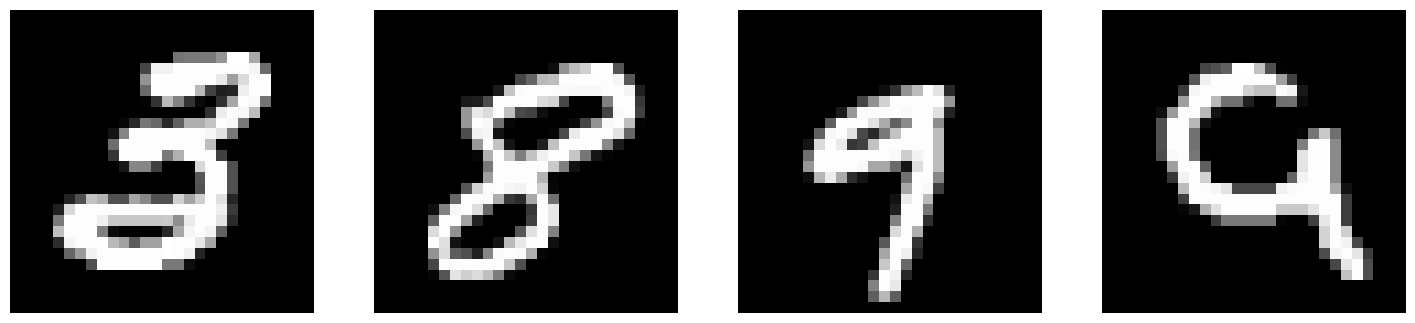

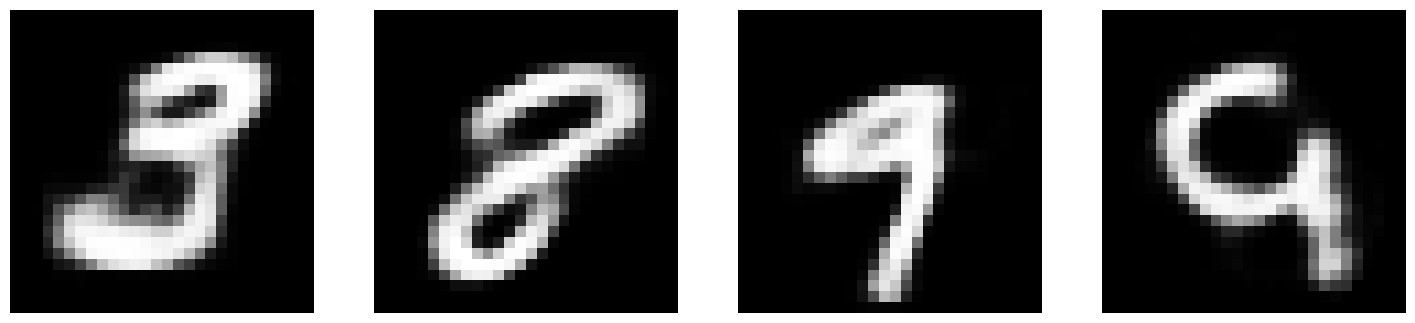

====> Epoch: 12 Average loss: 69.9026
====> Test set loss: 60.8749


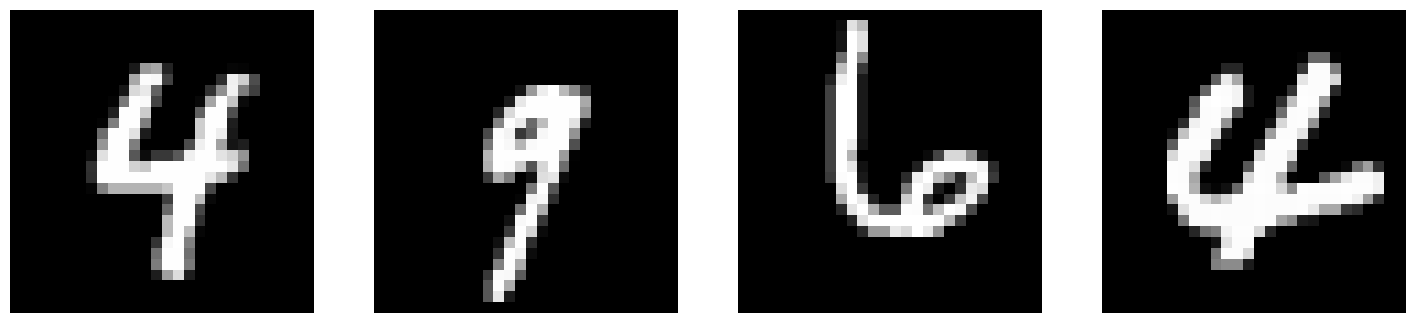

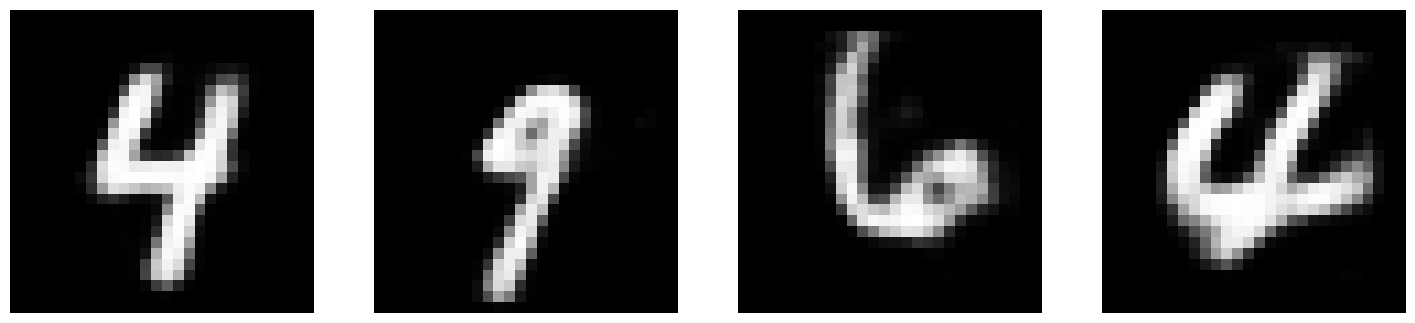

====> Epoch: 13 Average loss: 69.5827
====> Test set loss: 61.1719


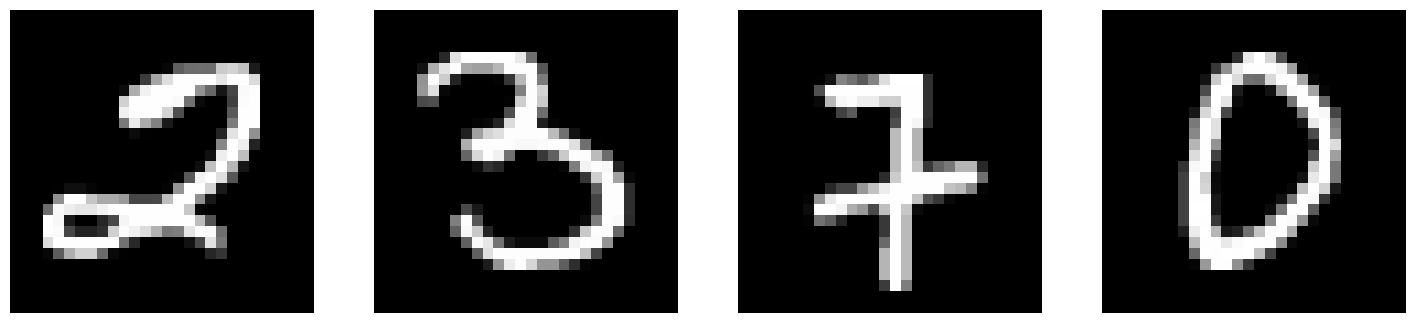

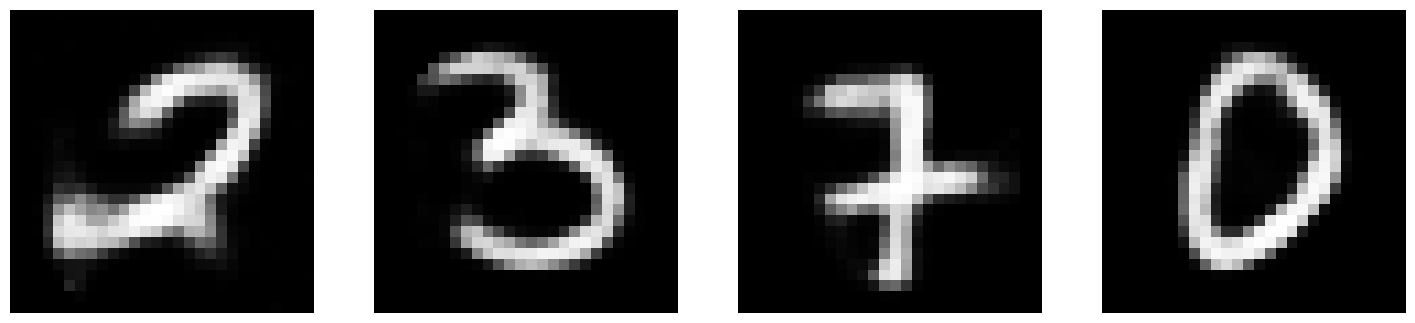

====> Epoch: 14 Average loss: 69.2441
====> Test set loss: 61.0975


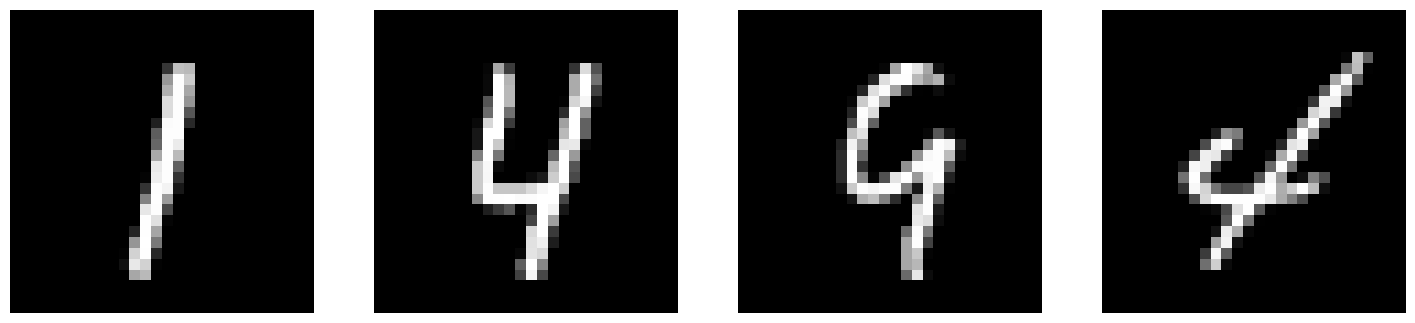

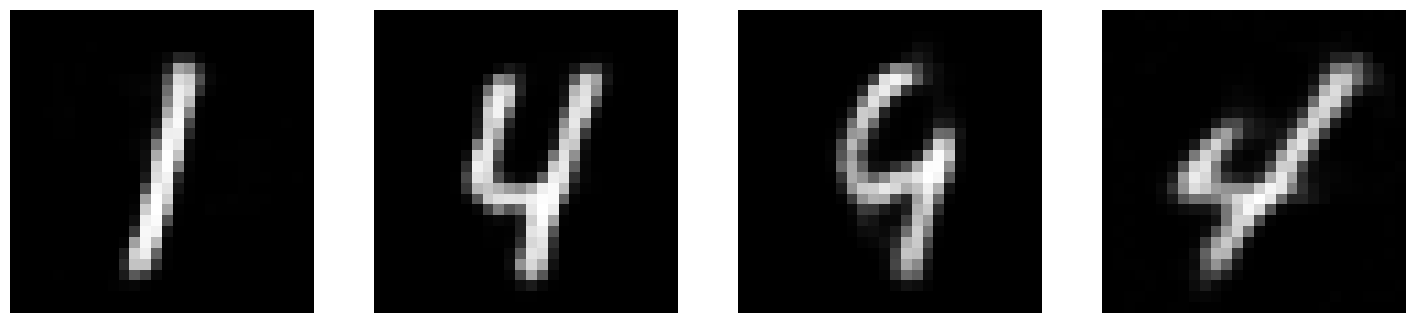

====> Epoch: 15 Average loss: 68.7831
====> Test set loss: 58.8672


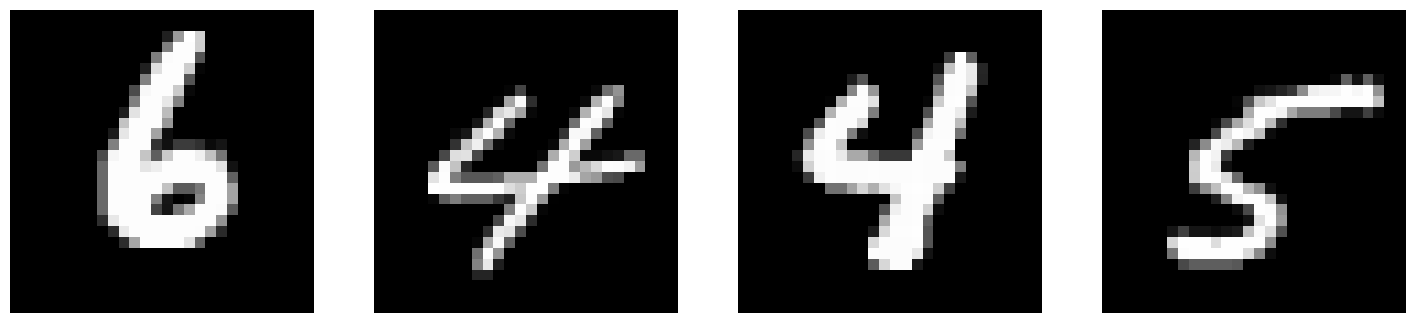

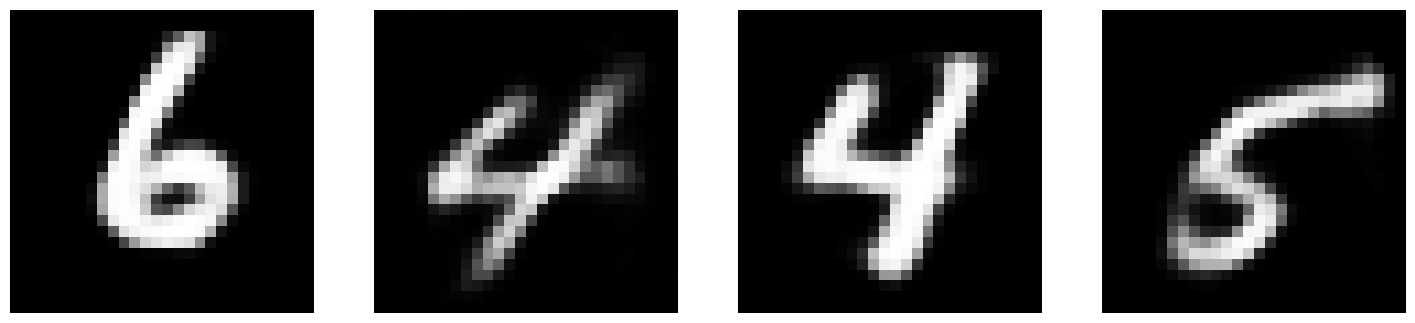

====> Epoch: 16 Average loss: 68.5418
====> Test set loss: 58.8682


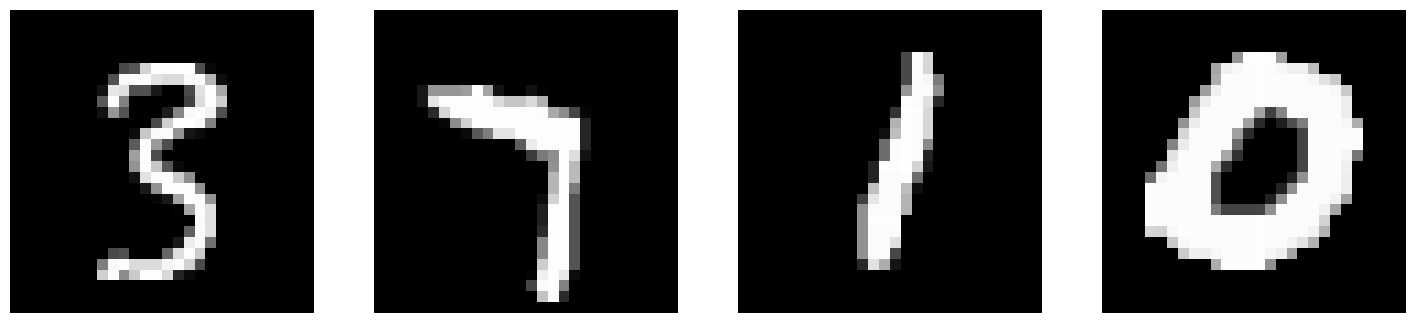

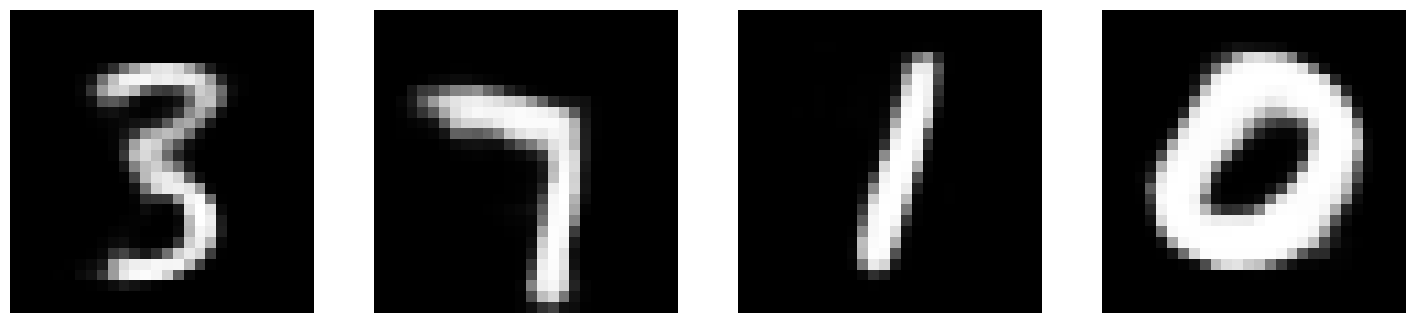

====> Epoch: 17 Average loss: 68.2683
====> Test set loss: 59.6200


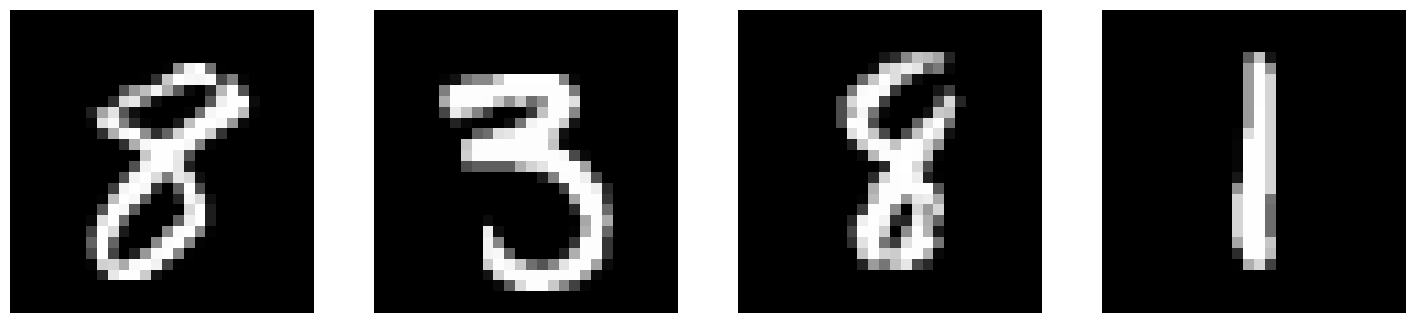

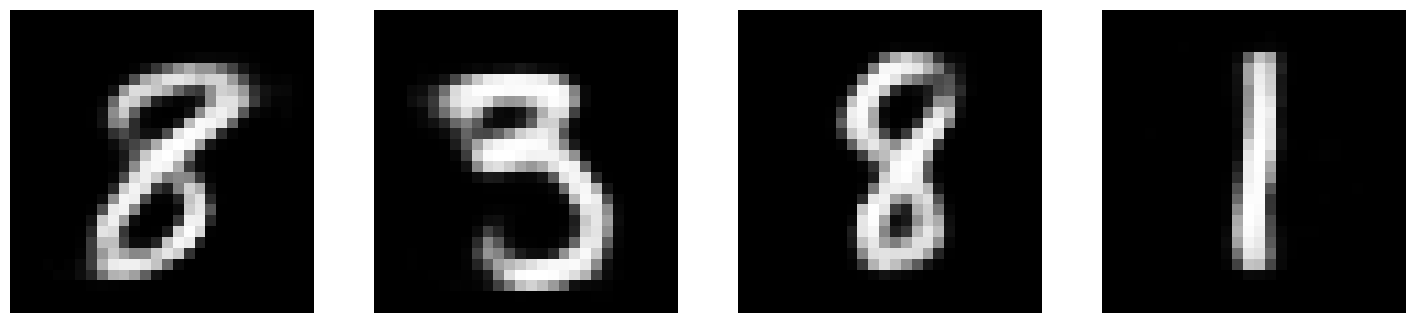

====> Epoch: 18 Average loss: 68.0837
====> Test set loss: 58.9758


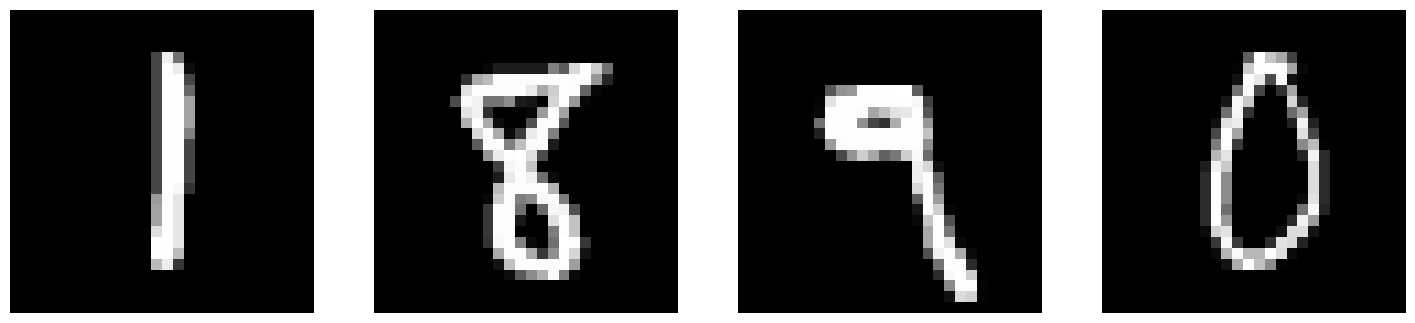

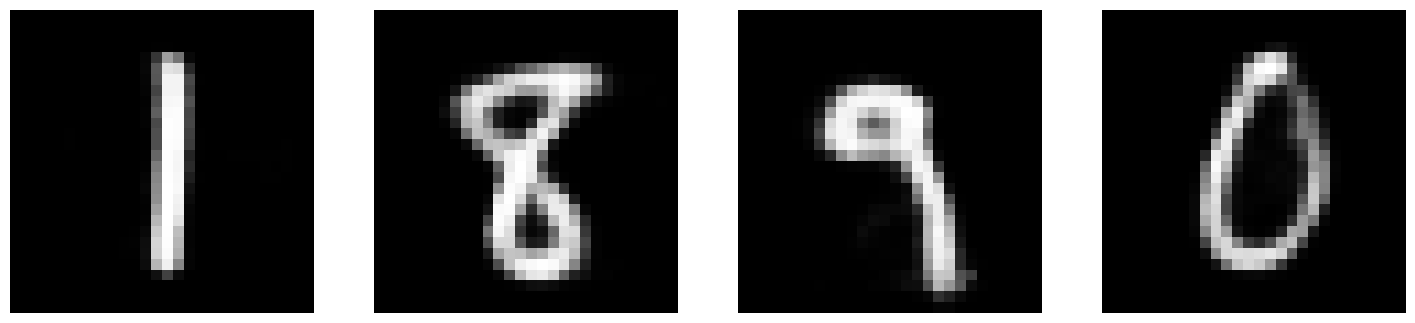

====> Epoch: 19 Average loss: 67.8043
====> Test set loss: 58.8135


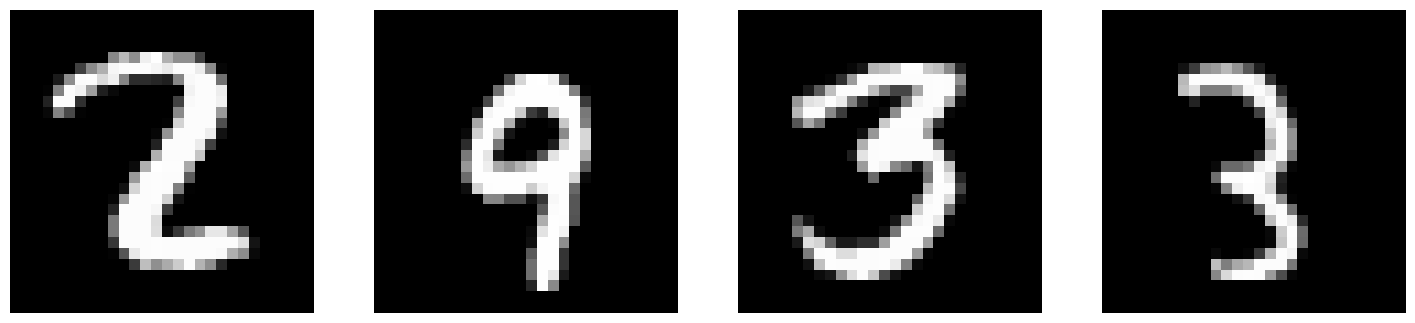

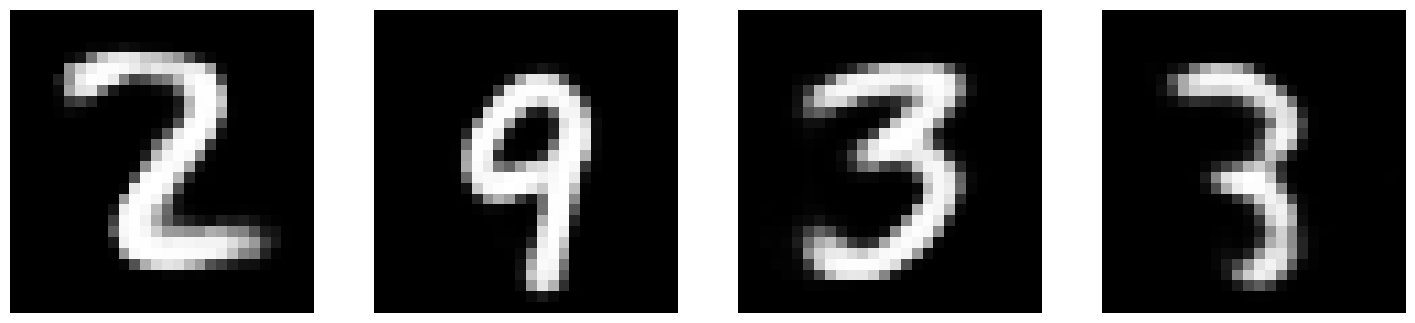

====> Epoch: 20 Average loss: 67.5375
====> Test set loss: 59.1061


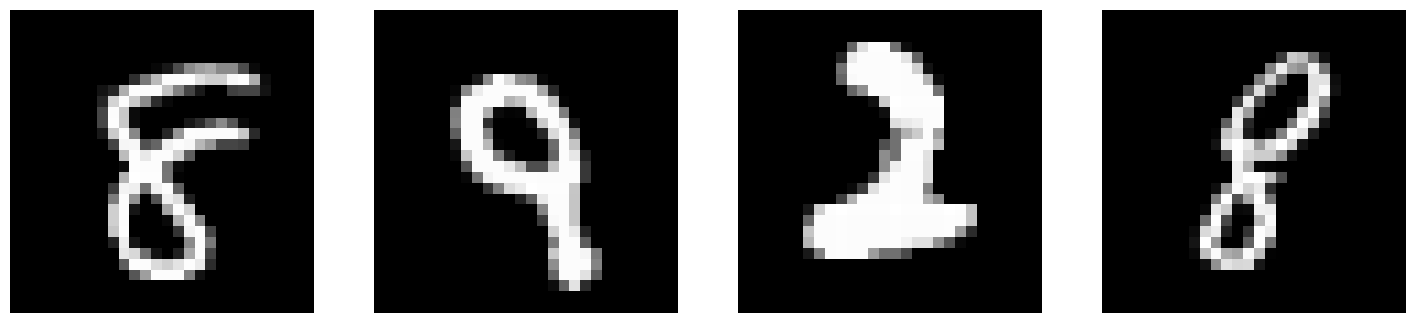

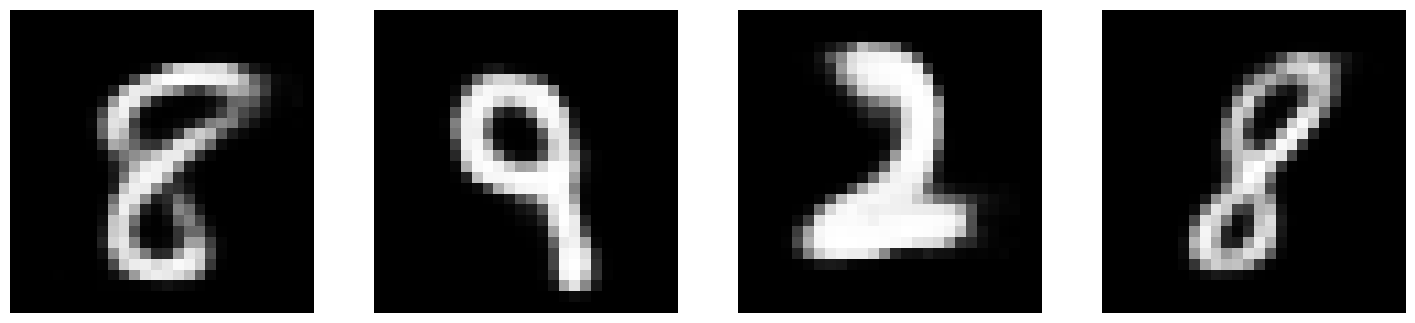

====> Epoch: 21 Average loss: 67.3961
====> Test set loss: 58.1253


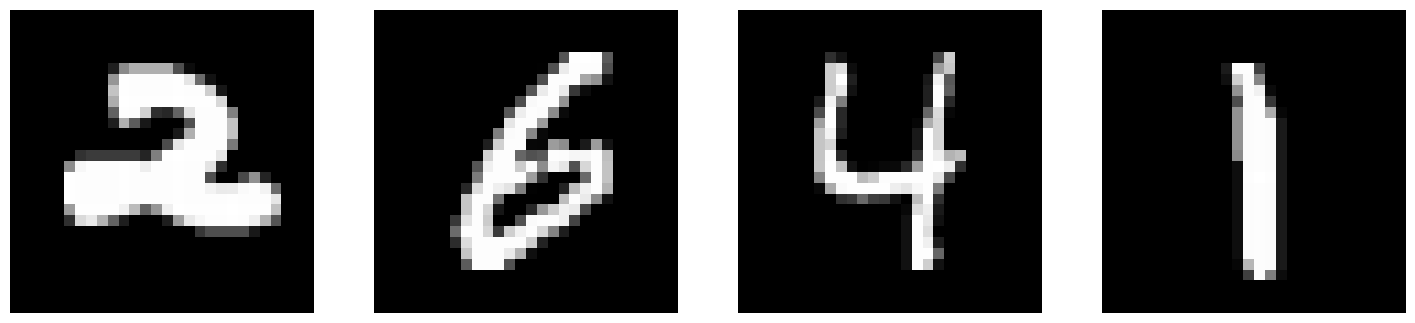

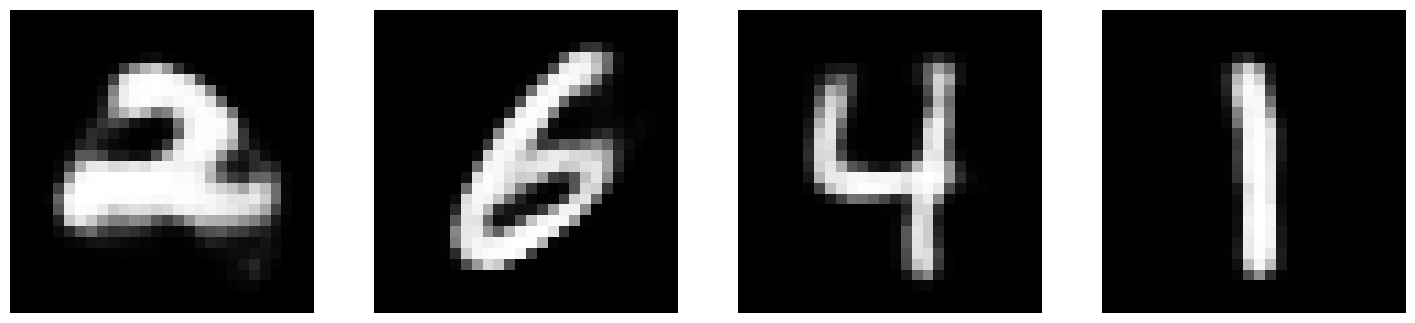

====> Epoch: 22 Average loss: 67.2134
====> Test set loss: 58.3754


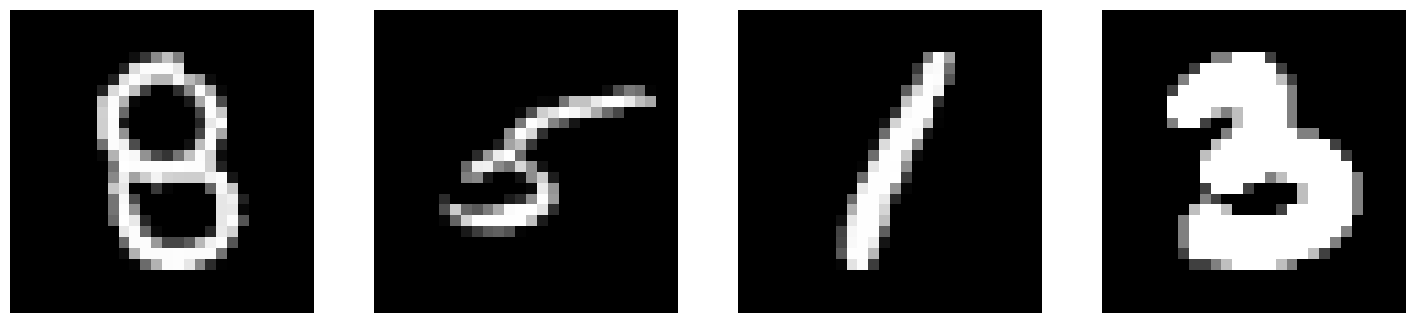

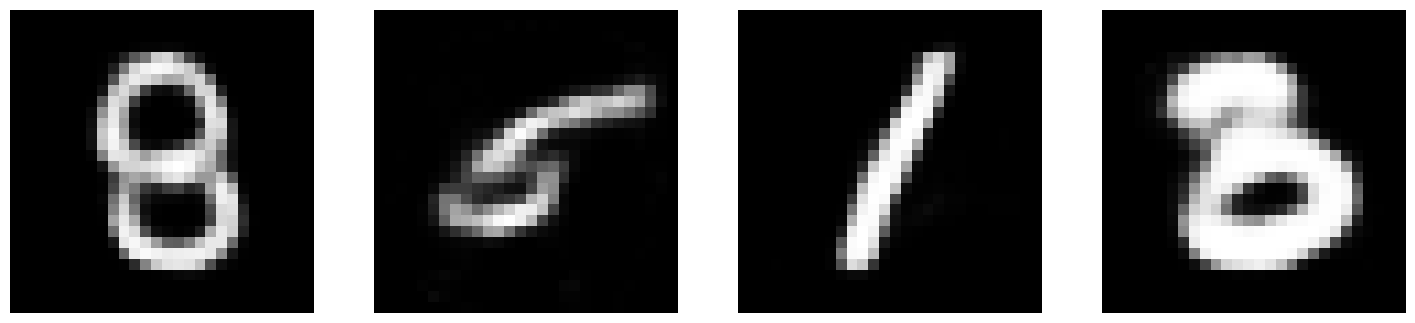

====> Epoch: 23 Average loss: 67.0529
====> Test set loss: 57.5809


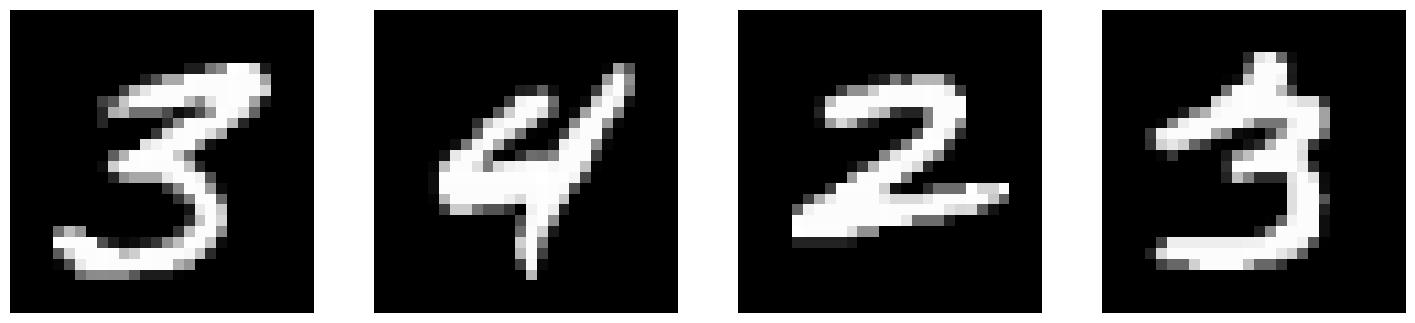

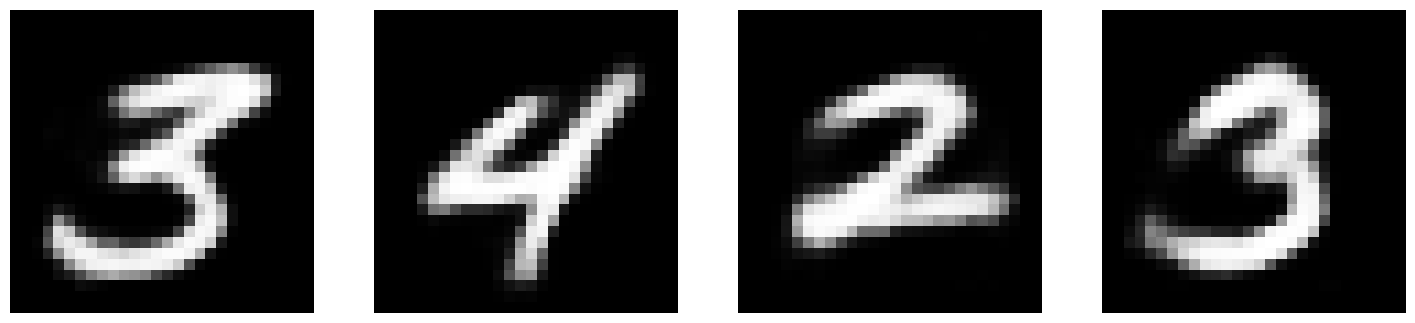

====> Epoch: 24 Average loss: 66.8134
====> Test set loss: 57.3598


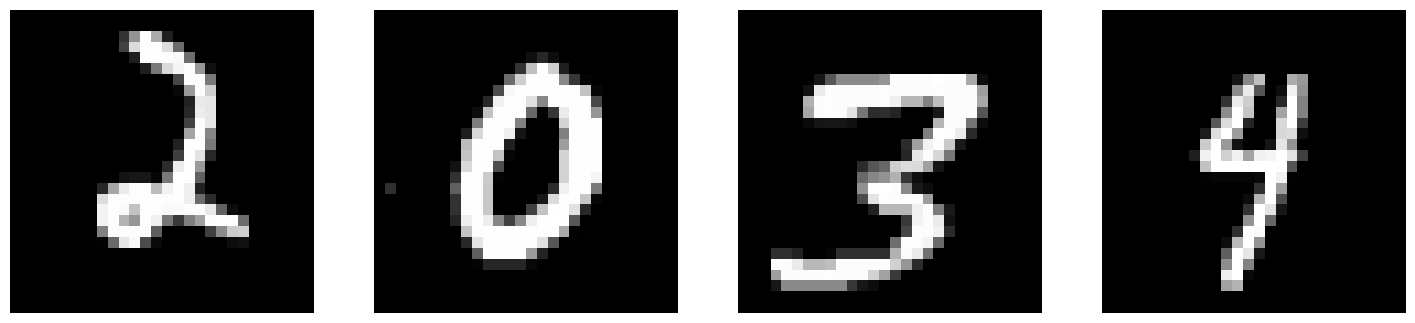

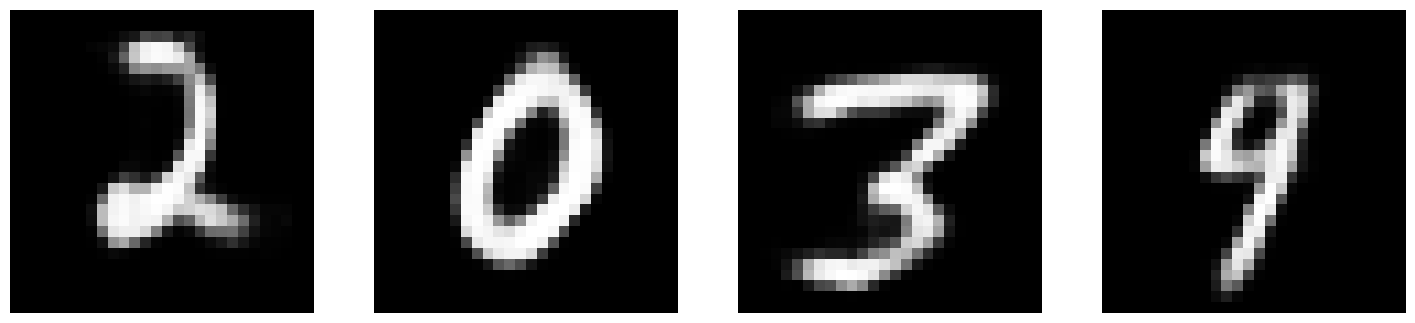

====> Epoch: 25 Average loss: 66.7521
====> Test set loss: 57.8187


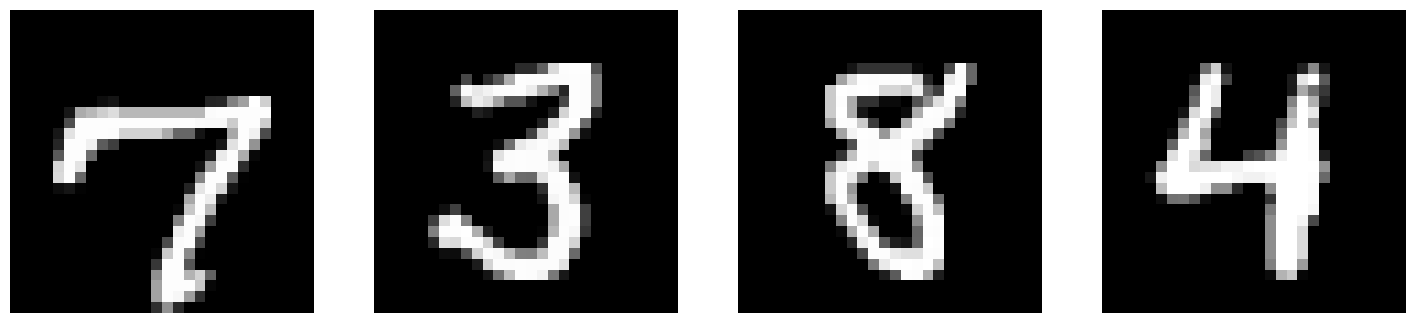

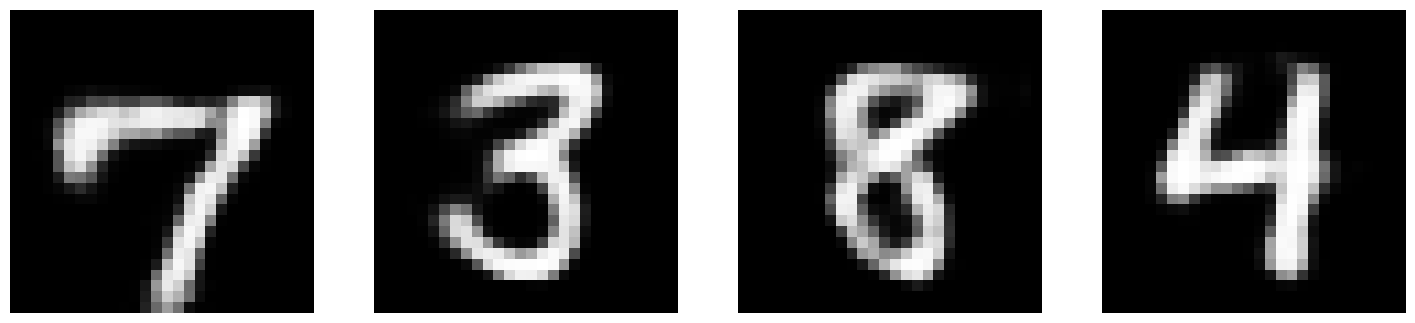

====> Epoch: 26 Average loss: 66.4809
====> Test set loss: 57.8295


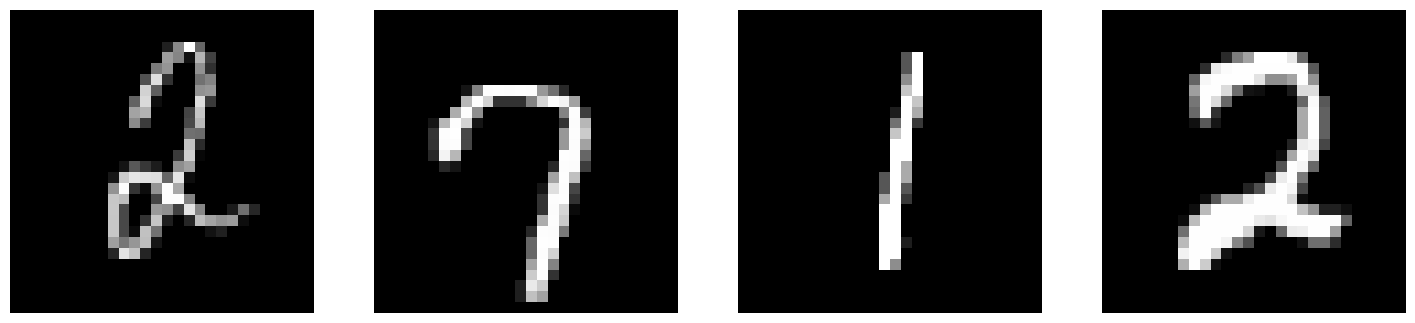

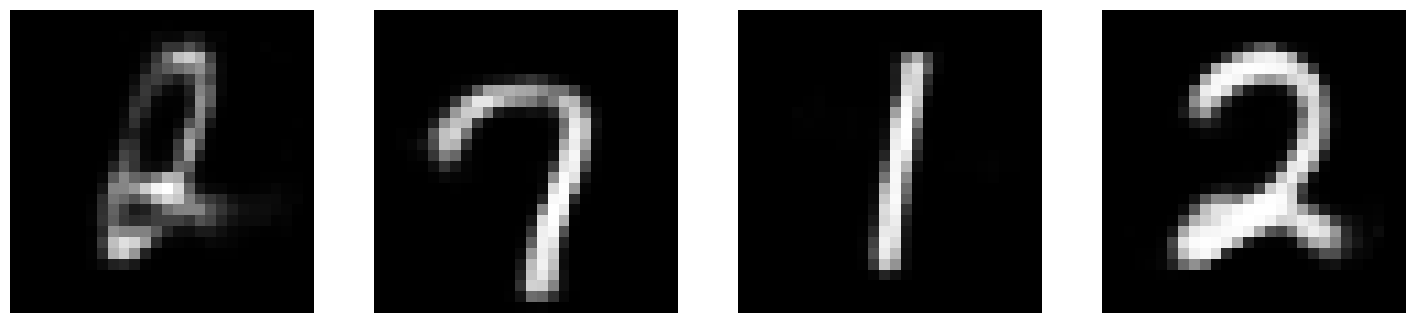

====> Epoch: 27 Average loss: 66.4108
====> Test set loss: 57.3652


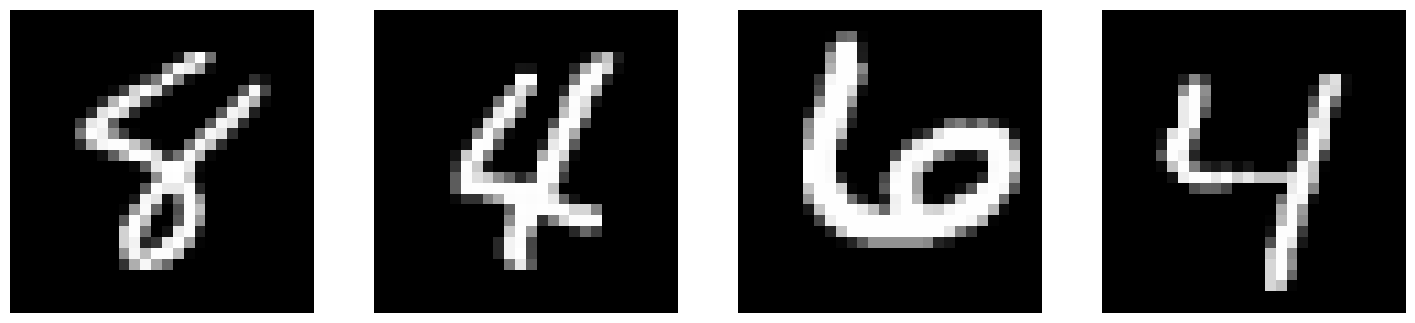

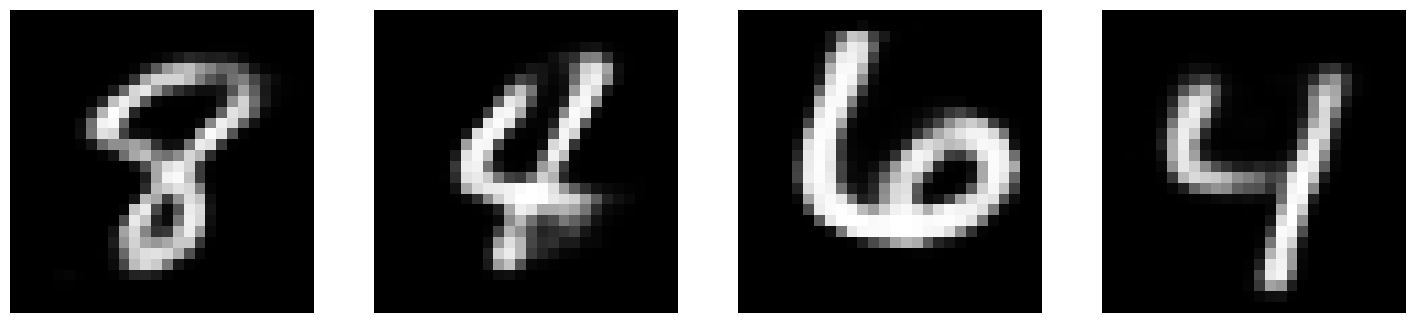

====> Epoch: 28 Average loss: 66.2656
====> Test set loss: 57.3052


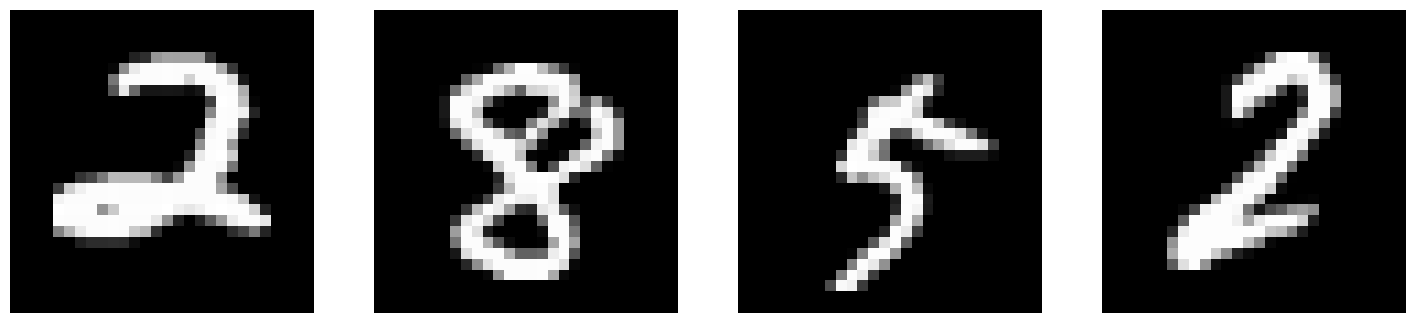

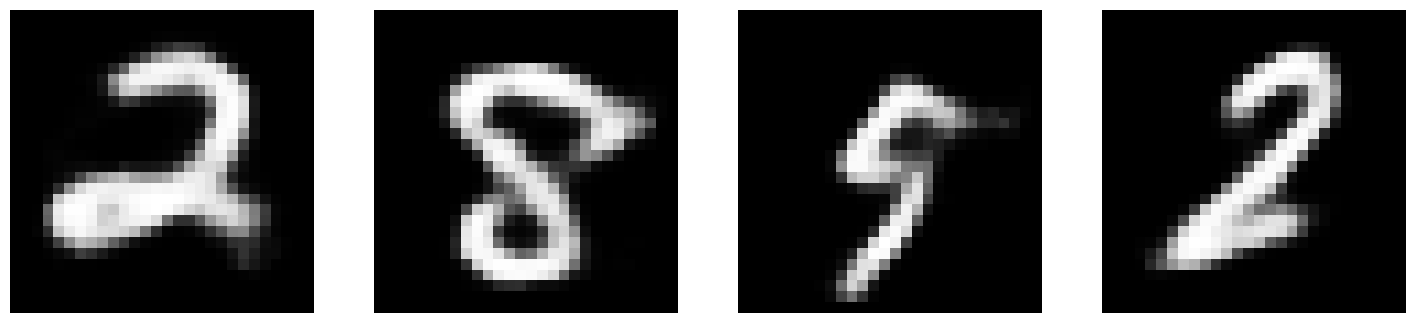

====> Epoch: 29 Average loss: 66.0825
====> Test set loss: 56.6014


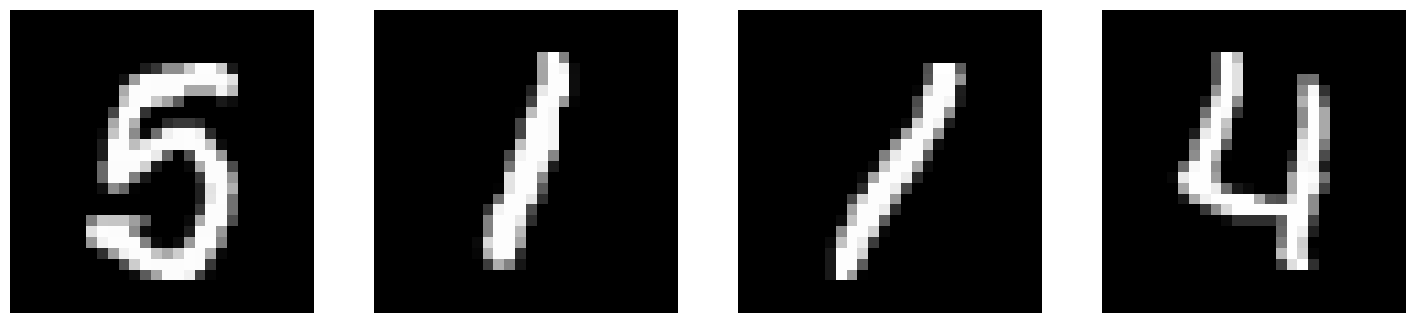

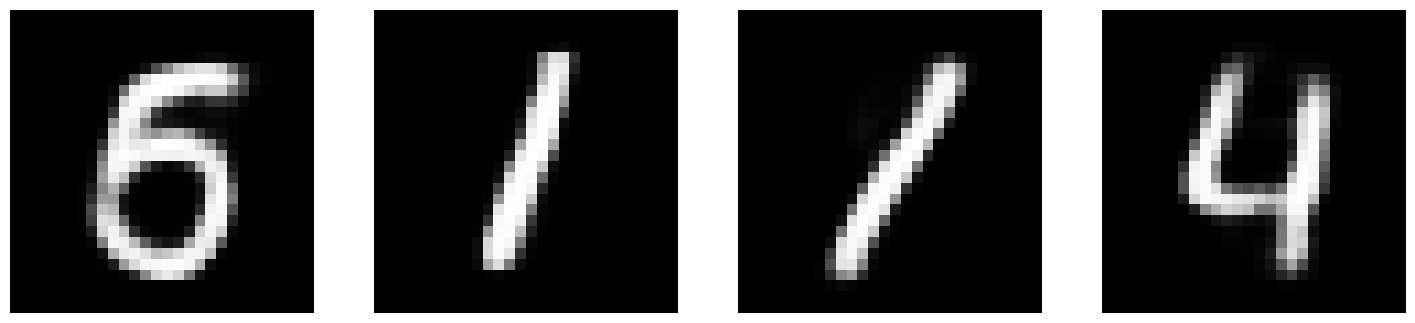

====> Epoch: 30 Average loss: 65.9153
====> Test set loss: 56.4553


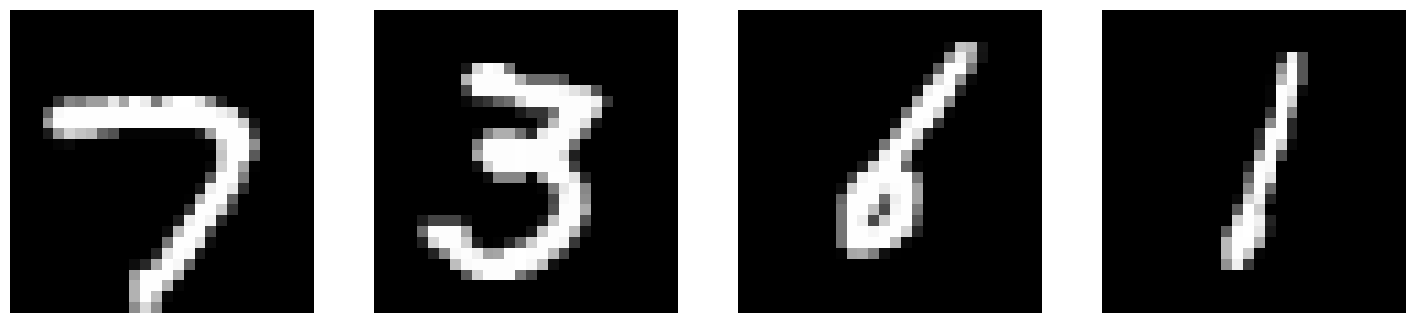

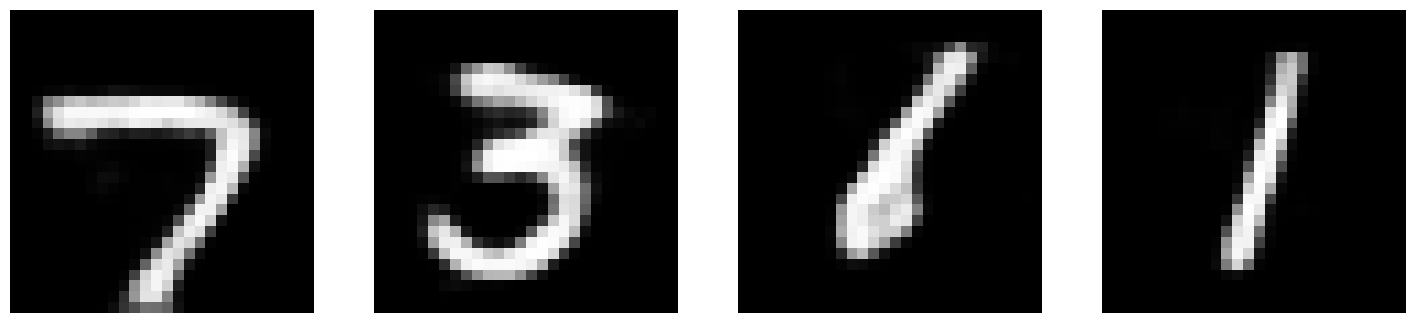

====> Epoch: 31 Average loss: 65.9057
====> Test set loss: 57.5747


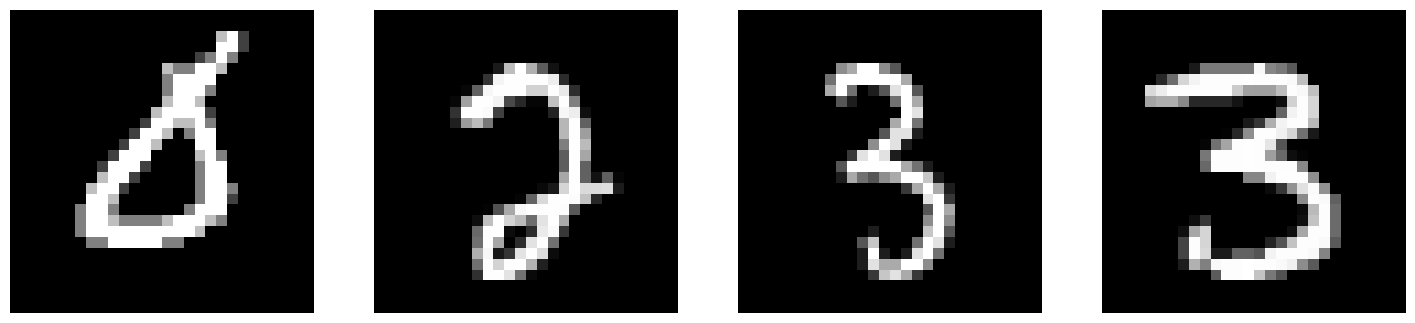

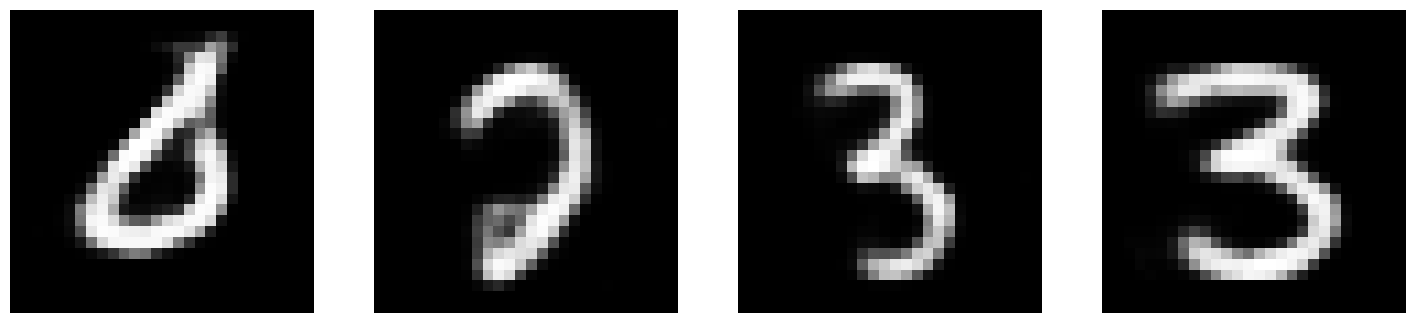

====> Epoch: 32 Average loss: 65.6941
====> Test set loss: 57.3763


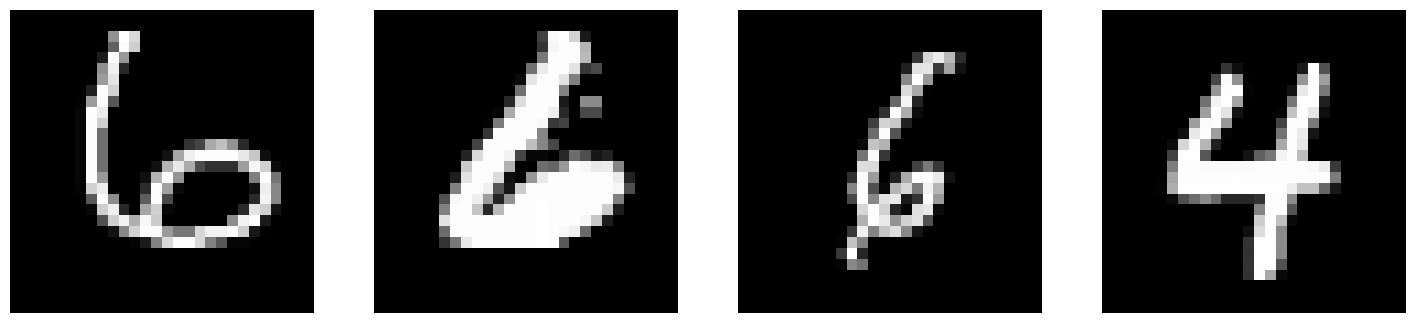

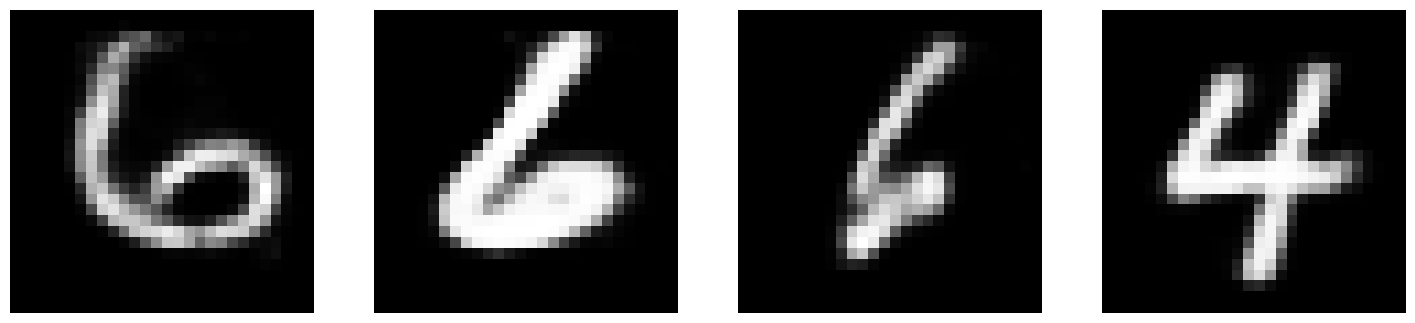

====> Epoch: 33 Average loss: 65.6248
====> Test set loss: 57.2402


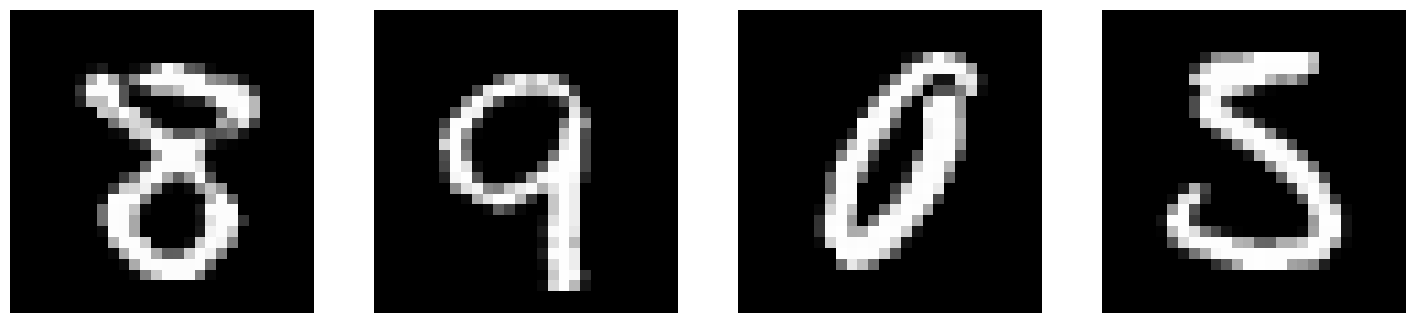

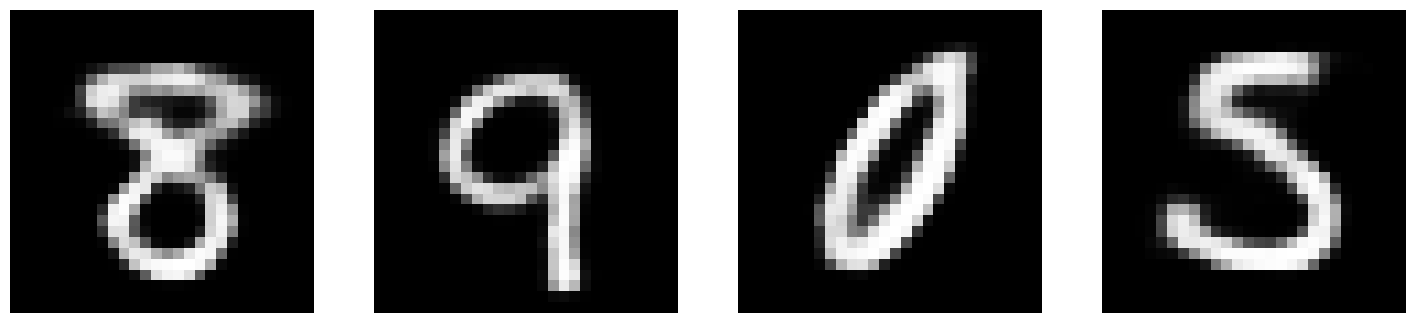

====> Epoch: 34 Average loss: 65.5257
====> Test set loss: 57.5094


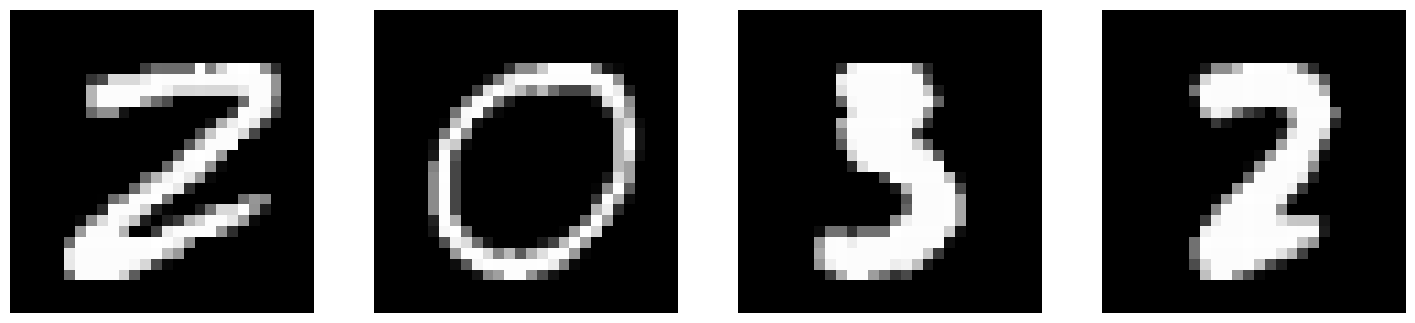

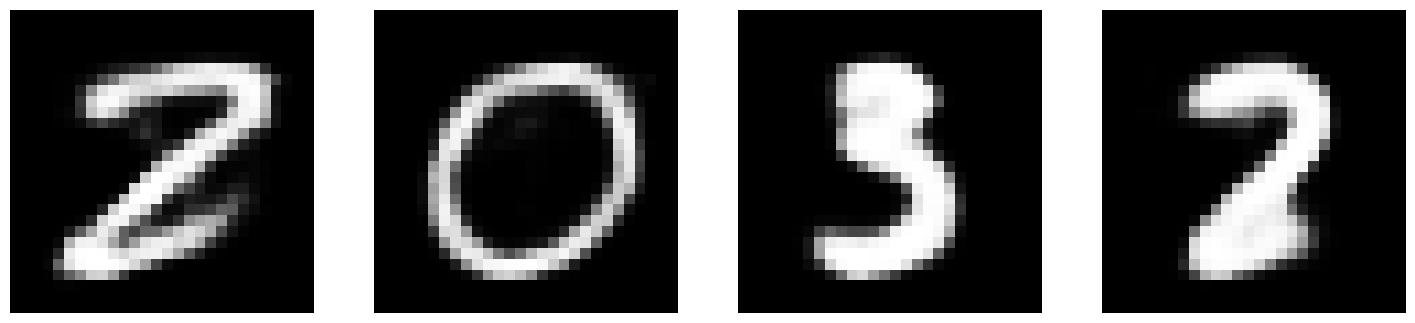

====> Epoch: 35 Average loss: 65.4277
====> Test set loss: 56.5747


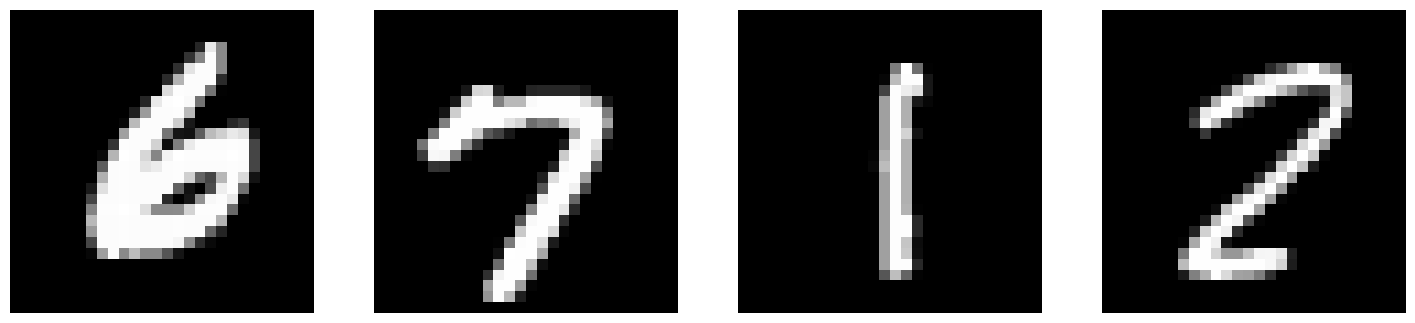

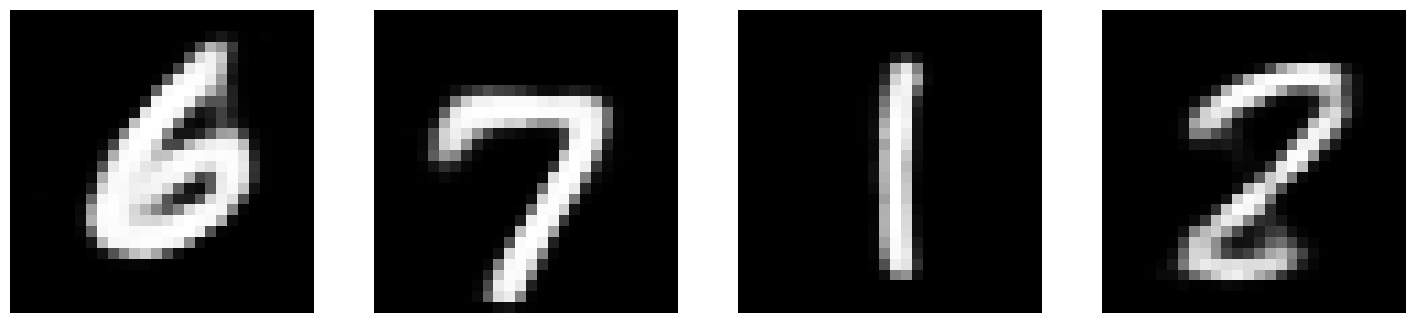

====> Epoch: 36 Average loss: 65.3185
====> Test set loss: 56.8612


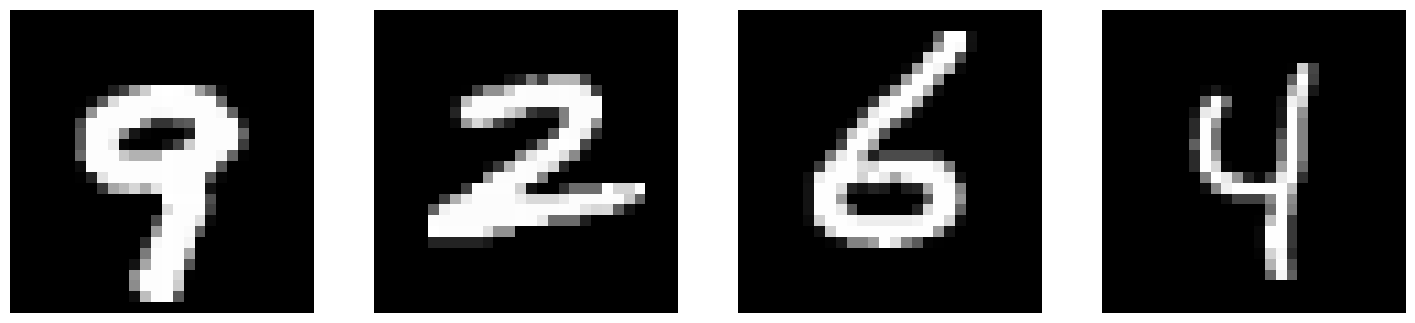

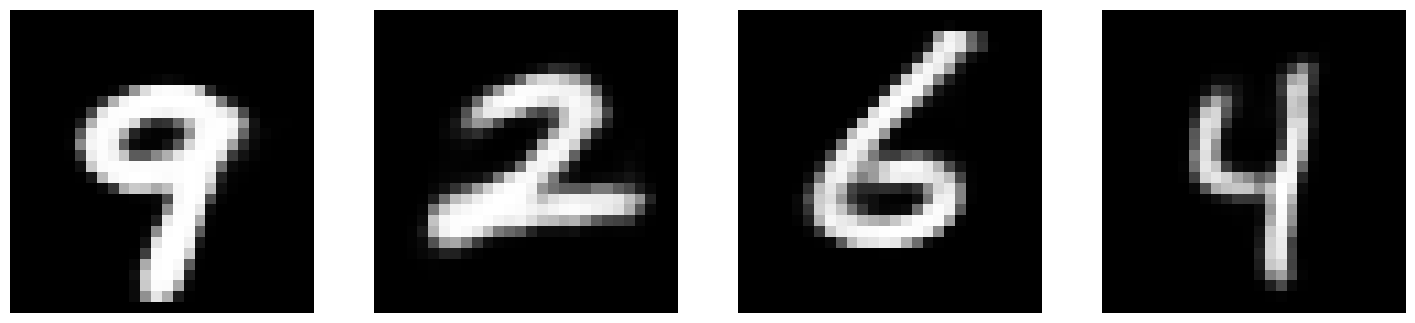

====> Epoch: 37 Average loss: 65.1957
====> Test set loss: 57.4571


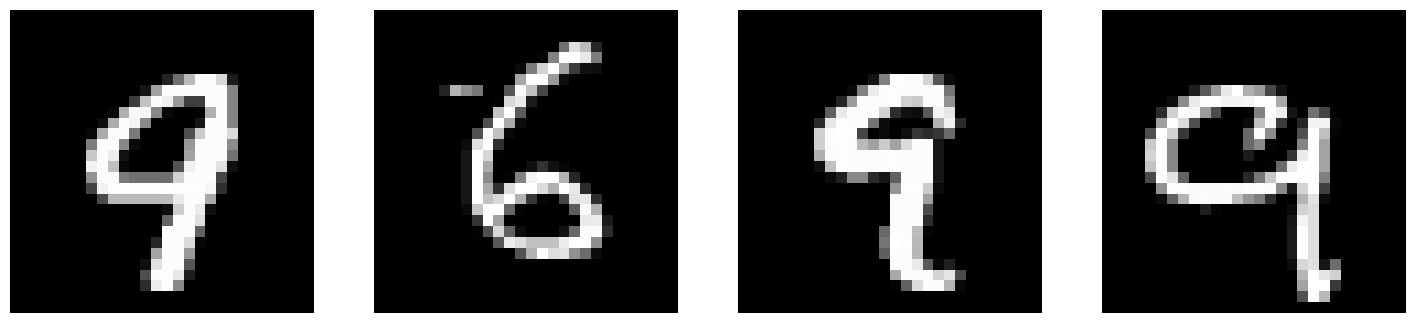

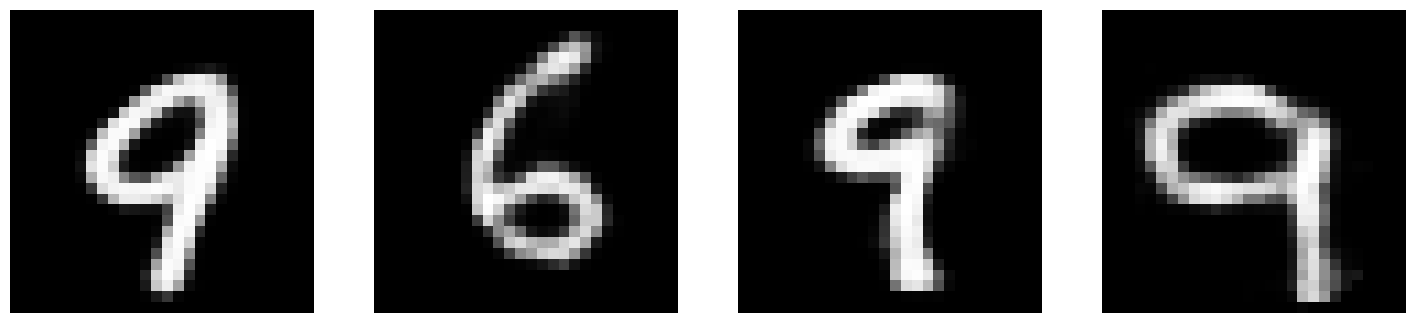

====> Epoch: 38 Average loss: 65.1824
====> Test set loss: 56.6653


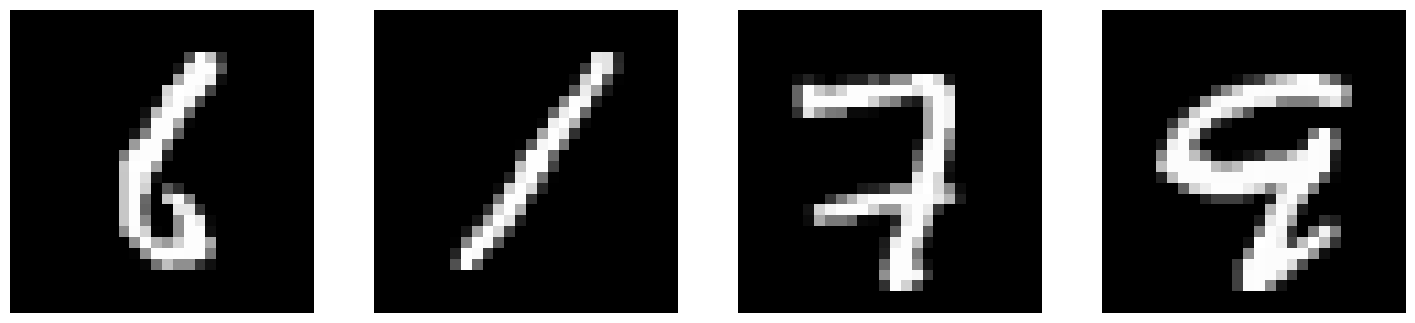

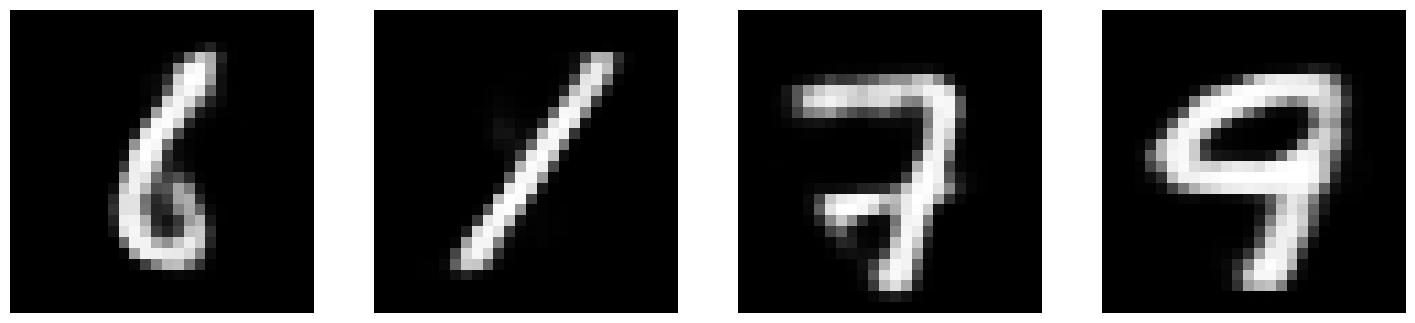

====> Epoch: 39 Average loss: 65.0467
====> Test set loss: 57.0958


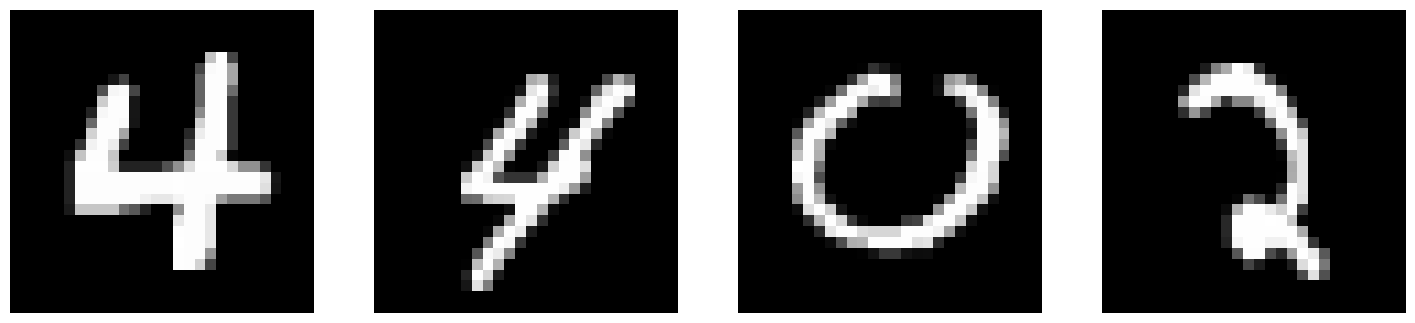

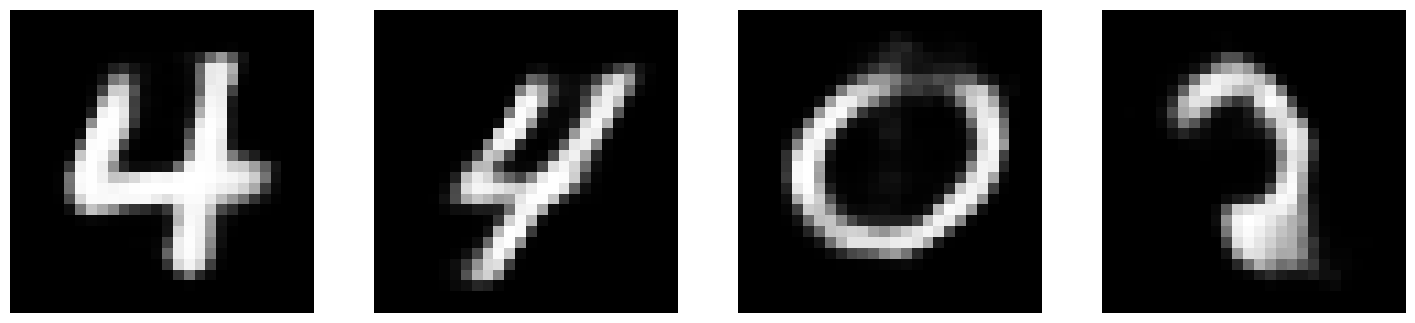

====> Epoch: 40 Average loss: 64.8653
====> Test set loss: 56.1375


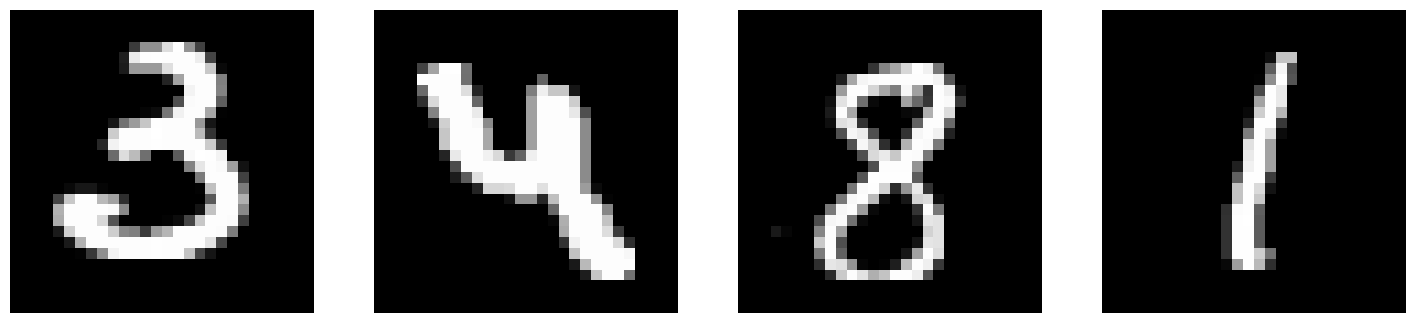

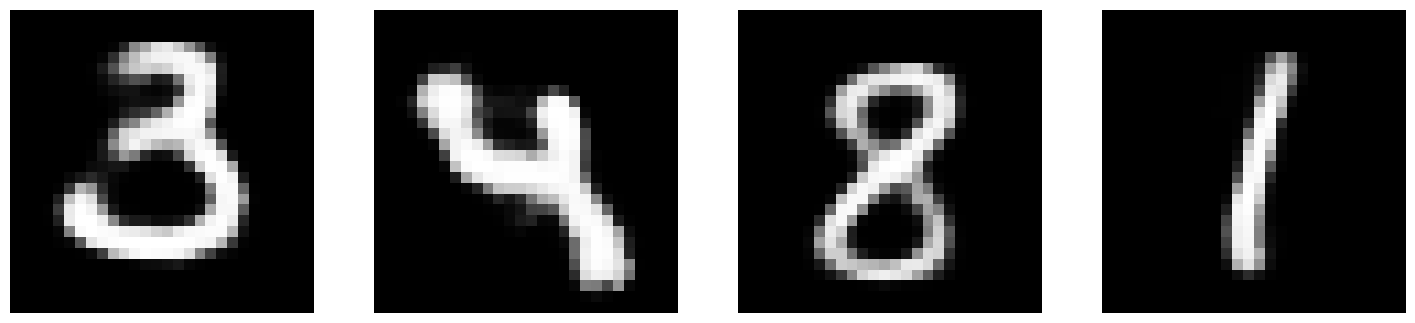

====> Epoch: 41 Average loss: 64.7999
====> Test set loss: 57.1102


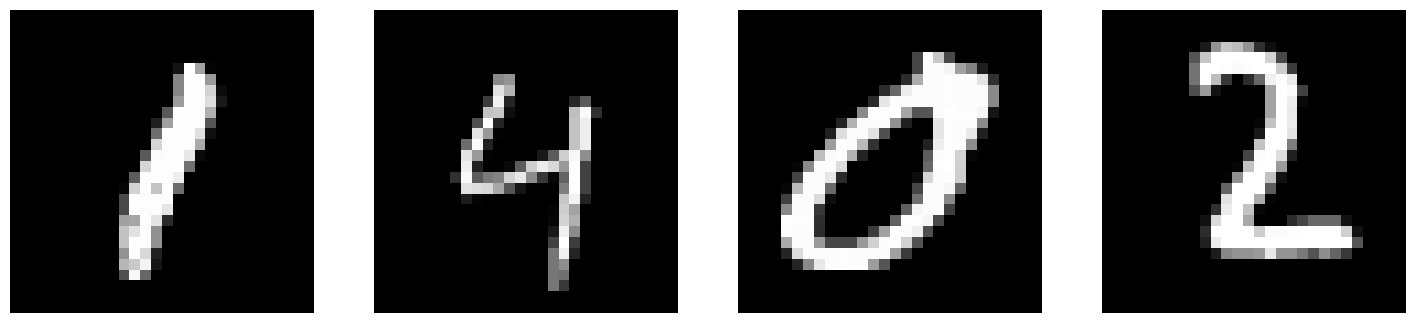

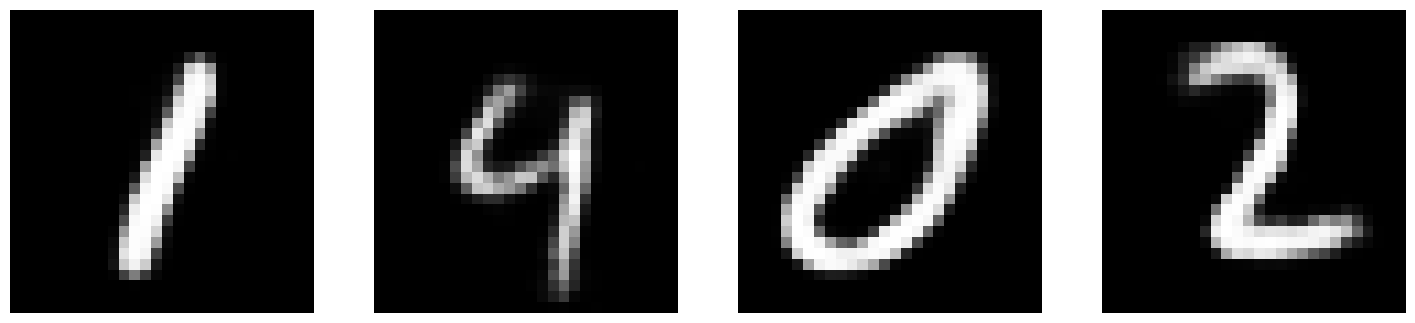

====> Epoch: 42 Average loss: 64.8111
====> Test set loss: 56.1809


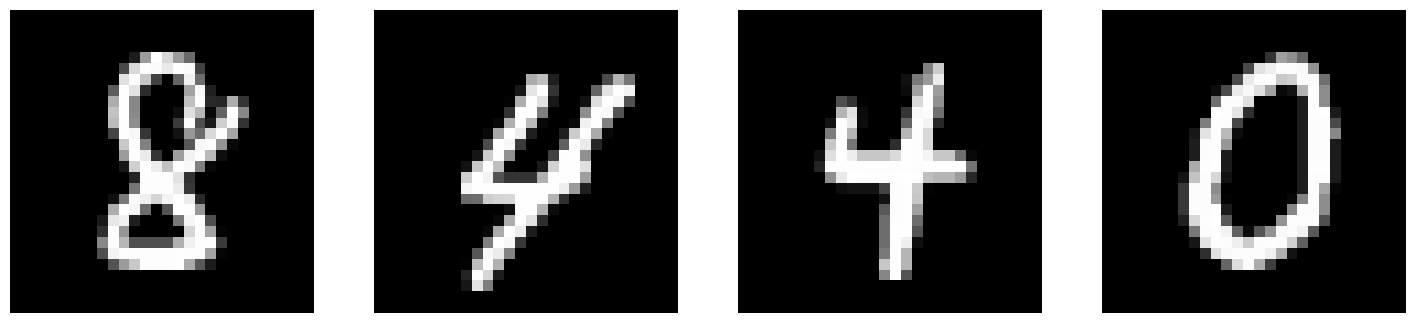

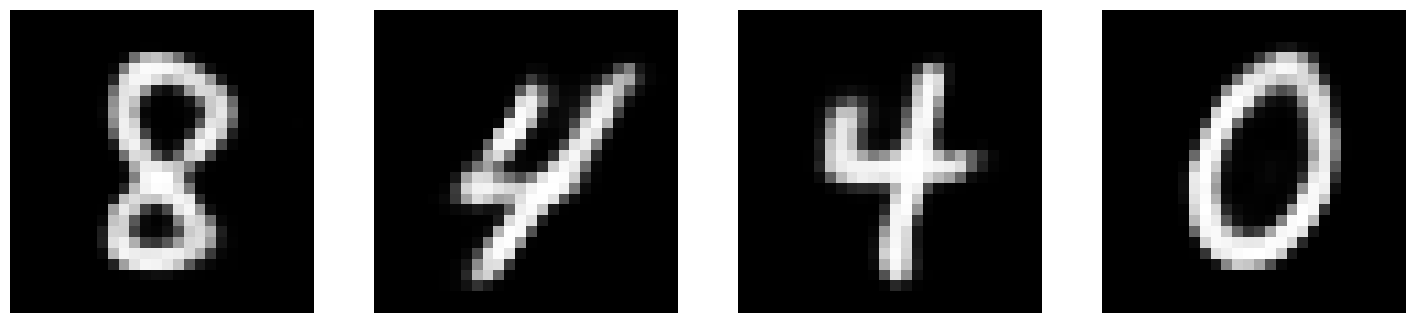

====> Epoch: 43 Average loss: 64.6505
====> Test set loss: 56.8680


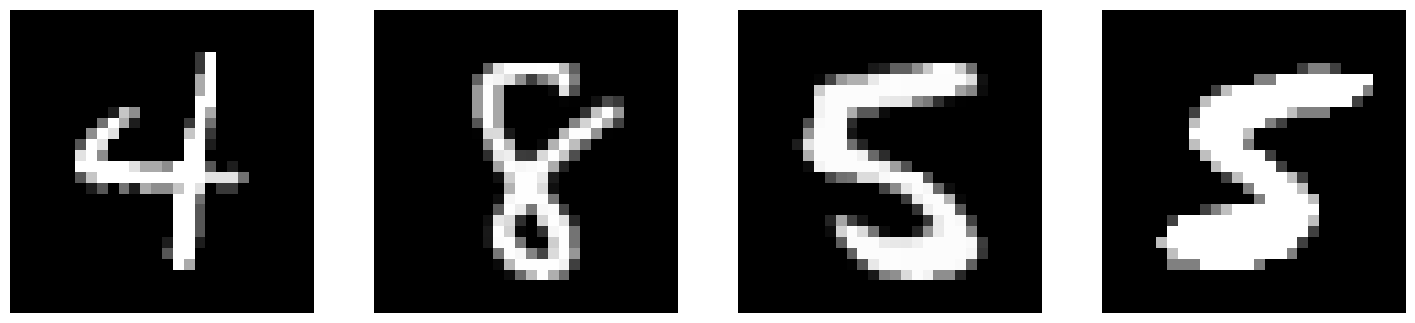

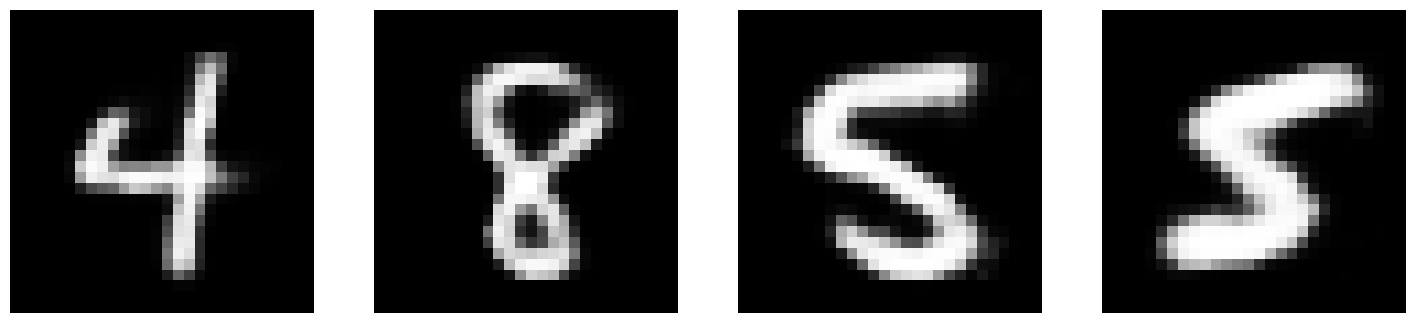

====> Epoch: 44 Average loss: 64.5428
====> Test set loss: 56.4664


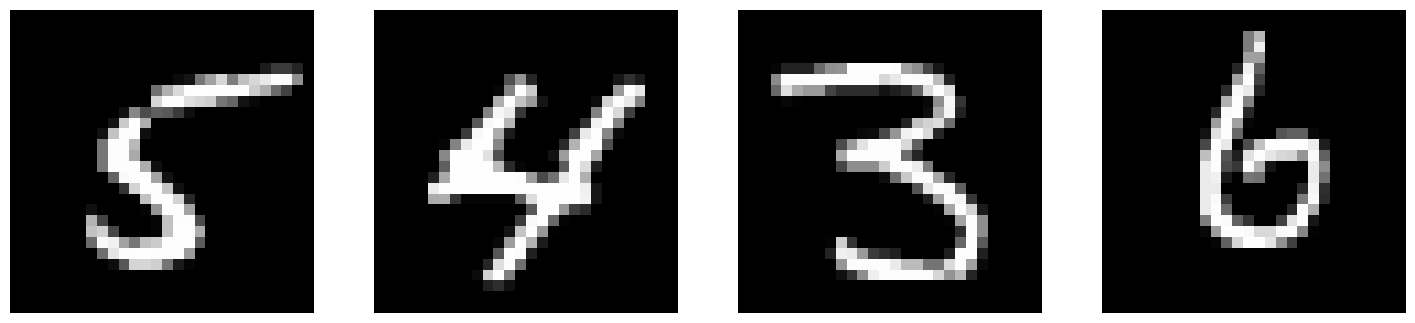

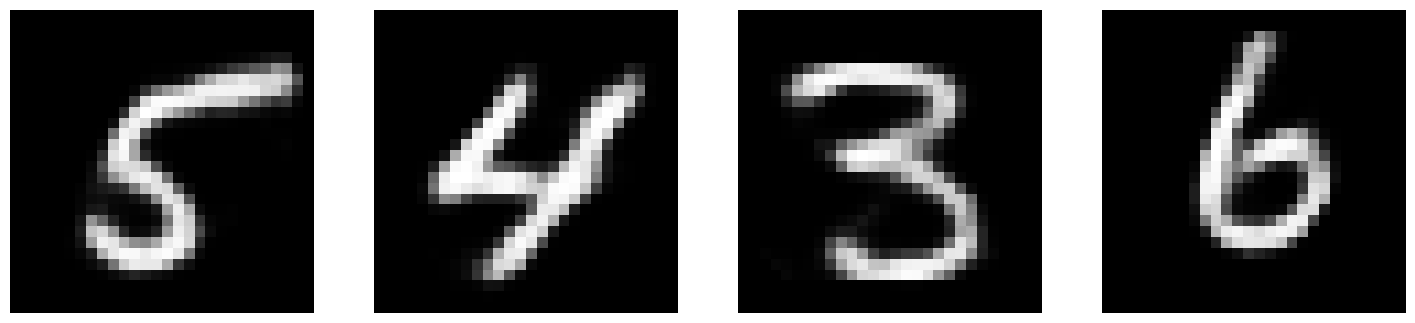

====> Epoch: 45 Average loss: 64.5442
====> Test set loss: 56.0221


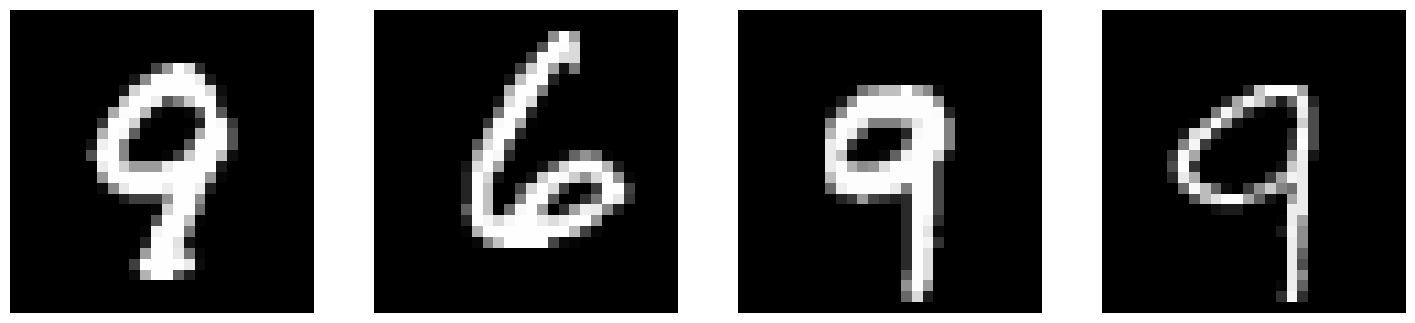

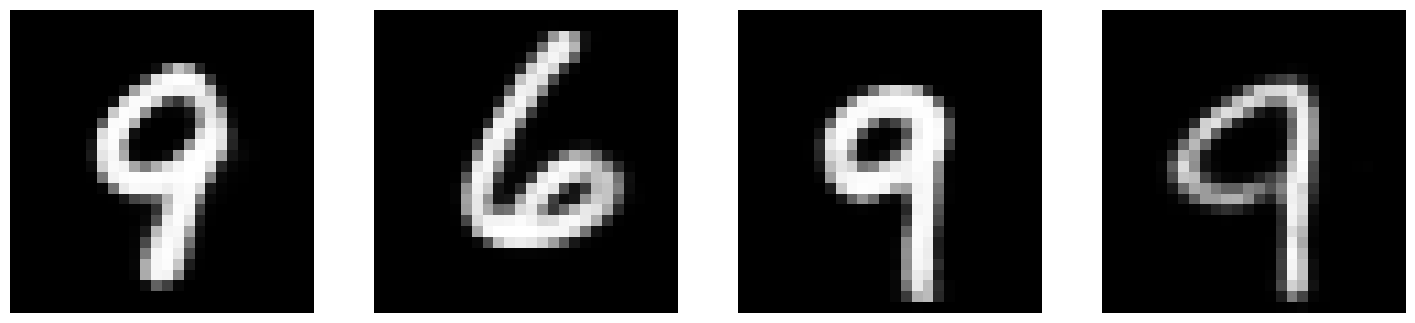

====> Epoch: 46 Average loss: 64.4549
====> Test set loss: 55.6368


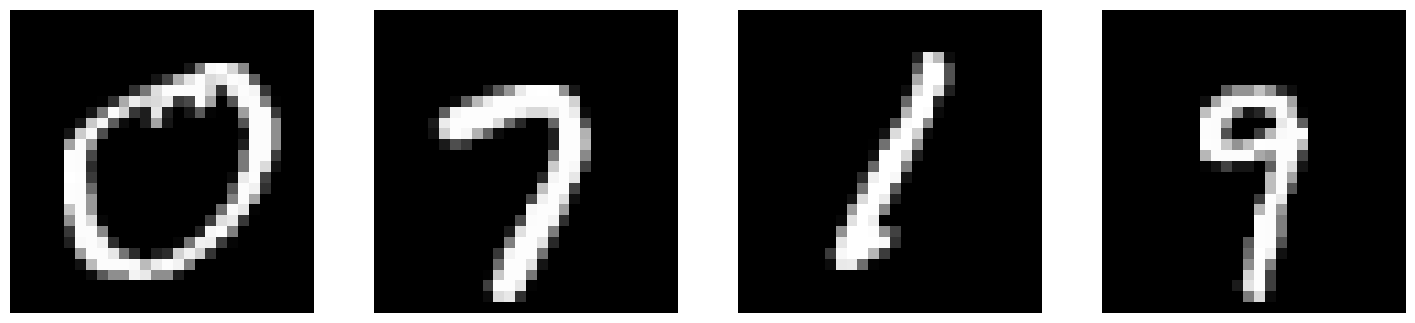

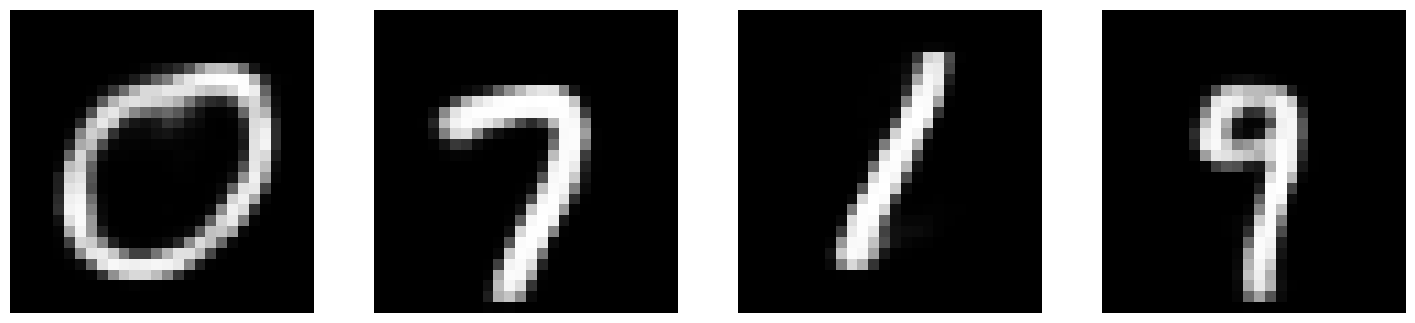

====> Epoch: 47 Average loss: 64.3589
====> Test set loss: 55.7268


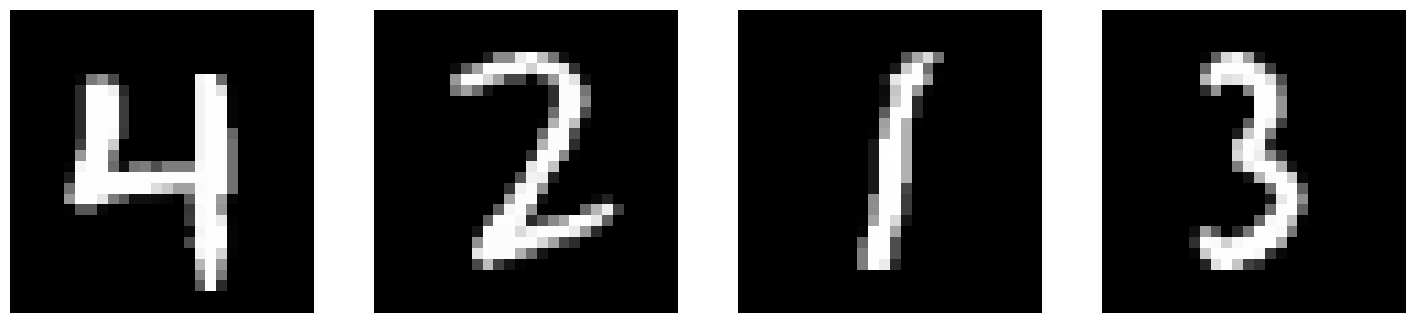

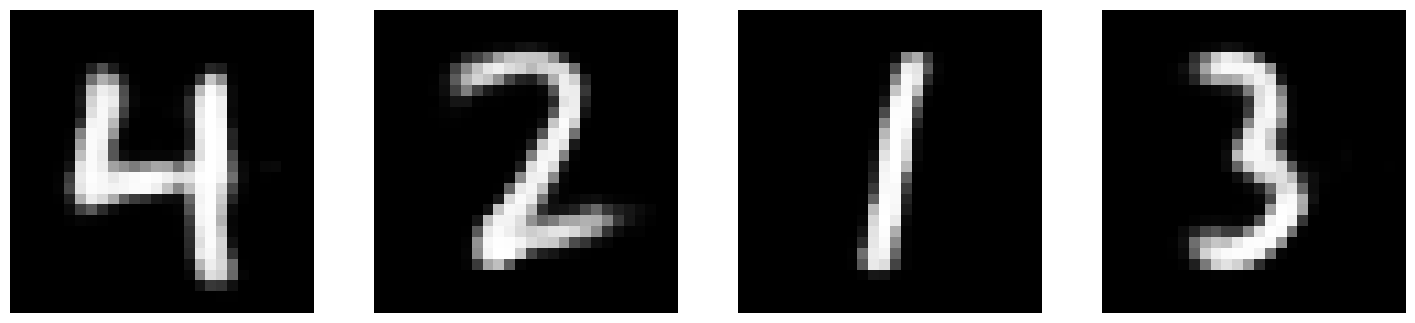

====> Epoch: 48 Average loss: 64.3730
====> Test set loss: 55.1990


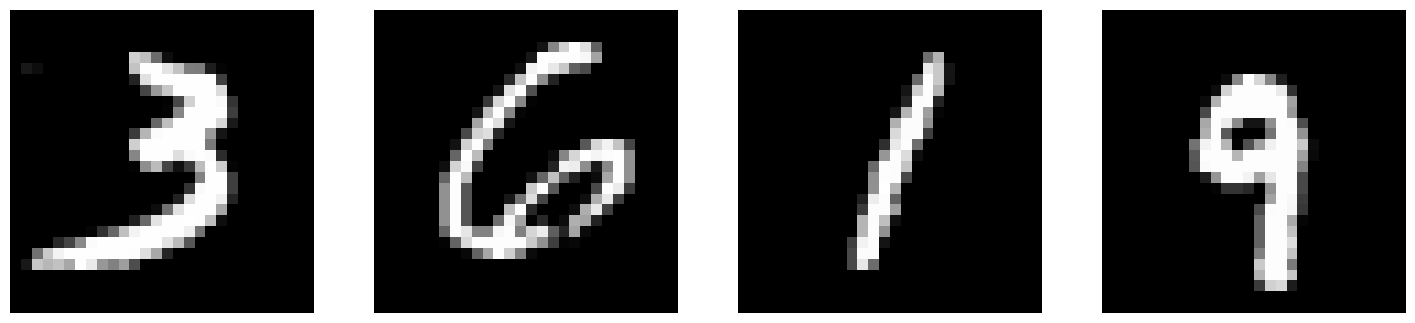

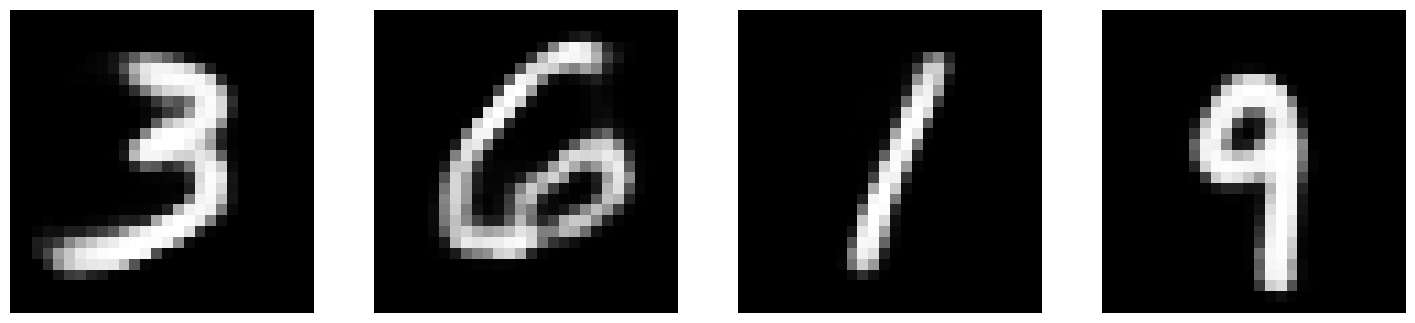

====> Epoch: 49 Average loss: 64.2267
====> Test set loss: 56.0060


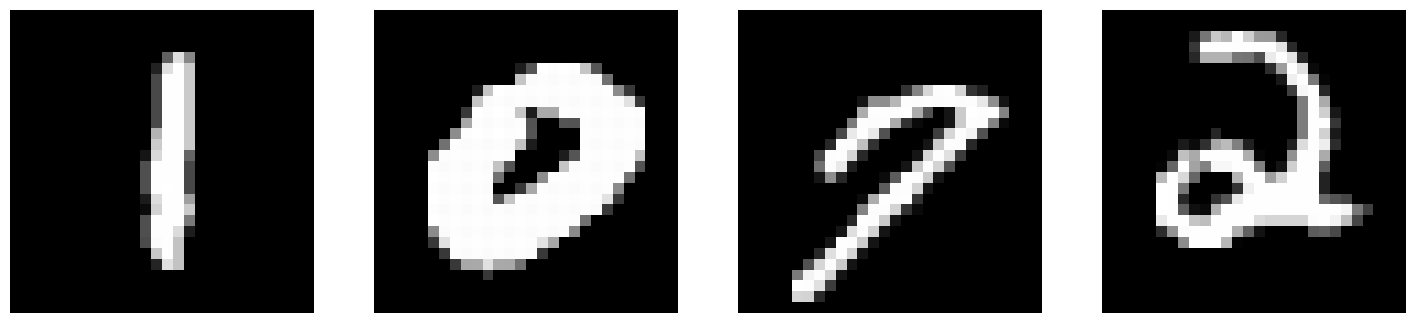

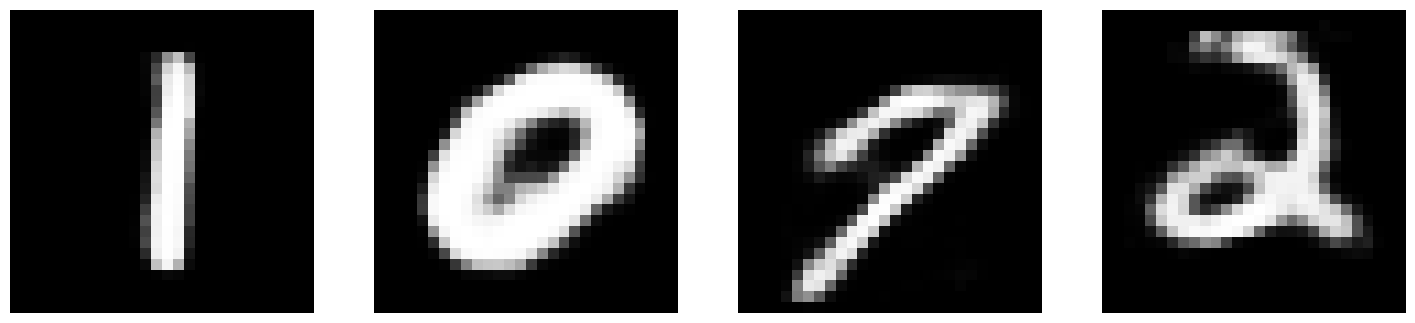

====> Epoch: 50 Average loss: 64.1230
====> Test set loss: 55.7678


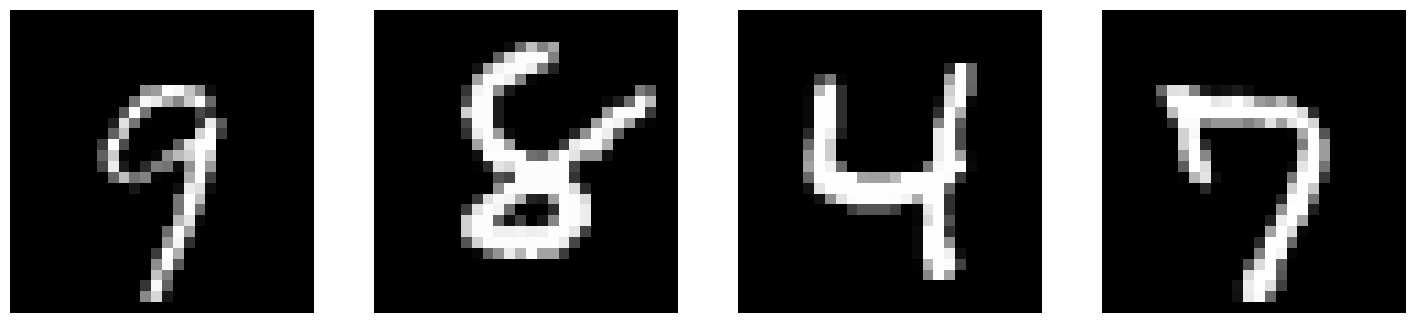

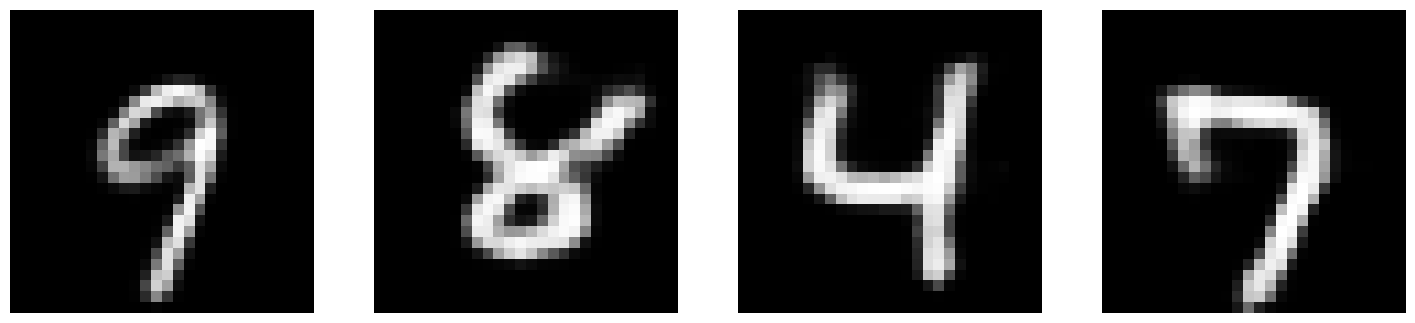

====> Epoch: 51 Average loss: 64.0799
====> Test set loss: 56.1666


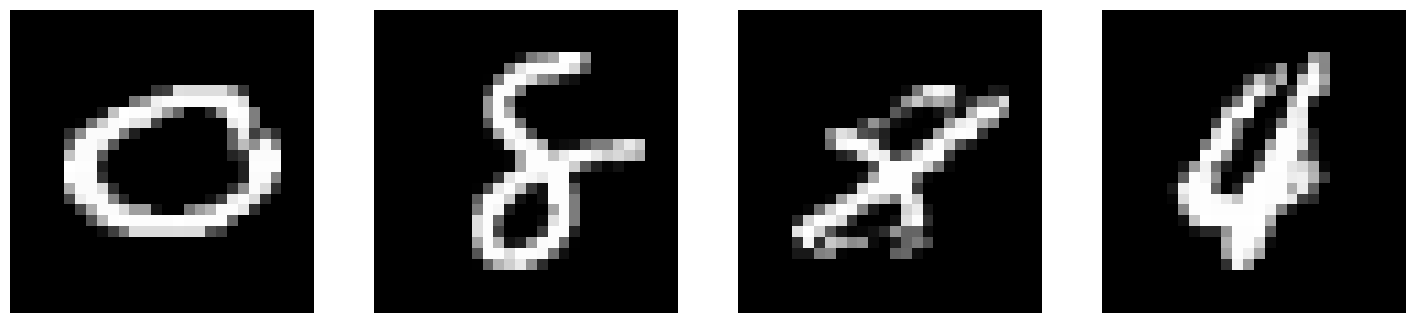

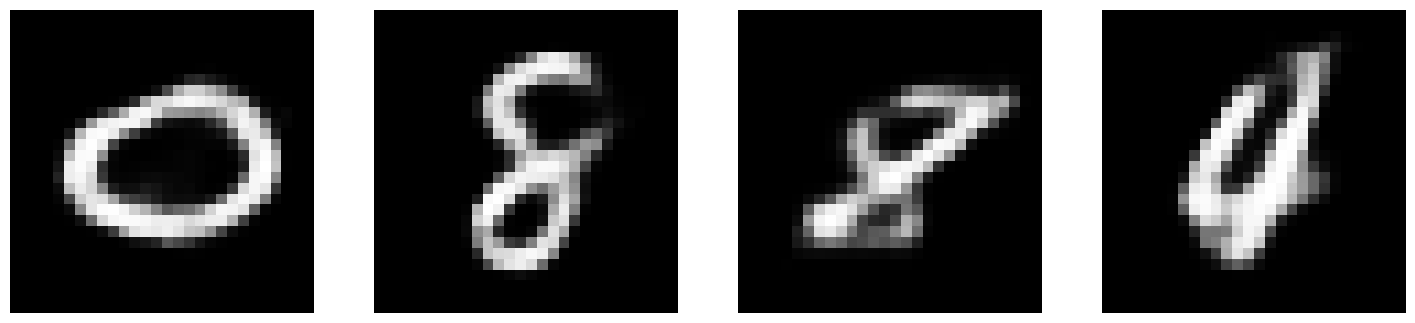

====> Epoch: 52 Average loss: 64.1075
====> Test set loss: 55.9404


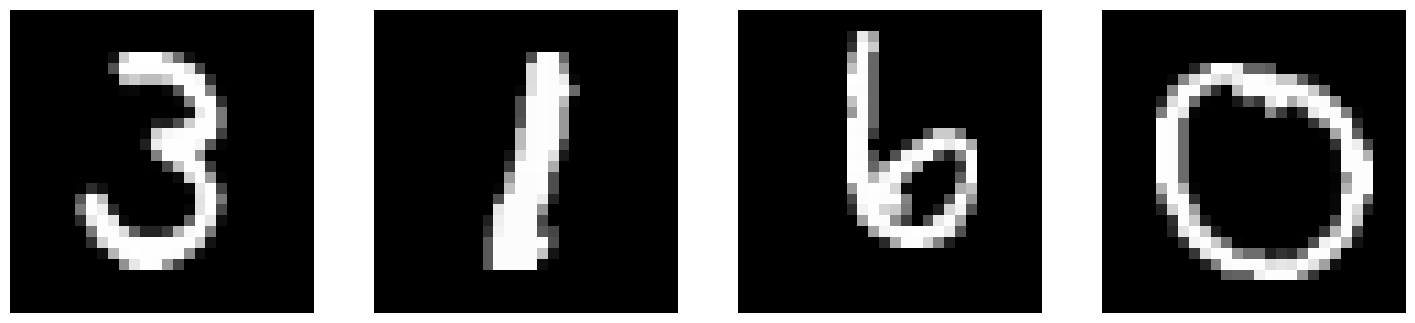

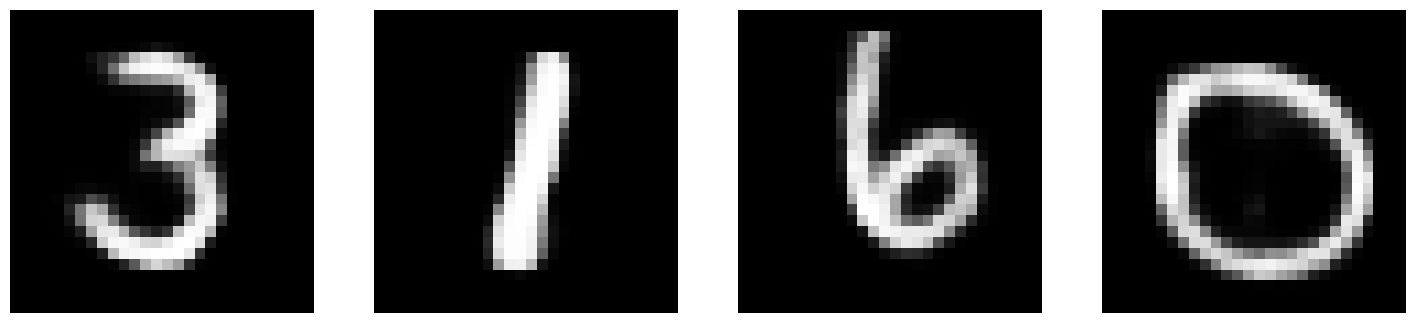

====> Epoch: 53 Average loss: 63.9749
====> Test set loss: 56.0966


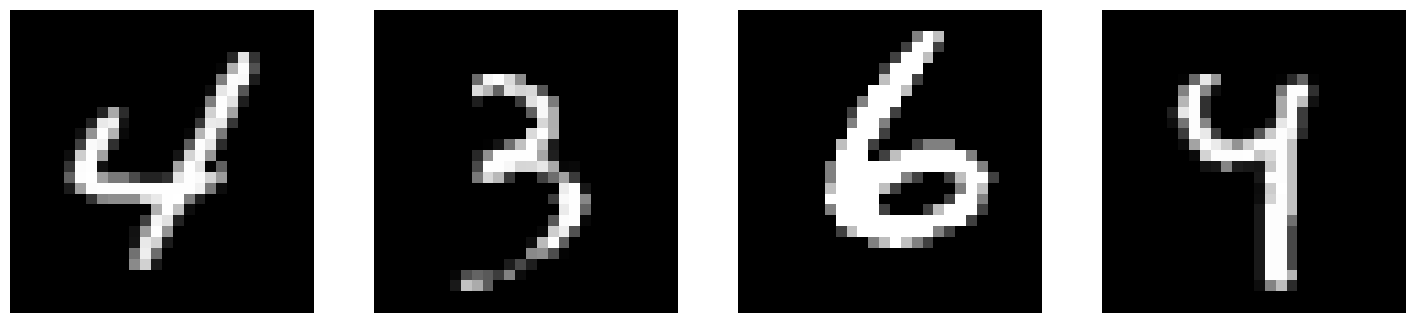

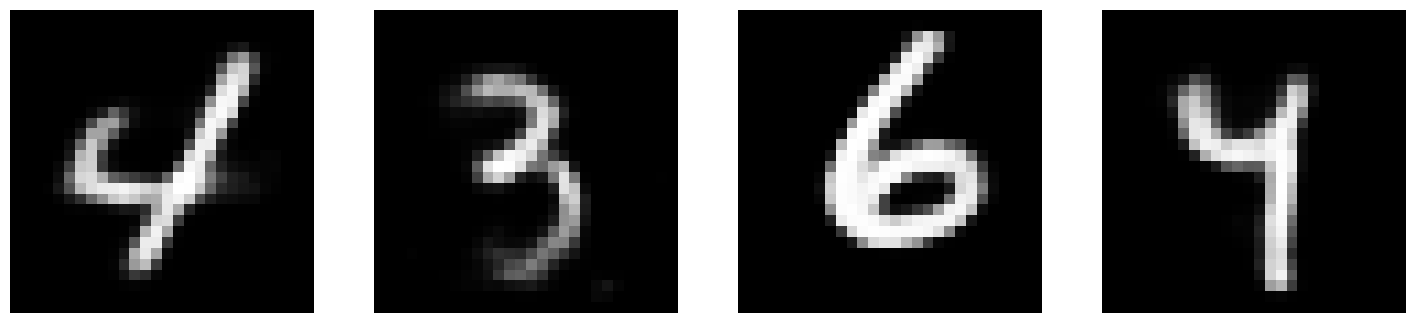

====> Epoch: 54 Average loss: 63.8915
====> Test set loss: 56.3613


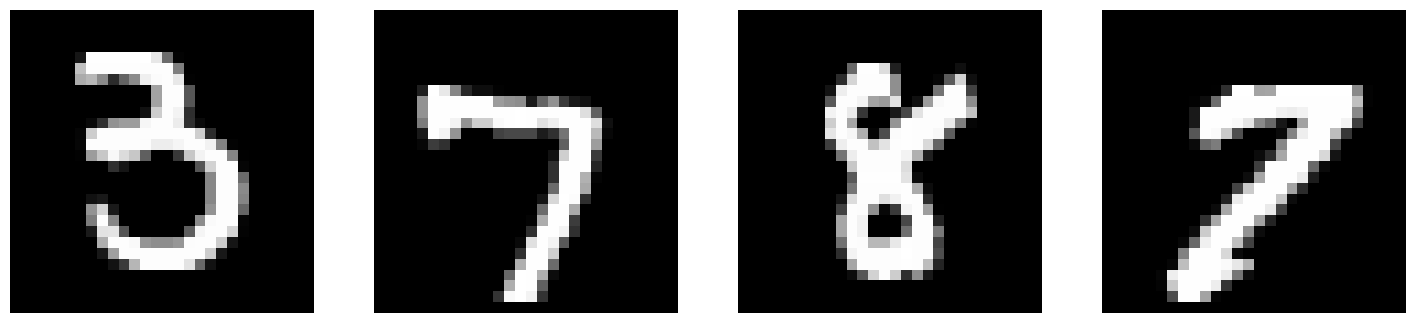

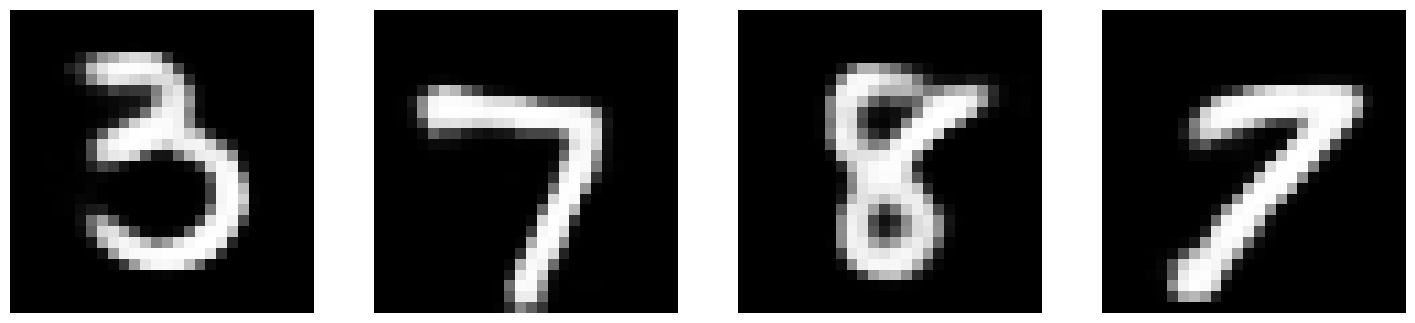

====> Epoch: 55 Average loss: 63.8729
====> Test set loss: 55.5155


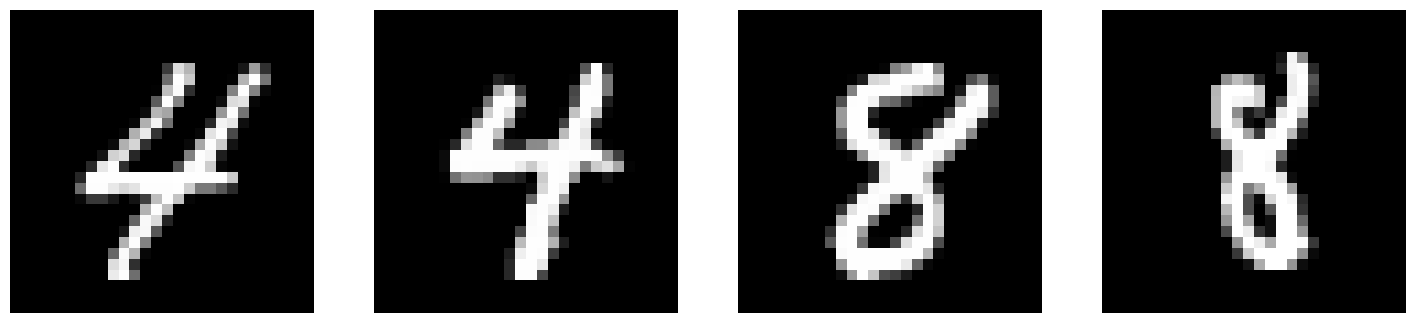

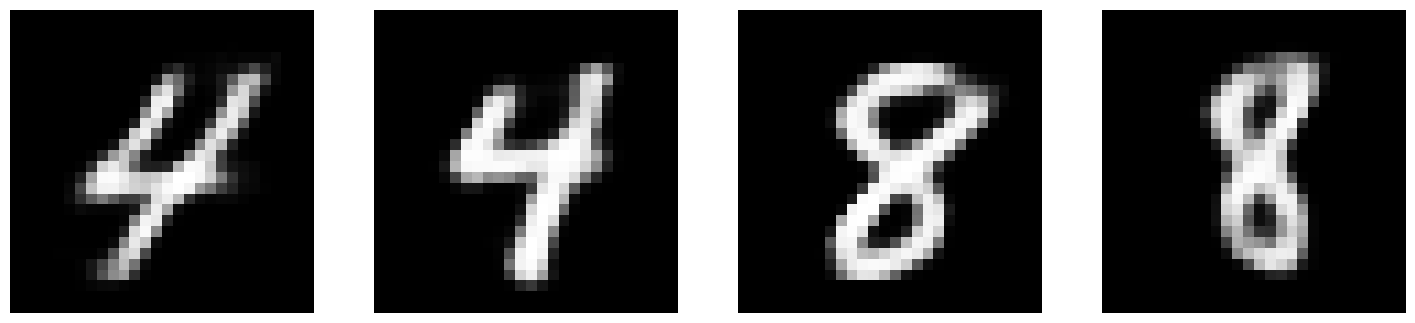

====> Epoch: 56 Average loss: 63.8271
====> Test set loss: 56.2358


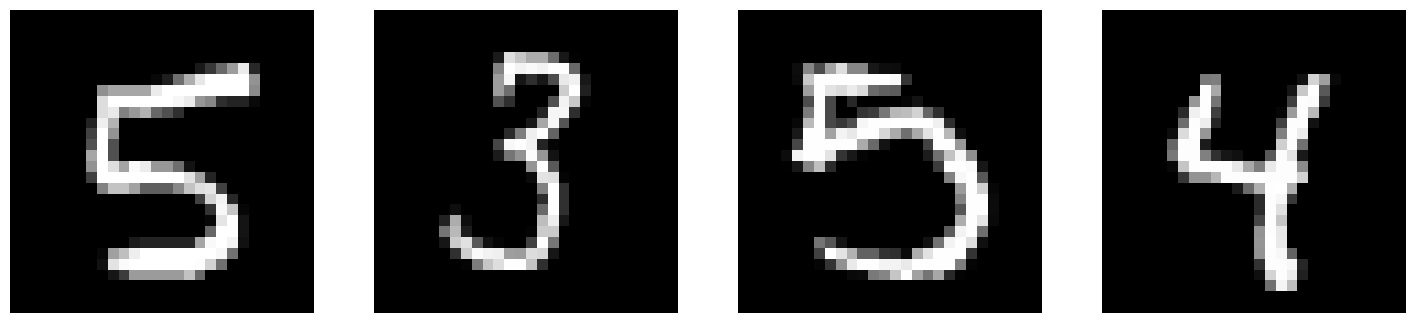

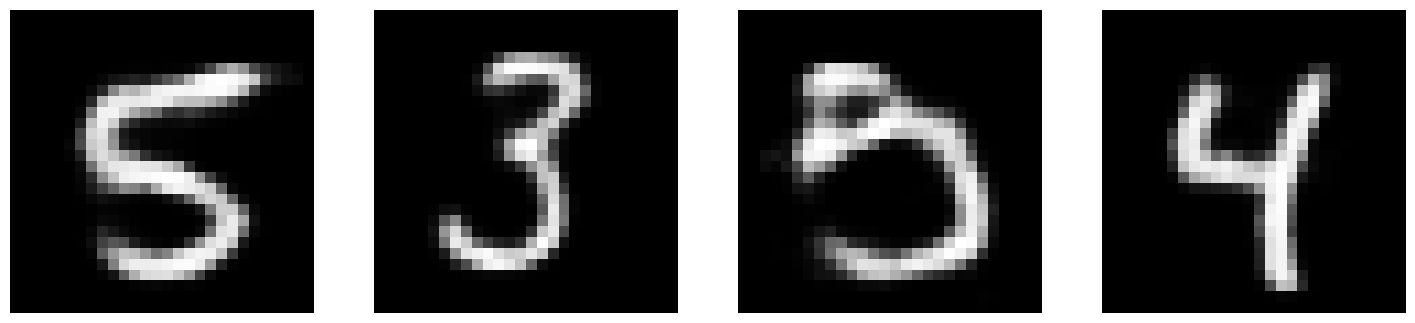

====> Epoch: 57 Average loss: 63.6996
====> Test set loss: 55.4829


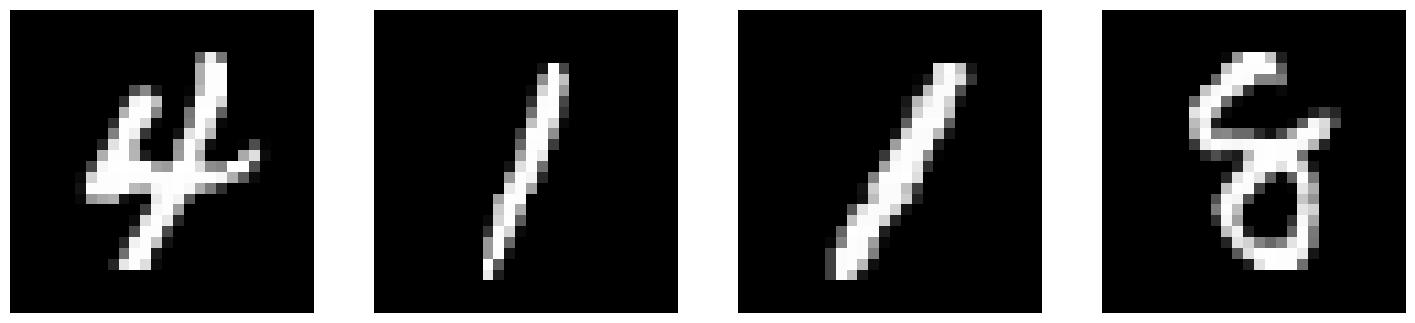

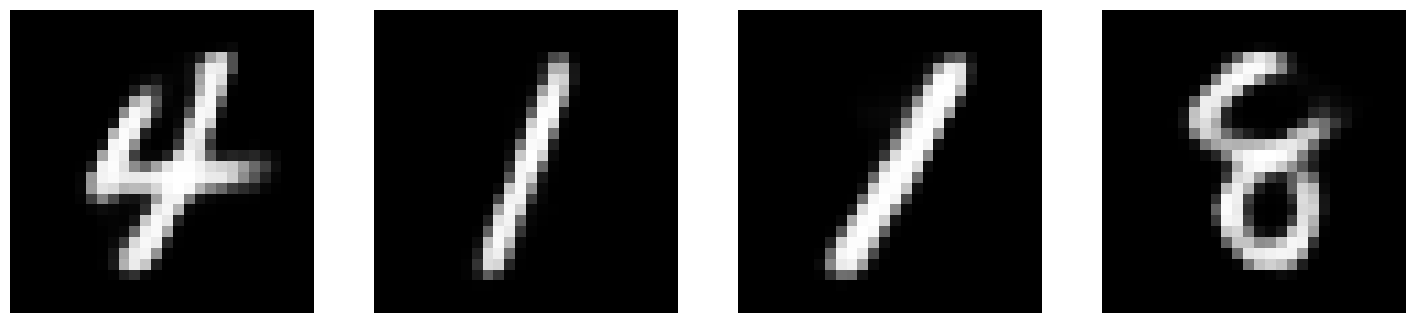

====> Epoch: 58 Average loss: 63.6826
====> Test set loss: 56.0164


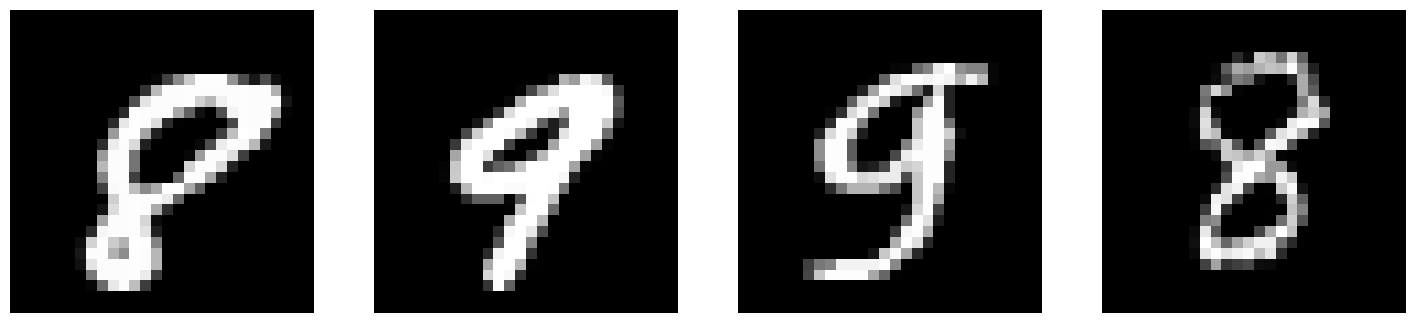

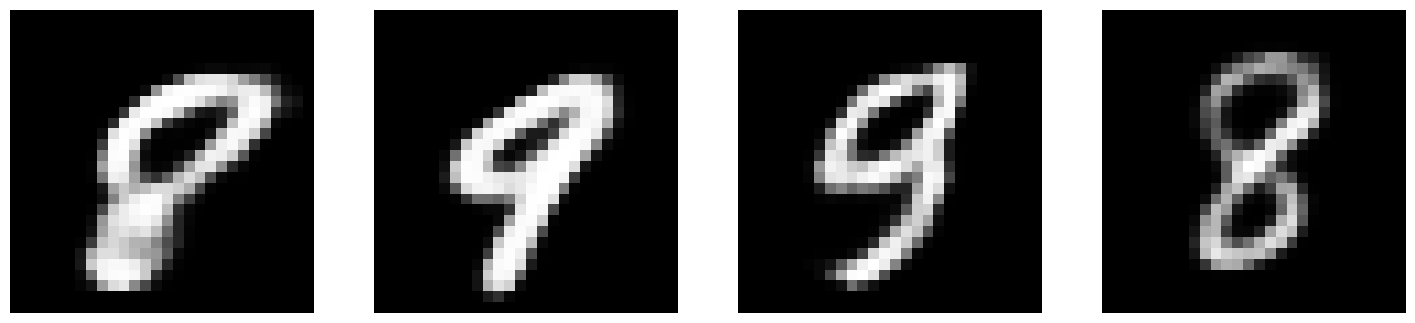

====> Epoch: 59 Average loss: 63.6581
====> Test set loss: 54.9062


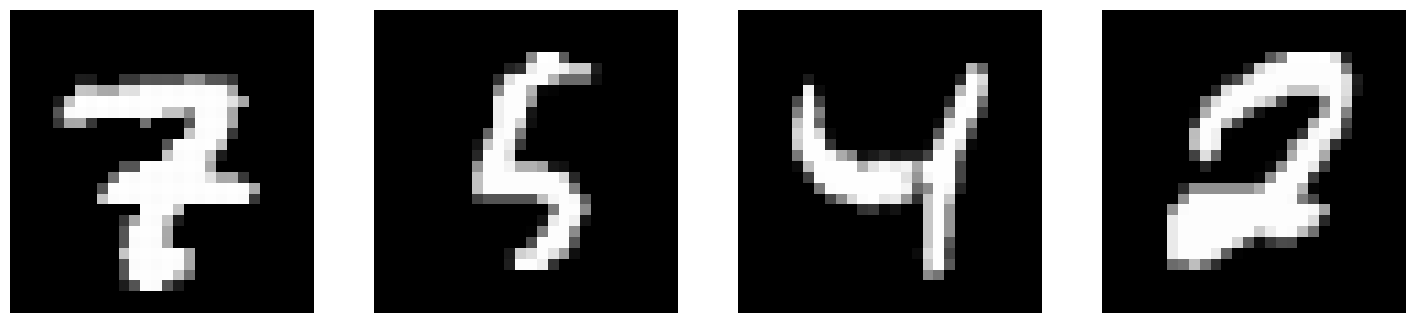

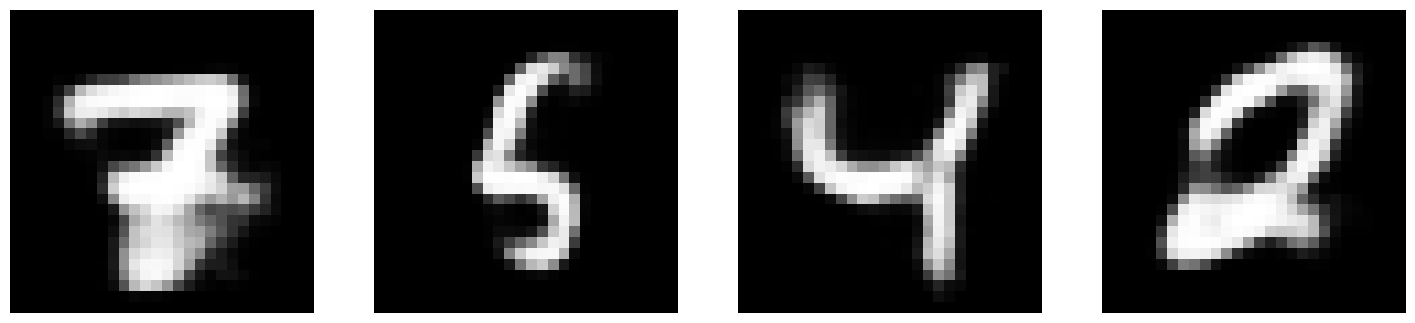

====> Epoch: 60 Average loss: 63.5050
====> Test set loss: 54.9886


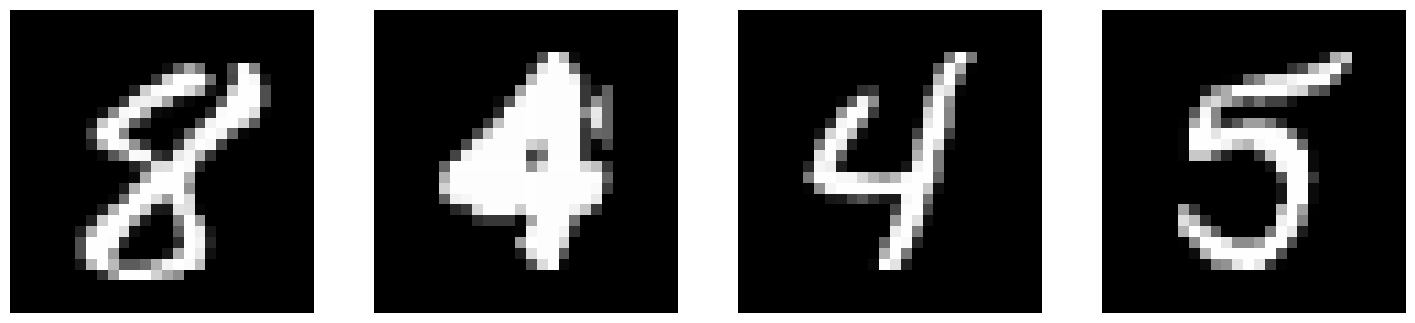

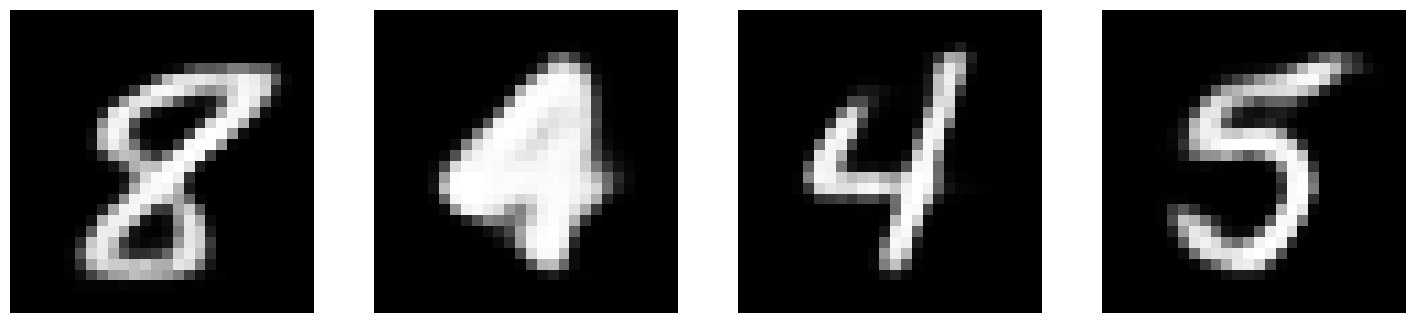

====> Epoch: 61 Average loss: 63.5459
====> Test set loss: 55.3861


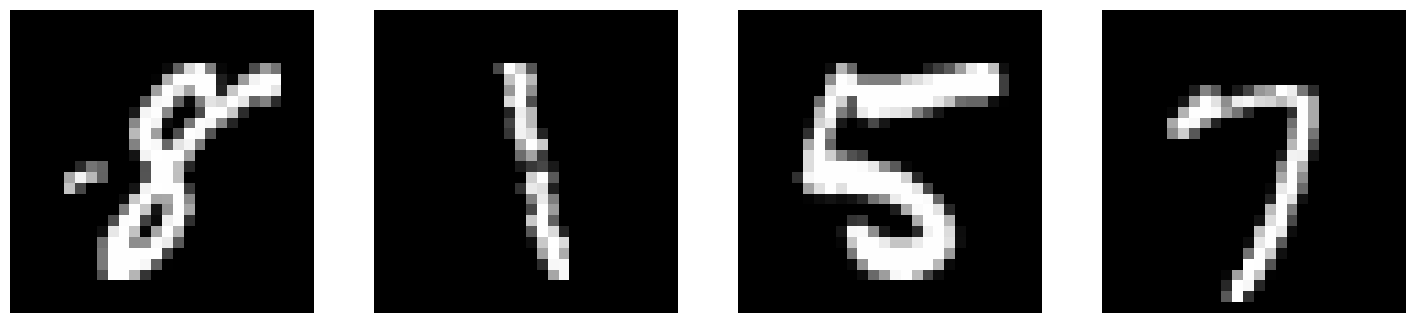

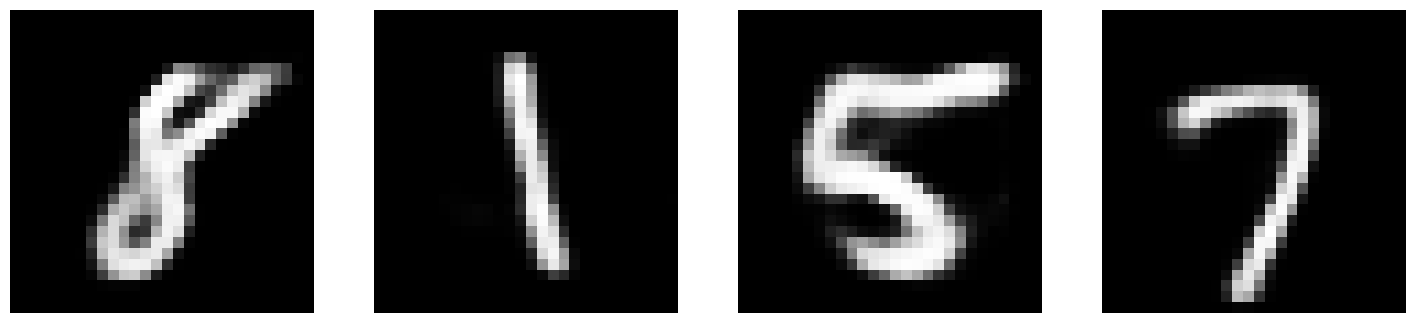

====> Epoch: 62 Average loss: 63.4831
====> Test set loss: 55.9588


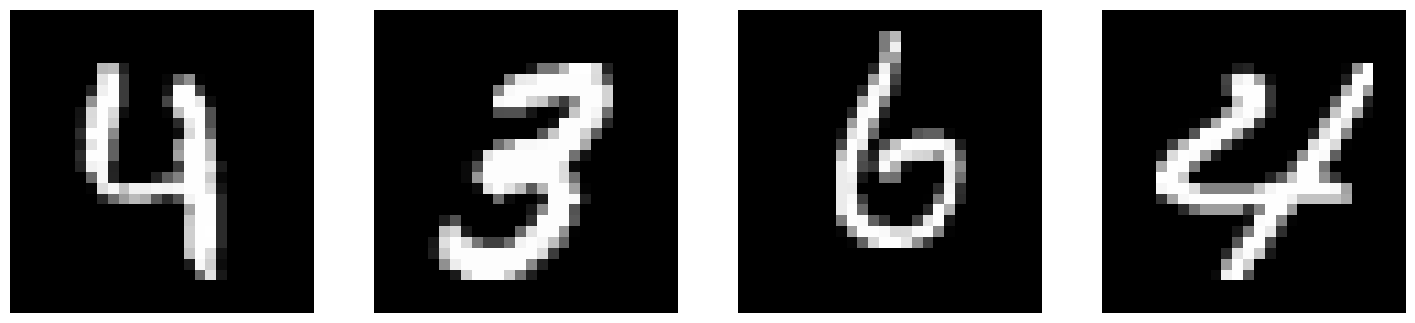

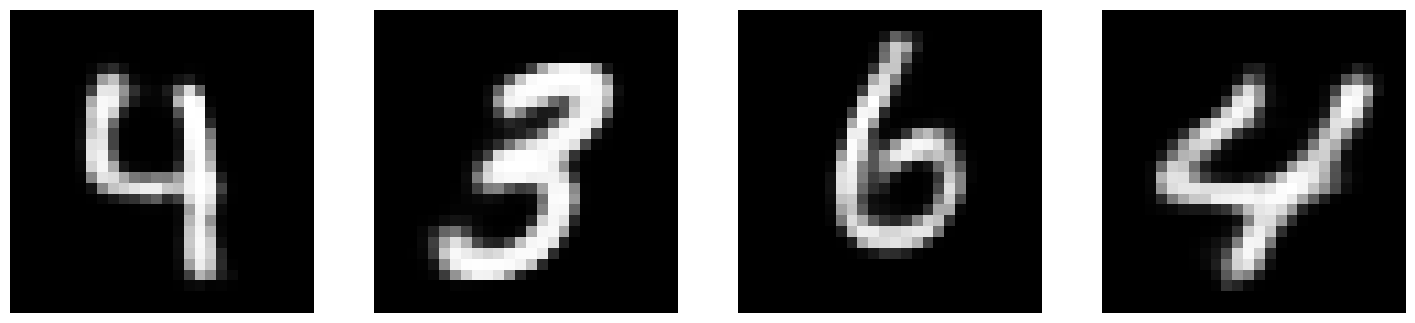

====> Epoch: 63 Average loss: 63.3834
====> Test set loss: 55.0245


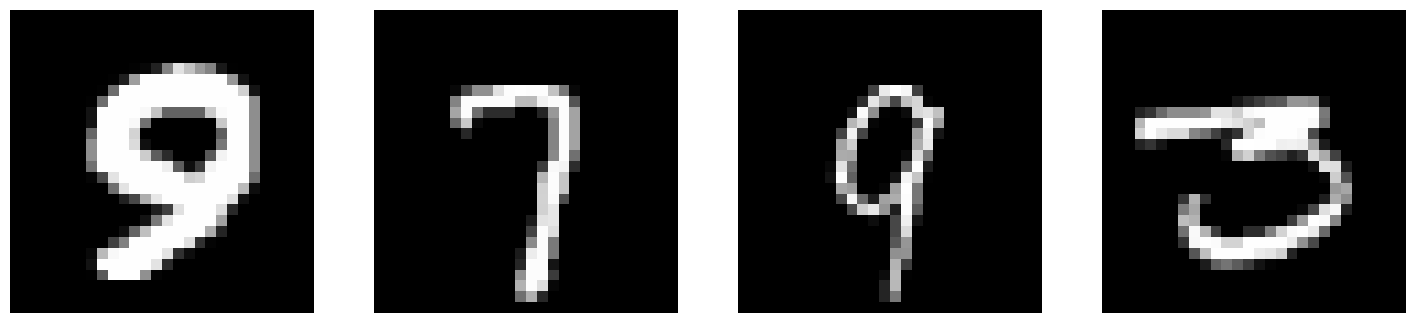

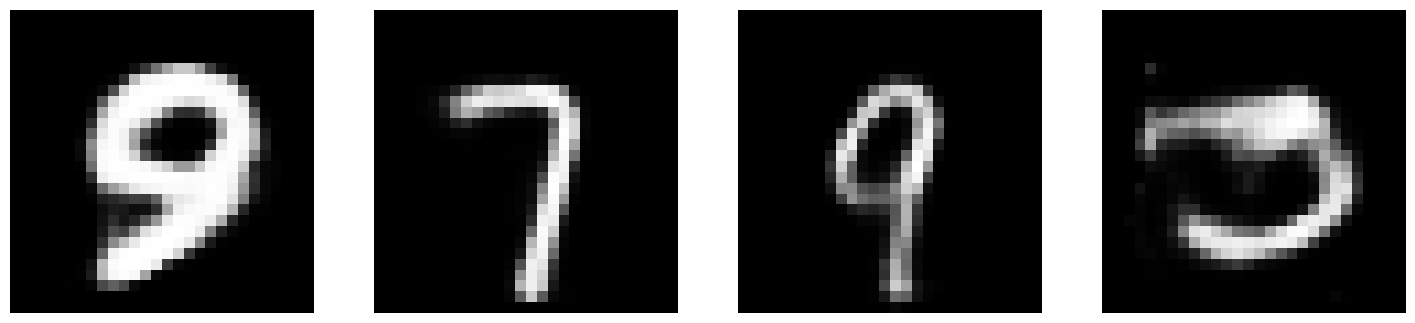

====> Epoch: 64 Average loss: 63.4006
====> Test set loss: 54.6016


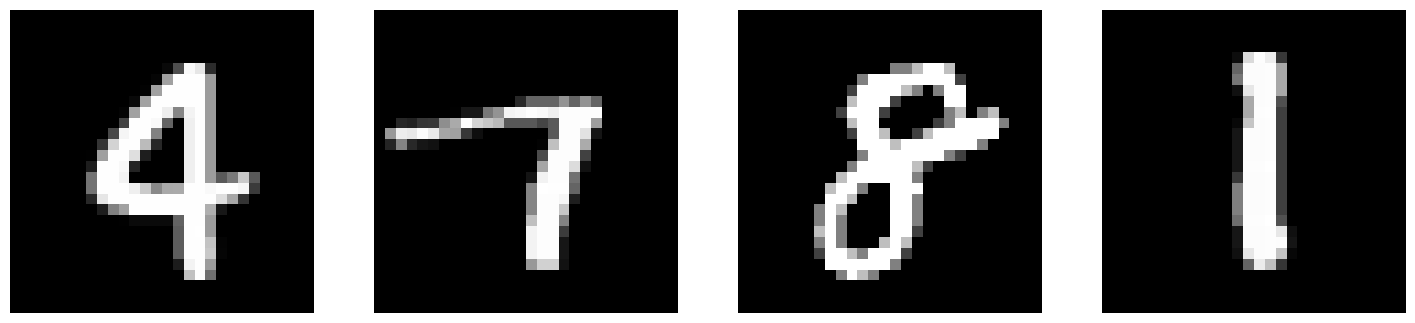

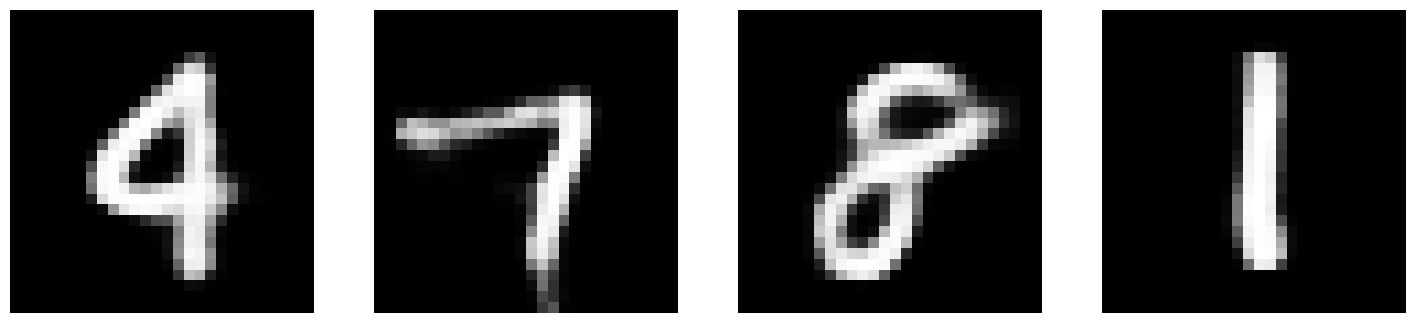

====> Epoch: 65 Average loss: 63.3304
====> Test set loss: 55.7986


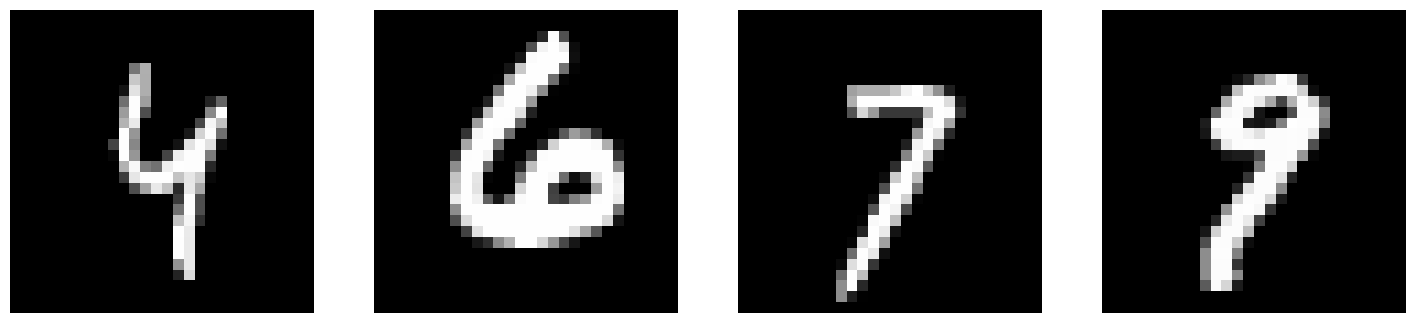

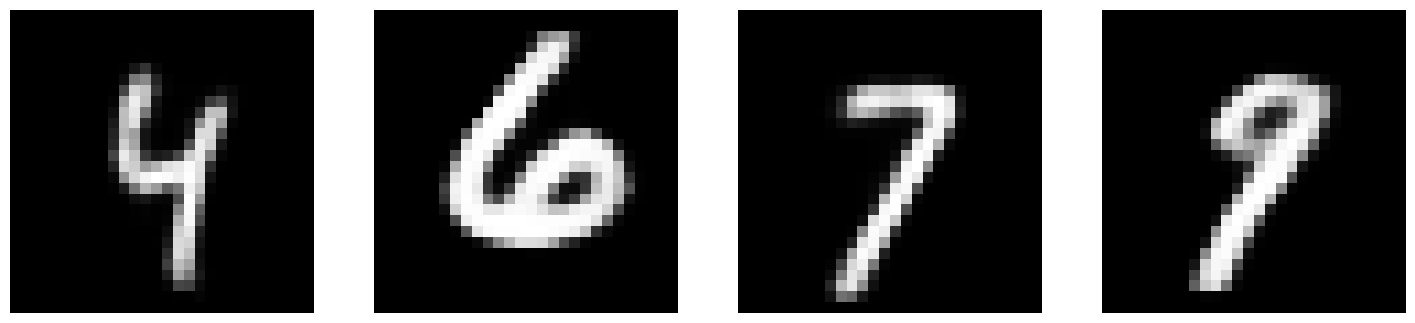

====> Epoch: 66 Average loss: 63.3215
====> Test set loss: 55.8095


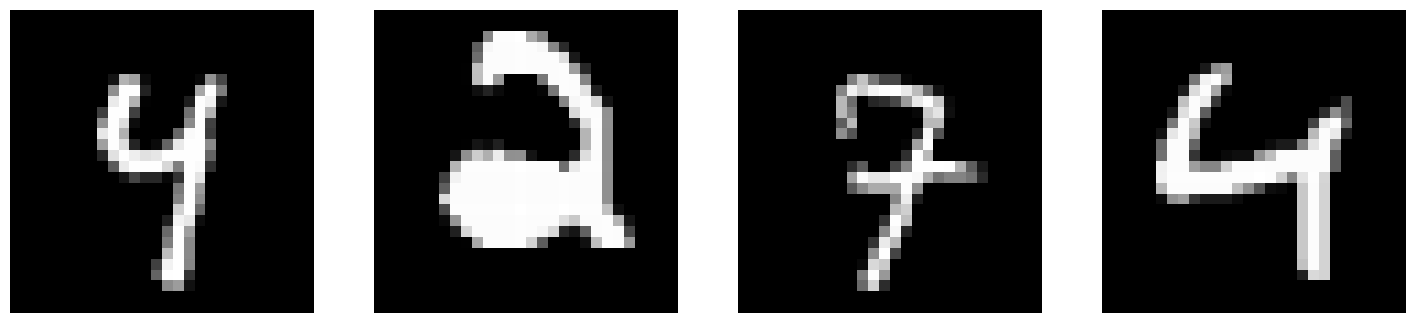

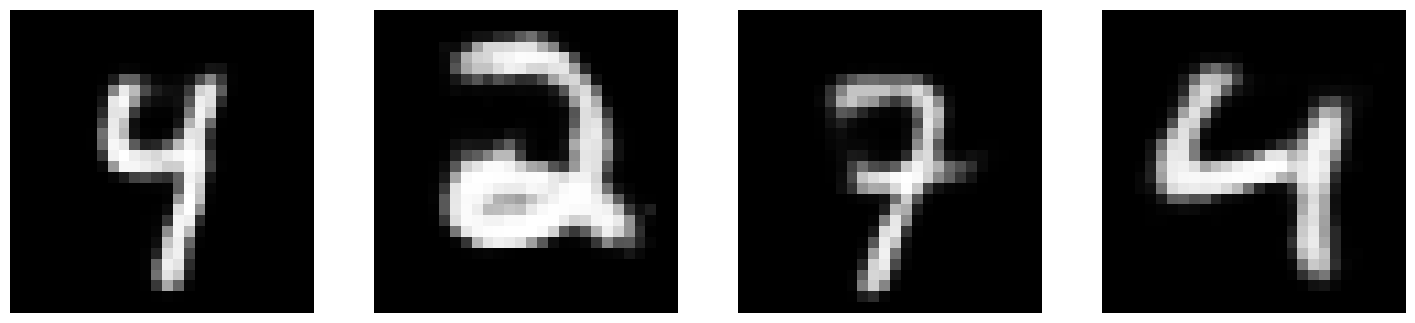

====> Epoch: 67 Average loss: 63.2234
====> Test set loss: 55.4137


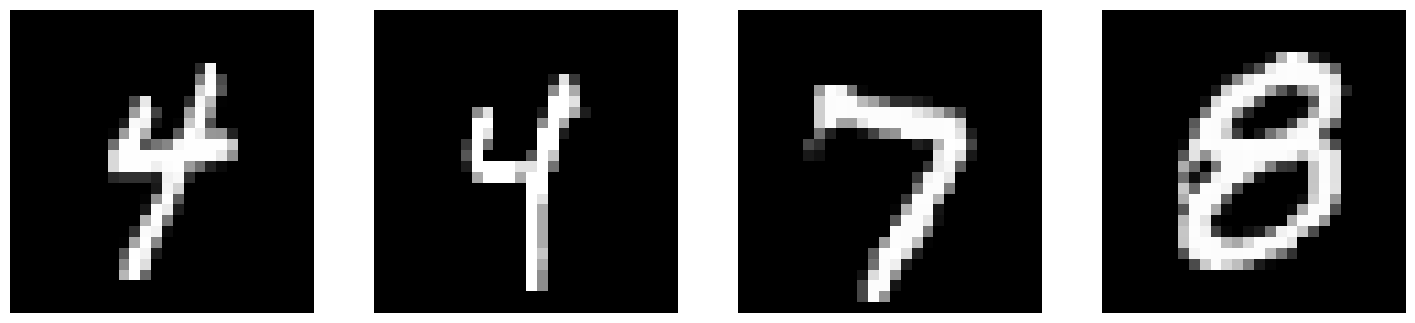

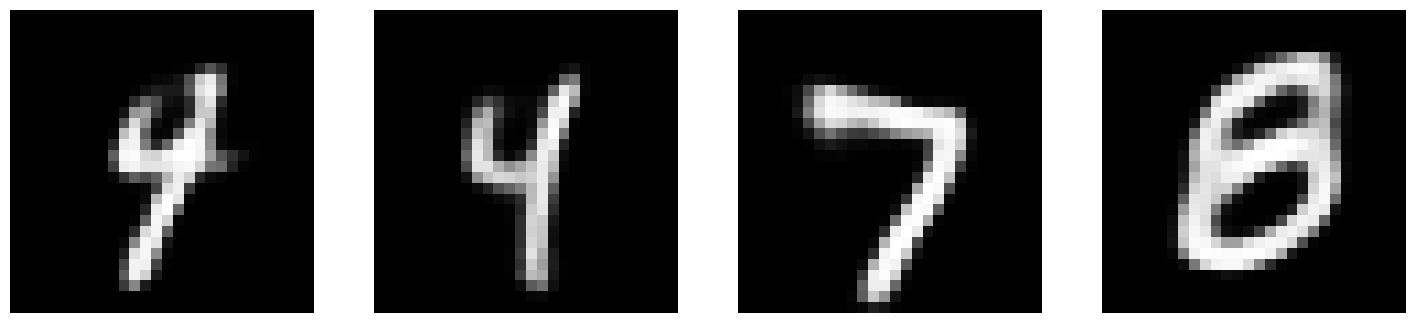

====> Epoch: 68 Average loss: 63.1945
====> Test set loss: 54.9684


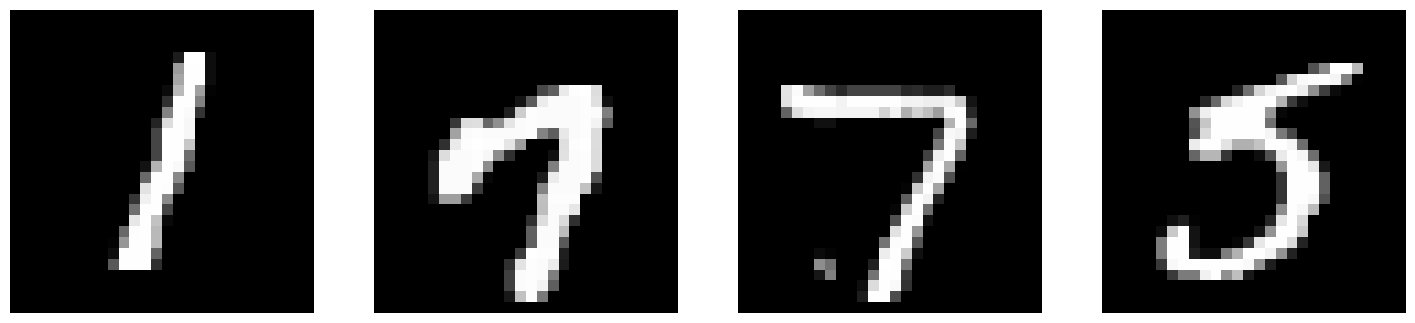

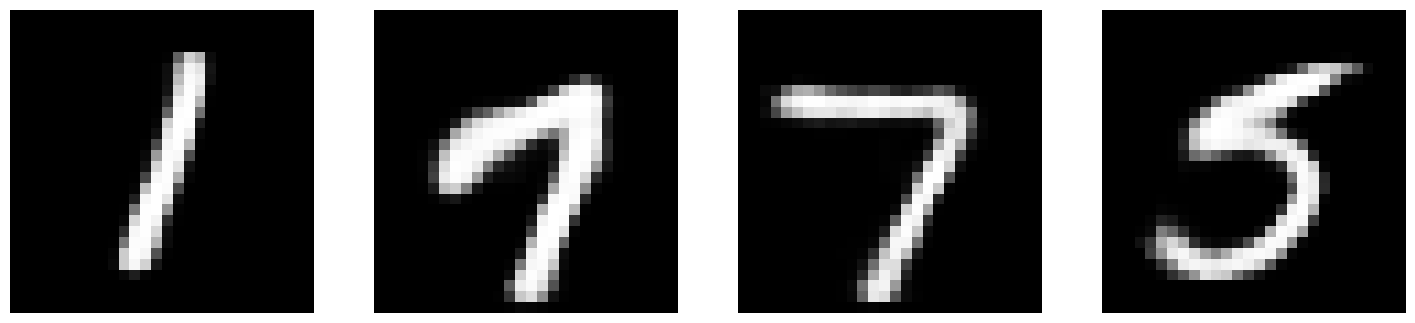

====> Epoch: 69 Average loss: 63.1688
====> Test set loss: 55.5162


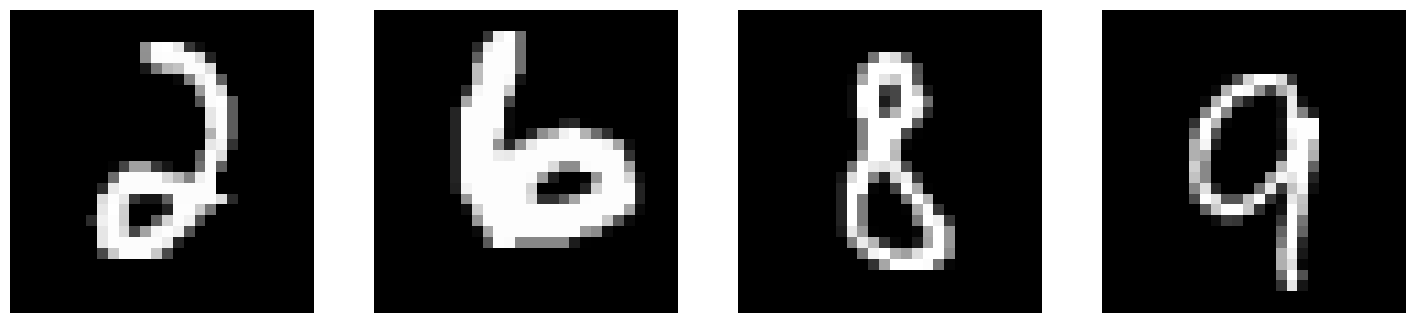

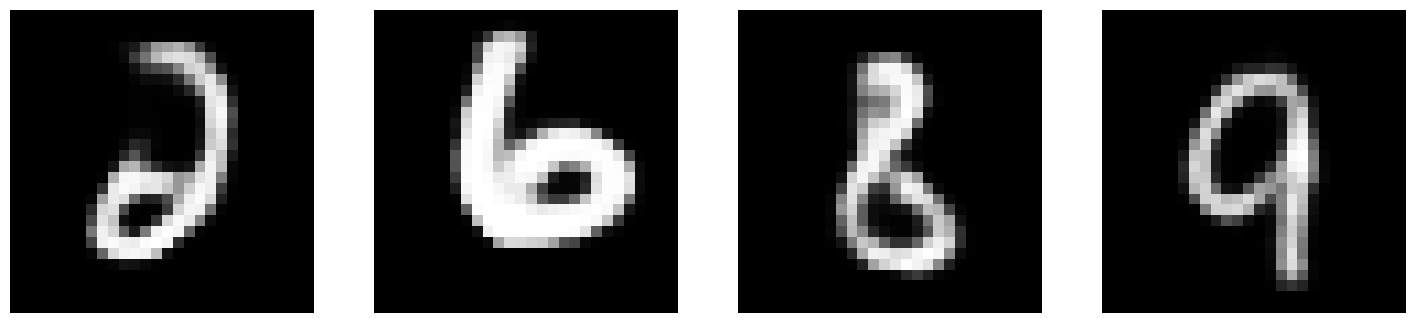

====> Epoch: 70 Average loss: 63.1250
====> Test set loss: 55.1699


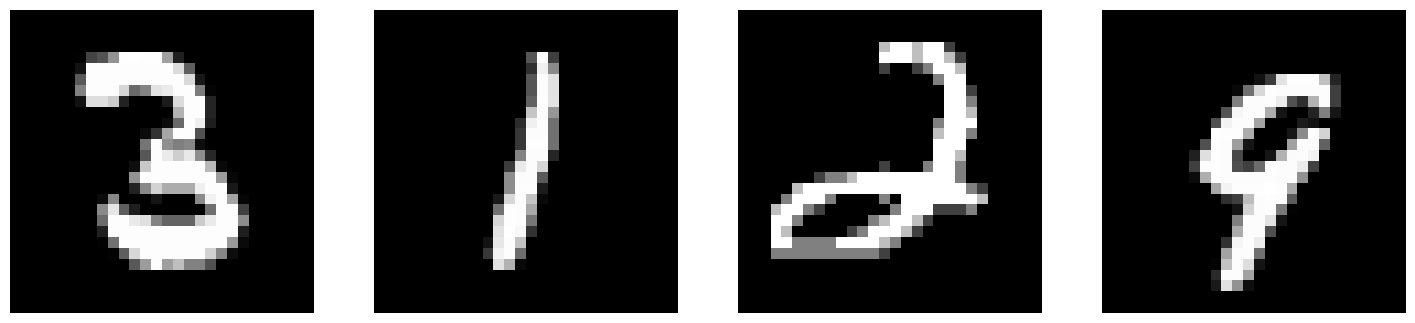

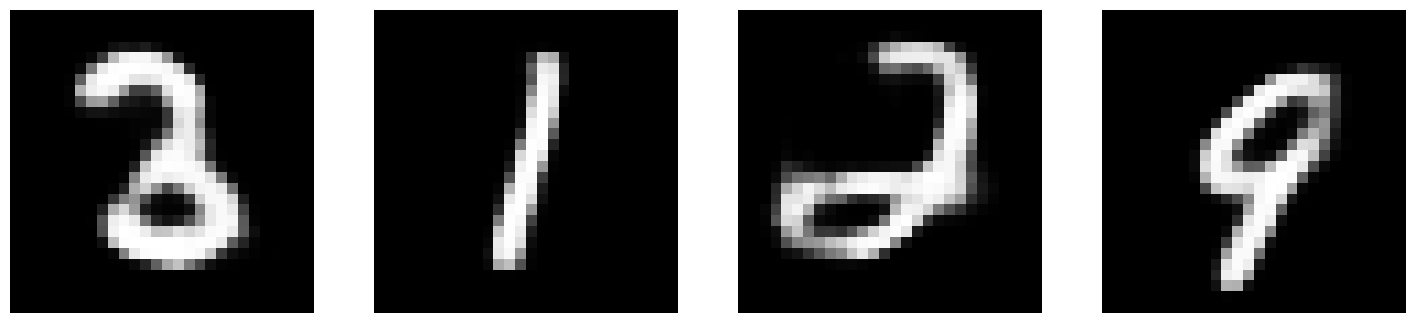

In [ ]:
# Train the VAE
latent_dim=20
model = VAE(latent_dim).to(device)

# Setting the optimiser
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epochs = 70
codes = dict(mu=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 4)

## Generating a few images from randomly sampled z

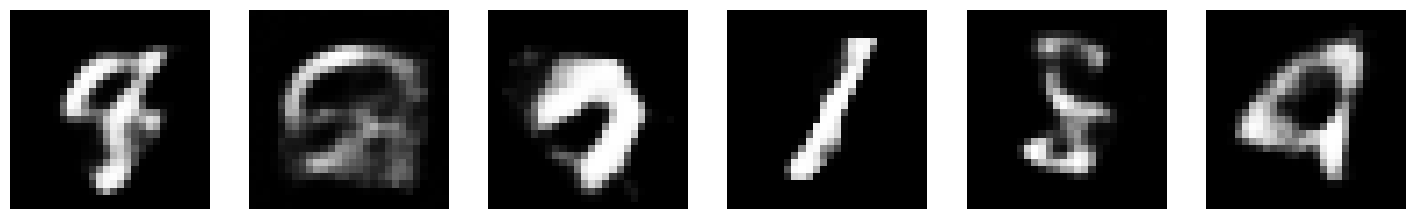

In [ ]:
N=6
display_images(None, model.generate(N), N)

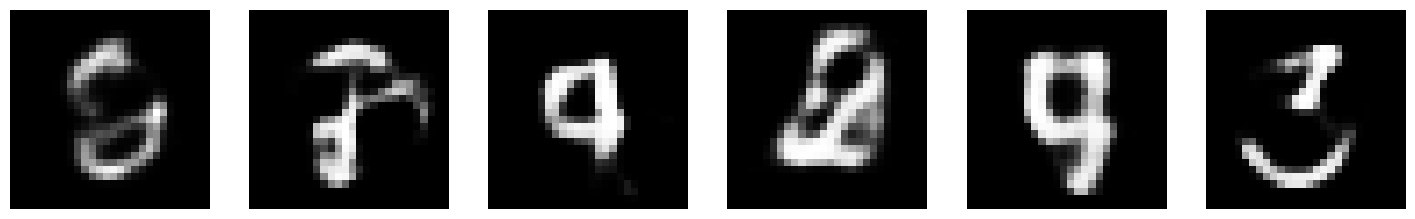

In [ ]:
N=6
display_images(None, model.generate(N), N)

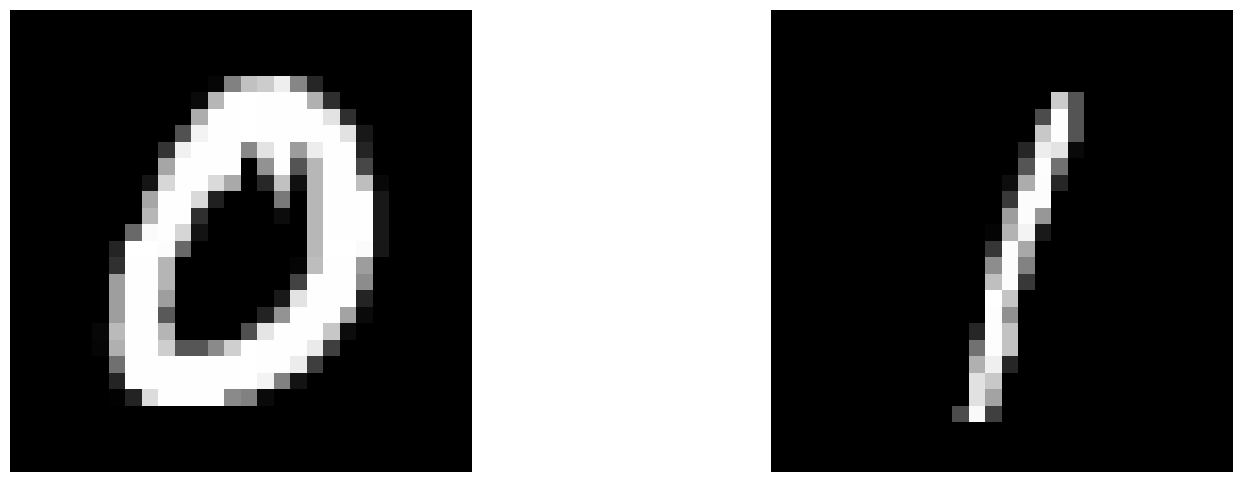

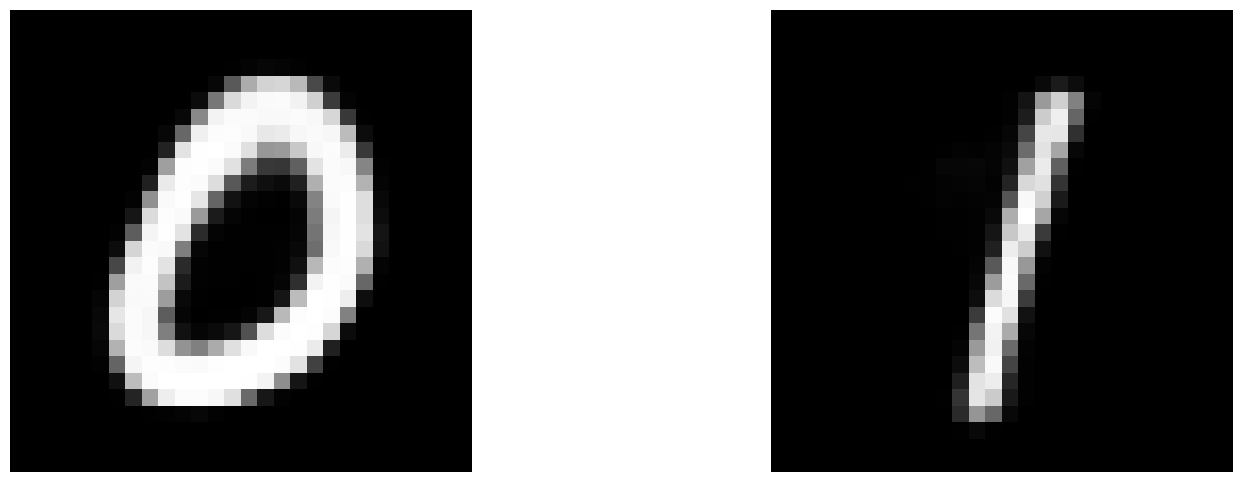

In [ ]:
x, _ = next(iter(test_loader))
x = x.to(device)
x_hat, mu, logvar = model(x)
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
#sample = torch.stack((x_hat[A].data, x_hat[B].data), 0)
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1)
)), 0), 2)
display_images(None, torch.stack(((
    sample.data[0],
    sample.data[1]
)), 0), 2)


## Let us interpolate between two images

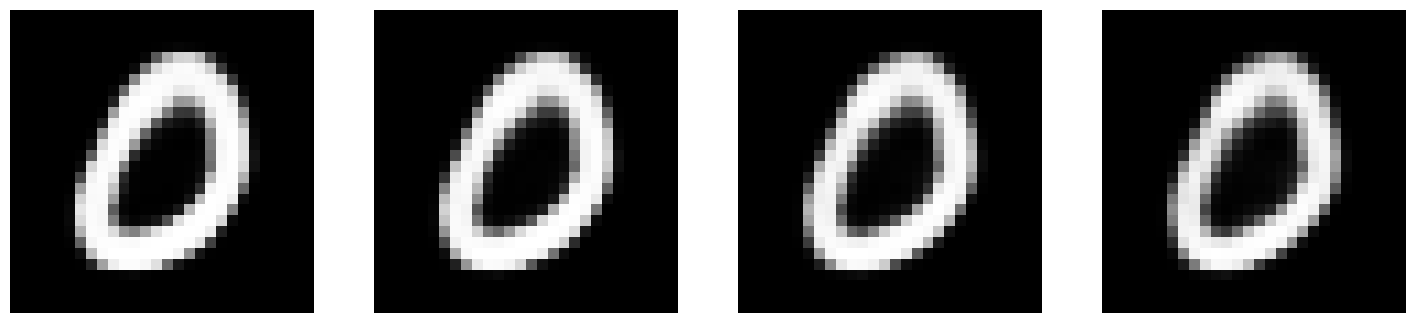

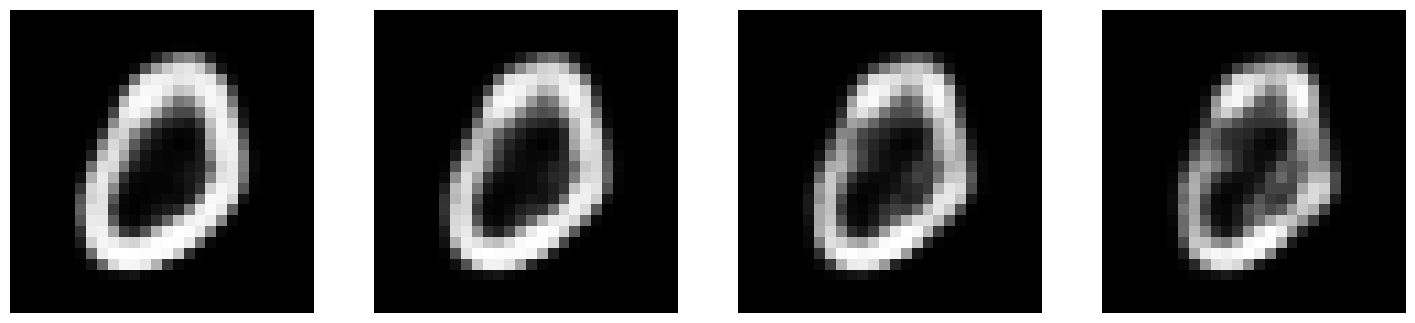

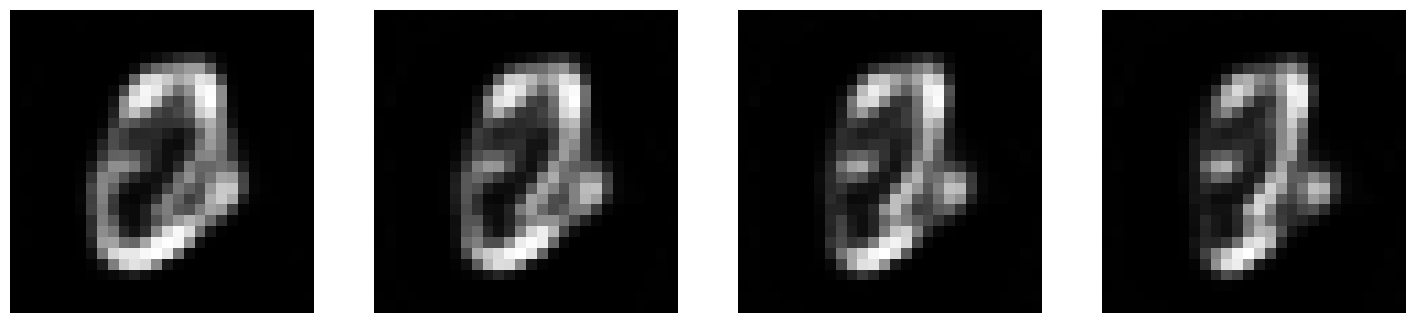

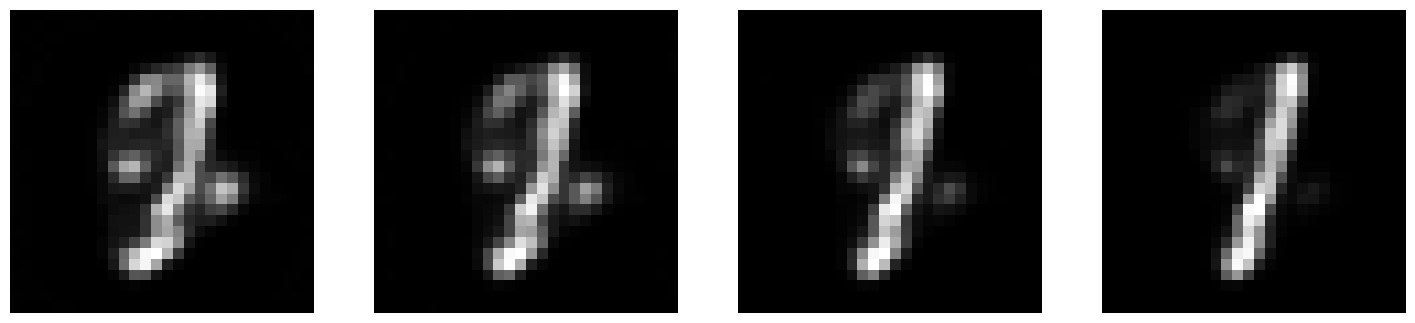

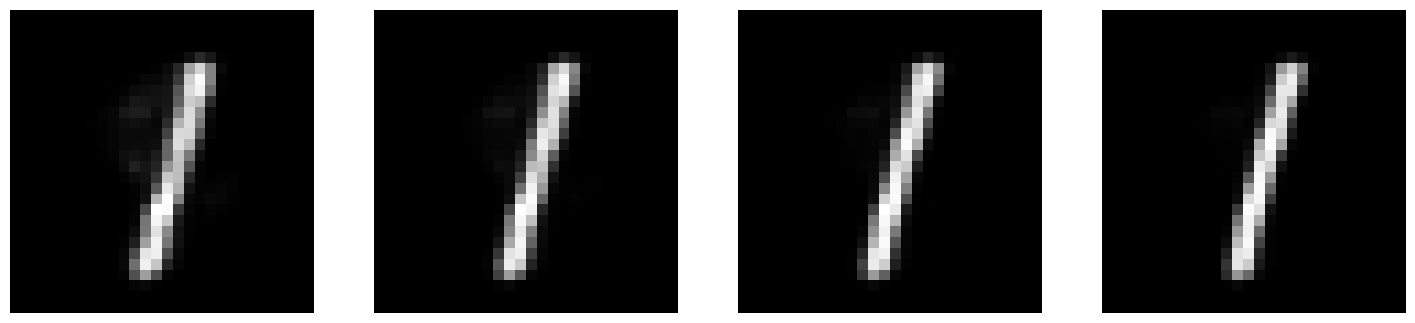

In [ ]:
# Perform an interpolation between input A and B, in N steps
N = 20
code = torch.Tensor(N, latent_dim).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
img_set = model.decoder(code)
for i in range(N//4):
    display_images(None, img_set[i*4:4*(i+1)], 4)

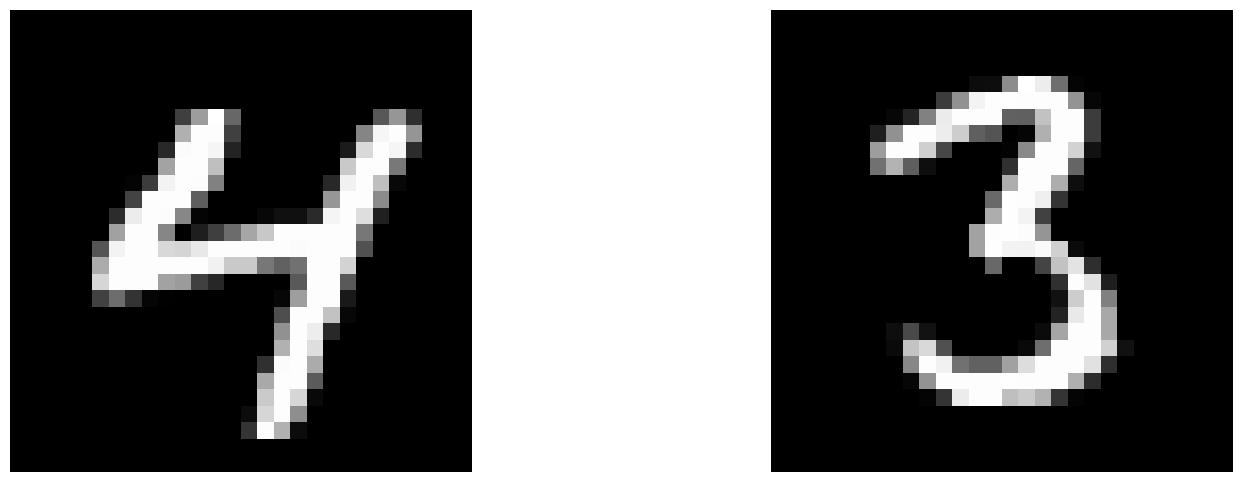

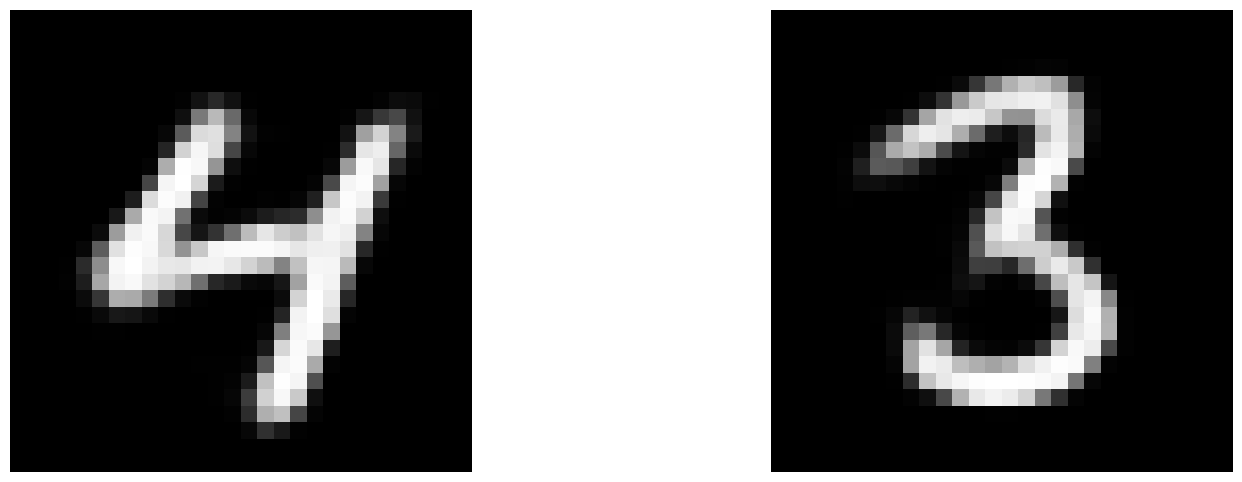

In [ ]:
x, _ = next(iter(test_loader))
x = x.to(device)
x_hat, mu, logvar = model(x)
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
#sample = torch.stack((x_hat[A].data, x_hat[B].data), 0)
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1)
)), 0), 2)
display_images(None, torch.stack(((
    sample.data[0],
    sample.data[1]
)), 0), 2)


## Let us interpolate between two images

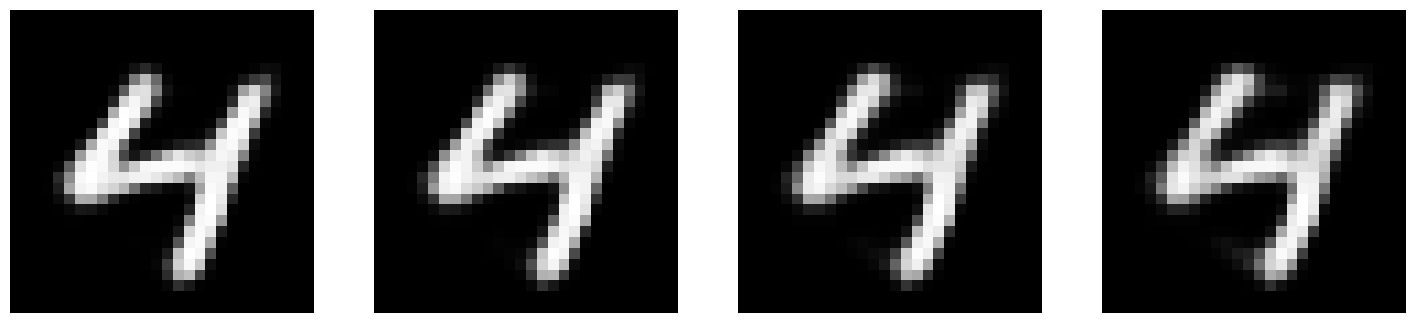

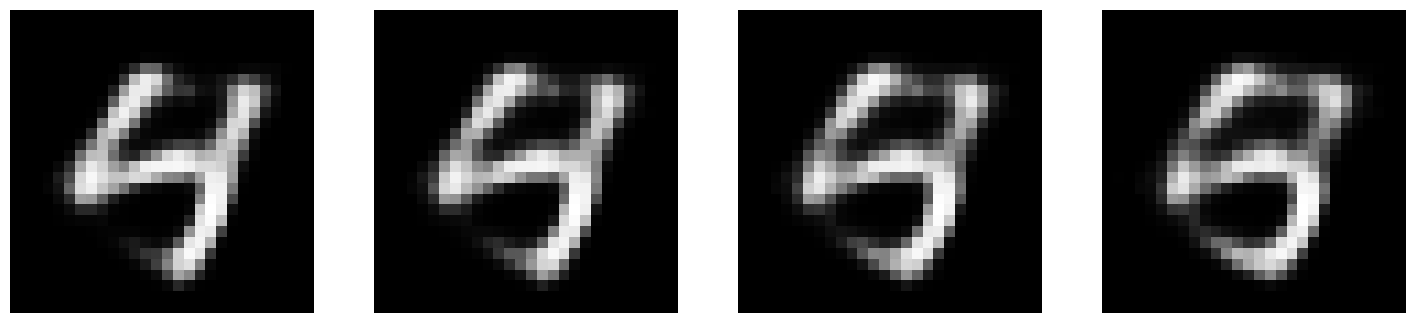

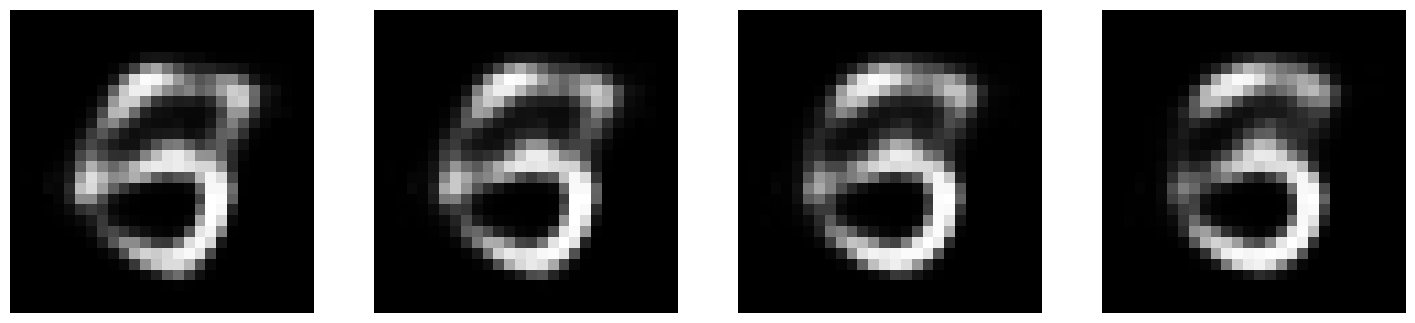

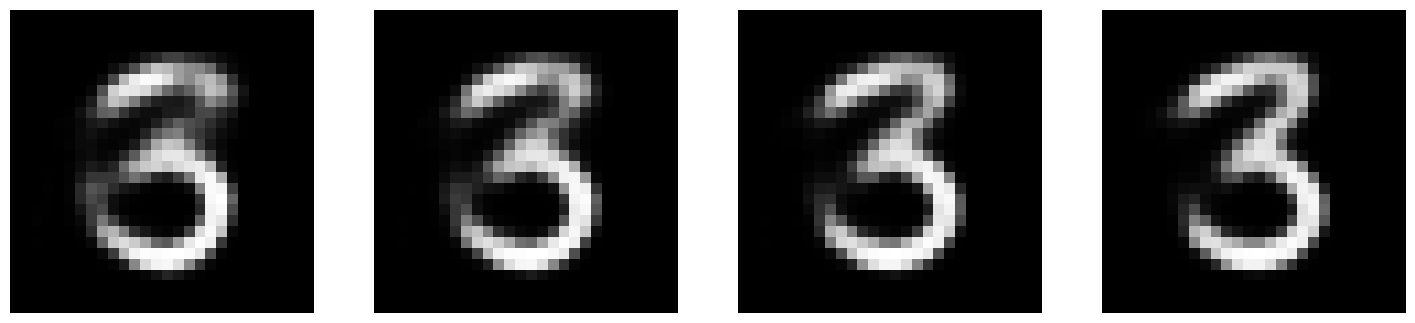

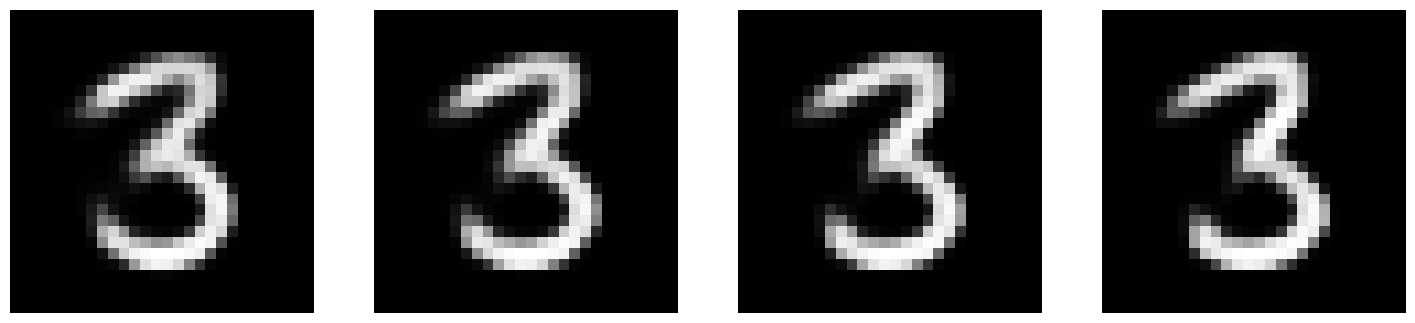

In [ ]:
# Perform an interpolation between input A and B, in N steps
N = 20
code = torch.Tensor(N, latent_dim).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
img_set = model.decoder(code)
for i in range(N//4):
    display_images(None, img_set[i*4:4*(i+1)], 4)